# Interactive Visualization Framework for Joyce Simile Analysis
## Notebook 3: Advanced Data Visualization

This notebook creates comprehensive interactive visualizations for Joyce simile research, including:

### Visualization Components:
- **Interactive Network Graphs** (Category-Comparator Relationships)
- **Wilson Score Confidence Intervals** (Statistical validation)
- **Topic Modeling Visualizations** (Thematic analysis)
- **Bee Swarm Plots** (Token distribution patterns)
- **Multi-dimensional Heatmaps** (Linguistic feature analysis)
- **Joyce vs BNC Comparative Analysis** (Innovation vs standard usage)
- **Interactive Dashboard** (Complete presentation framework)

### Research Focus:
Demonstrates Joyce's stylistic innovations through computational analysis and statistical validation, comparing simile patterns in *Dubliners* against British National Corpus baseline.

### Dependencies:
Requires: `comprehensive_linguistic_analysis.csv` (output from Notebook 2)

### Outputs:
- Interactive HTML visualizations
- Complete dashboard for thesis presentation
- Publication-ready figures with statistical validation

In [1]:
# =============================================================================
# INTERACTIVE VISUALIZATION FRAMEWORK FOR JOYCE SIMILE ANALYSIS — SETUP (Cell 1)
# =============================================================================

import os, glob, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Plotly (interactive)
import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Networks
import networkx as nx

# Stats
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu

# Optional: Colab detection
try:
    import google.colab  # noqa: F401
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# Plotly init & defaults
pyo.init_notebook_mode(connected=True)
px.defaults.template = "plotly_white"
px.defaults.width = 900
px.defaults.height = 520

print("INTERACTIVE VISUALIZATION FRAMEWORK FOR JOYCE SIMILE ANALYSIS")
print("=" * 65)

# ----------------------------
# Constants / Mappings
# ----------------------------

# Pretty group labels used in visuals
DATASET_LABELS = {
    "Manual_CloseReading":    "Joyce_Manual",
    "Restrictive_Dubliners":  "Joyce_Restrictive",
    "NLP_LessRestrictive_PG": "Joyce_LessRestrictive",
    "BNC_Baseline":           "BNC",
}
GROUP_ORDER = ["Joyce_Manual", "Joyce_Restrictive", "Joyce_LessRestrictive", "BNC"]

# Harmonised category mapping (defensive; re-applied in Cell 2)
CATEGORY_MAP = {
    # unify quasi labels
    "Joycean_Quasi": "Quasi_Similes",
    "Joycean-Quasi": "Quasi_Similes",
    "Quasi_Simile":  "Quasi_Similes",
    # tidy Joycean variants
    "Joycean-Quasi-Fuzzy": "Joycean_Quasi_Fuzzy",
    # stray dataset-name leaks → Standard
    "NLP_LessRestrictive": "Standard",
    "NLP_General_Pattern": "Standard",
    "Less-Restrictive":    "Standard",
    # housekeeping
    "Uncategorised": "Uncategorized",
    "nan": "Uncategorized", "NaN": "Uncategorized", "": "Uncategorized",
}

# Consistent colours
GROUP_COLORS = {
    "Joyce_Manual":          "#006BA2",
    "Joyce_Restrictive":     "#FF8C00",
    "Joyce_LessRestrictive": "#2E8B57",
    "BNC":                   "#8A8A8A",
}
CATEGORY_COLORS = {
    "Standard":            "#4C78A8",
    "Quasi_Similes":       "#F58518",
    "Joycean_Framed":      "#54A24B",
    "Joycean_Quasi_Fuzzy": "#B279A2",
    "Joycean_Silent":      "#9C755F",
    "Uncategorized":       "#BAB0AC",
}

# ----------------------------
# Robust dataset discovery (prefer *corrected*, pick newest)
# ----------------------------
from datetime import datetime

SEARCH_DIRS = [".", "/content"]  # add paths if you save elsewhere
PATTERNS = [
    "comprehensive_linguistic_analysis_corrected*.csv",  # preferred
    "comprehensive_linguistic_analysis*.csv",            # legacy fallback
]

def find_latest_dataset():
    """
    Search candidate directories for comprehensive dataset CSVs.
    Preference order: filenames containing 'corrected', then newest mtime.
    Prints a ranked list and returns (chosen_path, candidates_list).
    """
    candidates = []
    for d in SEARCH_DIRS:
        for pat in PATTERNS:
            for p in glob.glob(os.path.join(d, pat)):
                try:
                    candidates.append({
                        "path": p,
                        "mtime": os.path.getmtime(p),
                        "size": os.path.getsize(p),
                        "preferred": ("corrected" in os.path.basename(p).lower()),
                    })
                except Exception:
                    pass

    if not candidates:
        return None, []

    # sort: prefer corrected, then newest
    candidates.sort(key=lambda x: (x["preferred"], x["mtime"]), reverse=True)
    chosen = candidates[0]

    # pretty print summary
    print("\nDataset candidates (preferred → newest):")
    for c in candidates:
        tag = "✓" if c is chosen else " "
        when = datetime.fromtimestamp(c["mtime"]).strftime("%Y-%m-%d %H:%M:%S")
        pref = "preferred" if c["preferred"] else "fallback"
        print(f" {tag} {pref:9s} | {when} | {c['size']:,} B | {c['path']}")
    return chosen["path"], candidates

# ----------------------------
# Helpers for later visuals
# ----------------------------

def wilson_ci(count, n, alpha=0.05):
    """Wilson score interval for a binomial proportion."""
    if n is None or n <= 0:
        return (np.nan, np.nan, np.nan)
    p = count / n
    z = stats.norm.ppf(1 - alpha/2)
    denom = 1 + z**2 / n
    centre = (p + z**2/(2*n)) / denom
    half = z * np.sqrt((p*(1-p)/n) + (z**2/(4*n**2))) / denom
    return p, max(0.0, centre - half), min(1.0, centre + half)

def latest_in(dirpath, pattern):
    files = glob.glob(os.path.join(dirpath, pattern))
    return max(files, key=os.path.getctime) if files else None

def to_categorical(series, order):
    return pd.Categorical(series, categories=order, ordered=True)

print("Setup complete.")


INTERACTIVE VISUALIZATION FRAMEWORK FOR JOYCE SIMILE ANALYSIS
Setup complete.


In [2]:
# =============================================================================
# LOAD & PREPARE DATA (Cell 2 — Upload & Session Binding)
# =============================================================================
import os, io, sys, json, glob, warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from datetime import datetime

# --- helpers from Cell 1 expected: CATEGORY_MAP, DATASET_LABELS, GROUP_ORDER ---
if "CATEGORY_MAP" not in globals():
    CATEGORY_MAP = {
        "Joycean_Quasi": "Quasi_Similes", "Joycean-Quasi": "Quasi_Similes",
        "Quasi_Simile": "Quasi_Similes", "Joycean-Quasi-Fuzzy": "Joycean_Quasi_Fuzzy",
        "NLP_LessRestrictive":"Standard", "NLP_General_Pattern":"Standard", "Less-Restrictive":"Standard",
        "Uncategorised":"Uncategorized", "nan":"Uncategorized", "NaN":"Uncategorized", "":"Uncategorized",
    }
if "DATASET_LABELS" not in globals():
    DATASET_LABELS = {
        "Manual_CloseReading":"Joyce_Manual",
        "Restrictive_Dubliners":"Joyce_Restrictive",
        "NLP_LessRestrictive_PG":"Joyce_LessRestrictive",
        "BNC_Baseline":"BNC",
    }
if "GROUP_ORDER" not in globals():
    GROUP_ORDER = ["Joyce_Manual", "Joyce_Restrictive", "Joyce_LessRestrictive", "BNC"]

def _harmonise_and_prepare(df_raw: pd.DataFrame) -> pd.DataFrame:
    # Required columns
    required_cols = ["Original_Dataset", "Category_Framework", "Sentence_Context"]
    missing = [c for c in required_cols if c not in df_raw.columns]
    if missing:
        raise ValueError(f"Missing required column(s): {missing}")

    df = df_raw.copy()

    # Dataset label + Group
    df["Dataset"] = df.get("Original_Dataset", "").fillna(df.get("Dataset_Source", ""))
    df["Category_Framework"] = df["Category_Framework"].astype(str).map(lambda x: CATEGORY_MAP.get(x, x))
    df["Group"] = df["Original_Dataset"].map(DATASET_LABELS).fillna(df["Original_Dataset"])
    df["Group"] = pd.Categorical(df["Group"], categories=GROUP_ORDER, ordered=True)

    # Comparator cleanup & numeric casts
    df["Comparator_Type"] = df.get("Comparator_Type", "").fillna("").astype(str).str.strip()
    for c in ["Sentence_Length", "Pre_Post_Ratio", "Sentiment_Polarity", "Sentiment_Subjectivity"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _make_df_vis(df: pd.DataFrame) -> pd.DataFrame:
    cols = [
        "Instance_ID","Group","Original_Dataset","Dataset","Category_Framework","Comparator_Type",
        "Sentence_Context","Sentence_Length","Pre_Post_Ratio","Sentiment_Polarity","Sentiment_Subjectivity"
    ]
    return df[[c for c in cols if c in df.columns]].copy()

# -------- Upload (Colab first) --------
df_uploaded = None
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import files  # type: ignore
    print("Please upload the comprehensive dataset CSV (prefer the *corrected* file).")
    uploaded = files.upload()  # opens a file picker
    if uploaded:
        name, data = next(iter(uploaded.items()))
        print(f'Uploaded: "{name}" ({len(data)} bytes)')
        df_uploaded = pd.read_csv(io.BytesIO(data))
else:
    # Jupyter fallback with ipywidgets
    try:
        from IPython.display import display
        import ipywidgets as widgets
        uploader = widgets.FileUpload(accept=".csv", multiple=False, description="Upload CSV")
        display(uploader)

        # If the user selected a file before executing, read it immediately
        if uploader.value:
            item = next(iter(uploader.value.values()))
            name = item["metadata"]["name"]
            content = item["content"]
            print(f'Uploaded: "{name}" ({len(content)} bytes)')
            df_uploaded = pd.read_csv(io.BytesIO(content))
        else:
            print("No file detected yet. Use the button above to upload and re-run this cell.")
    except Exception as e:
        print("ipywidgets not available; please set a path manually:")
        print("  df_uploaded = pd.read_csv('/path/to/comprehensive_linguistic_analysis_corrected.csv')")

# -------- Validate, harmonise, persist, and bind to session --------
if df_uploaded is None or df_uploaded.empty:
    raise FileNotFoundError("No dataset loaded. Please upload your comprehensive CSV and re-run this cell.")

df = _harmonise_and_prepare(df_uploaded)
print(f"\nRows: {len(df):,}")
print("\nGroup counts:")
print(df["Group"].value_counts(dropna=False))
print("\nHarmonised category counts:")
print(df["Category_Framework"].value_counts())

# Save a canonical copy so later cells (and exports) have a stable path
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
canon_name = f"comprehensive_linguistic_analysis_corrected_uploaded_{stamp}.csv"
df.to_csv(canon_name, index=False)
CHOSEN_DATA_PATH = os.path.abspath(canon_name)

# Trimmed working frame for visuals
df_vis = _make_df_vis(df)

# Optionally expose a small session registry
SESSION = {
    "DATA_PATH": CHOSEN_DATA_PATH,
    "N_ROWS": len(df),
    "GENERATED_AT": stamp,
}
print(f"\n✓ Session data set. Using dataset: {CHOSEN_DATA_PATH}")
print("✓ df and df_vis are bound for subsequent visualization cells.")


Please upload the comprehensive dataset CSV (prefer the *corrected* file).


Saving comprehensive_linguistic_analysis_corrected-7.csv to comprehensive_linguistic_analysis_corrected-7.csv
Uploaded: "comprehensive_linguistic_analysis_corrected-7.csv" (946972 bytes)

Rows: 932

Group counts:
Group
Joyce_LessRestrictive    330
Joyce_Restrictive        218
BNC                      200
Joyce_Manual             184
Name: count, dtype: int64

Harmonised category counts:
Category_Framework
Standard               691
Quasi_Similes          182
Joycean_Quasi_Fuzzy     27
Joycean_Framed          22
Joycean_Silent           9
Uncategorized            1
Name: count, dtype: int64

✓ Session data set. Using dataset: /content/comprehensive_linguistic_analysis_corrected_uploaded_20250825_153008.csv
✓ df and df_vis are bound for subsequent visualization cells.


In [3]:
# =============================================================================
# LINGUISTIC FEATURE HEATMAPS — NON-OVERLAPPING COLORBARS (OUTSIDE SUBPLOTS)
# =============================================================================

import os, sys, io, glob, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler

# ----------------------------- data pickup helpers -----------------------------

def _try_in_memory():
    for name in ("df_vis", "df", "results_df", "GLOBAL_DF", "DF", "RAW_DF"):
        if name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty:
            print(f"Using in-memory dataset: {name} ({len(globals()[name])} rows)")
            return globals()[name].copy()
    return None

def _try_known_paths():
    candidates = []
    if "CHOSEN_DATA_PATH" in globals(): candidates.append(globals()["CHOSEN_DATA_PATH"])
    for var in ("DATASET_PATH", "LATEST_DATASET_PATH"):
        if var in globals() and isinstance(globals()[var], str): candidates.append(globals()[var])
    candidates += [
        "comprehensive_linguistic_analysis_corrected.csv",
        "comprehensive_linguistic_analysis.csv",
        "/content/comprehensive_linguistic_analysis_corrected.csv",
        "/content/comprehensive_linguistic_analysis.csv",
        "/mnt/data/comprehensive_linguistic_analysis_corrected.csv",
    ]
    for p in candidates:
        if isinstance(p, str) and os.path.exists(p):
            try:
                df = pd.read_csv(p)
                print(f"Loaded dataset from path: {p} ({len(df)} rows)")
                return df
            except Exception as e:
                print(f"[warn] Could not read {p}: {e}")
    return None

def _try_glob_search():
    search_dirs = [".", os.getcwd(), "/content", "/mnt/data"]
    patterns = [
        "comprehensive_linguistic_analysis_corrected*.csv",
        "comprehensive_linguistic_analysis*.csv",
    ]
    hits = []
    for d in search_dirs:
        for pat in patterns:
            for p in glob.glob(os.path.join(d, pat)):
                try:
                    hits.append({
                        "path": p,
                        "mtime": os.path.getmtime(p),
                        "preferred": ("corrected" in os.path.basename(p).lower())
                    })
                except Exception:
                    pass
    if not hits:
        return None
    hits.sort(key=lambda x: (x["preferred"], x["mtime"]), reverse=True)
    p = hits[0]["path"]
    try:
        df = pd.read_csv(p)
        print(f"Loaded dataset via search: {p} ({len(df)} rows)")
        return df
    except Exception as e:
        print(f"[warn] Could not read {p}: {e}")
        return None

def _upload_fallback():
    IN_COLAB = "google.colab" in sys.modules
    if IN_COLAB:
        try:
            from google.colab import files  # type: ignore
            print("Please upload the comprehensive CSV (prefer the *corrected* one).")
            up = files.upload()
            if up:
                name, data = next(iter(up.items()))
                print(f'Uploaded: "{name}" ({len(data)} bytes)')
                return pd.read_csv(io.BytesIO(data))
        except Exception as e:
            print(f"[warn] Colab upload failed: {e}")
    return None

def _get_corpus_dataset():
    for fn in (_try_in_memory, _try_known_paths, _try_glob_search, _upload_fallback):
        df = fn()
        if isinstance(df, pd.DataFrame) and not df.empty:
            return df
    raise FileNotFoundError("No dataset available. Upload the CSV or ensure a path is set.")

# ---------------------------- prep + label harmonisation ----------------------------

def _prepare_for_viz(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()

    if "Original_Dataset" not in df.columns:
        if "Dataset" in df.columns:
            df["Original_Dataset"] = df["Dataset"]
        elif "Dataset_Source" in df.columns:
            df["Original_Dataset"] = df["Dataset_Source"]
        else:
            df["Original_Dataset"] = "Unknown"

    ds_map = {
        "Manual_CloseReading": "Joyce_Manual",
        "Restrictive_Dubliners": "Joyce_Restrictive",
        "NLP_LessRestrictive_PG": "Joyce_LessRestrictive",
        "BNC_Baseline": "BNC",
    }
    df["Dataset_Display"] = df["Original_Dataset"].map(ds_map).fillna(df["Original_Dataset"])

    cat_map = {
        "Joycean_Quasi": "Quasi_Similes",
        "Quasi_Simile": "Quasi_Similes",
        "Quasi_Similes": "Quasi_Similes",
        "Joycean_Framed": "Joycean Framed",
        "Joycean_Quasi_Fuzzy": "Joycean Quasi-Fuzzy",
        "Joycean_Silent": "Joycean Silent",
        "Standard": "Standard",
        "Uncategorized": "Uncategorized",
    }
    df["Category_Display"] = df["Category_Framework"].map(cat_map).fillna(df["Category_Framework"])
    return df

# --------------------------------- main plot ---------------------------------

def generate_linguistic_heatmap_visualization(corpus_data: pd.DataFrame):
    print("\nGenerating comprehensive linguistic feature heatmaps...")
    print("=" * 55)

    linguistic_features = [
        "Pre_Comparator_Tokens", "Post_Comparator_Tokens", "Pre_Post_Ratio",
        "Total_Tokens", "Sentiment_Polarity", "Sentiment_Subjectivity",
        "Syntactic_Complexity"
    ]
    display_labels = [
        "Pre-Comp Tokens", "Post-Comp Tokens", "Token Ratio",
        "Total Length", "Sentiment Pol.", "Sentiment Sub.", "Syntax Score"
    ]

    df = _prepare_for_viz(corpus_data)
    dataset_identifier = "Dataset_Display"

    feature_exists = [f for f in linguistic_features if f in df.columns]
    missing_feats = [f for f in linguistic_features if f not in df.columns]
    if missing_feats:
        print(f"Warning: missing features will be skipped: {missing_feats}")
    if not feature_exists:
        raise ValueError("No required linguistic feature columns found.")

    cols_needed = [dataset_identifier, "Category_Display"] + feature_exists
    analysis_df = df[cols_needed].dropna(subset=feature_exists)
    print(f"Processing {len(analysis_df)} complete linguistic records")
    if analysis_df.empty:
        print("Error: No complete records found for heatmap generation")
        return None, None

    grouped_stats = analysis_df.groupby([dataset_identifier, "Category_Display"]).agg({
        f: ["mean", "std", "count"] for f in feature_exists
    }).round(3)
    grouped_stats.columns = [f"{metric}_{stat}" for metric, stat in grouped_stats.columns]
    summary_table = grouped_stats.reset_index()

    multi_panel_fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            "Inter-Feature Correlation Matrix",
            "Corpus-Category Feature Intensity",
            "Linguistic Feature Means by Dataset",
            "Feature Variance by Dataset"
        ),
        specs=[[{"type": "heatmap"}, {"type": "heatmap"}],
               [{"type": "heatmap"}, {"type": "heatmap"}]],
        horizontal_spacing=0.22,
        vertical_spacing=0.15
    )

    # Panel 1 — Correlation
    corr_df = analysis_df[feature_exists]
    corr = corr_df.corr(numeric_only=True)
    disp_corr = [dl for dl, f in zip(display_labels, linguistic_features) if f in feature_exists]
    multi_panel_fig.add_trace(go.Heatmap(
        z=corr.values, x=disp_corr, y=disp_corr,
        colorscale="RdBu_r", zmid=0,
        text=corr.round(3).values, texttemplate="%{text}", textfont={"size": 9},
        hovertemplate="<b>%{y} × %{x}</b><br>r = %{z:.3f}<extra></extra>",
        colorbar=dict(title="r", thickness=12)
    ), row=1, col=1)

    # Panel 2 — Intensity (z-scored means for dataset×category)
    rows, labels = [], []
    for _, rec in summary_table.iterrows():
        mean_vals = [rec.get(f"{f}_mean", np.nan) for f in feature_exists]
        rows.append(mean_vals)
        cat = rec["Category_Display"]
        cat_short = (cat if len(str(cat)) <= 18 else str(cat)[:15] + "…")
        labels.append(f'{rec[dataset_identifier]}_{cat_short}')
    if rows:
        raw = np.array(rows, dtype=float)
        scaler = StandardScaler()
        raw = np.nan_to_num(raw, nan=0.0)
        zscores = scaler.fit_transform(raw)
        disp_int = [dl for dl, f in zip(display_labels, linguistic_features) if f in feature_exists]
        multi_panel_fig.add_trace(go.Heatmap(
            z=zscores, x=disp_int, y=labels,
            colorscale="Plasma",
            text=np.round(raw, 2), texttemplate="%{text}", textfont={"size": 6},
            hovertemplate="<b>%{y}</b><br>%{x}: %{text}<br>Z = %{z:.2f}<extra></extra>",
            colorbar=dict(title="Z-score", thickness=12)
        ), row=1, col=2)

    # Panel 3 — Means by dataset
    ds_means = analysis_df.groupby(dataset_identifier)[feature_exists].mean().sort_index()
    if not ds_means.empty:
        disp_means = [dl for dl, f in zip(display_labels, linguistic_features) if f in feature_exists]
        multi_panel_fig.add_trace(go.Heatmap(
            z=ds_means.values, x=disp_means, y=ds_means.index.tolist(),
            colorscale="Viridis",
            text=np.round(ds_means.values, 2), texttemplate="%{text}", textfont={"size": 11},
            hovertemplate="<b>Dataset: %{y}</b><br>%{x}: %{z:.2f}<extra></extra>",
            colorbar=dict(title="Mean", thickness=12)
        ), row=2, col=1)
    else:
        multi_panel_fig.add_annotation(
            text="Insufficient data for mean-by-dataset panel",
            xref="x domain", yref="y domain", x=0.5, y=0.5,
            showarrow=False, font=dict(size=12, color="gray"),
            row=2, col=1
        )

    # Panel 4 — Variance by dataset
    ds_types = ds_means.index.tolist() if not ds_means.empty else analysis_df[dataset_identifier].unique().tolist()
    var_matrix = []
    for ds in ds_types:
        sub = analysis_df[analysis_df[dataset_identifier] == ds]
        var_matrix.append(sub[feature_exists].var().values if len(sub) else [np.nan]*len(feature_exists))
    if var_matrix:
        var_arr = np.array(var_matrix, dtype=float)
        disp_var = [dl for dl, f in zip(display_labels, linguistic_features) if f in feature_exists]
        multi_panel_fig.add_trace(go.Heatmap(
            z=var_arr, x=disp_var, y=ds_types,
            colorscale="YlOrRd",
            text=np.round(var_arr, 2), texttemplate="%{text}", textfont={"size": 10},
            hovertemplate="<b>%{y}</b><br>%{x} variance: %{z:.2f}<extra></extra>",
            colorbar=dict(title="Variance", thickness=12)
        ), row=2, col=2)

    # Layout
    multi_panel_fig.update_layout(
        title={'text': "Linguistic Feature Analysis: Multi-Dimensional Heatmaps",
               'x': 0.5, 'font': {'size': 20, 'family': 'Times New Roman'}},
        height=1200, width=1650, showlegend=False,
        font=dict(size=12, family='Times New Roman'),
        # big side margins to hold the OUTSIDE colorbars
        margin=dict(l=230, r=260, t=110, b=90),
        plot_bgcolor='#fafafa', paper_bgcolor='white'
    )
    multi_panel_fig.update_annotations(font_size=15, font_family="Times New Roman", font_color="#2c3e50")
    for r in (1, 2):
        for c in (1, 2):
            multi_panel_fig.update_xaxes(tickangle=35, tickfont=dict(size=10), row=r, col=c)
            multi_panel_fig.update_yaxes(tickfont=dict(size=10), row=r, col=c)
    multi_panel_fig.update_yaxes(tickfont=dict(size=8), row=1, col=2)

    # -------------------- colorbars OUTSIDE each subplot (no overlap) --------------------
    xa11 = multi_panel_fig.layout.xaxis.domain
    ya11 = multi_panel_fig.layout.yaxis.domain
    xa12 = multi_panel_fig.layout.xaxis2.domain
    ya12 = multi_panel_fig.layout.yaxis2.domain
    xa21 = multi_panel_fig.layout.xaxis3.domain
    ya21 = multi_panel_fig.layout.yaxis3.domain
    xa22 = multi_panel_fig.layout.xaxis4.domain
    ya22 = multi_panel_fig.layout.yaxis4.domain

    def _yc(dom): return (dom[0] + dom[1]) / 2.0
    def _ylen(dom, frac=0.85): return (dom[1] - dom[0]) * frac

    # how far OUTSIDE the subplot to place bars (paper coords)
    LEFT_OFFSET  = 0.055   # to the left of left-column subplots
    RIGHT_OFFSET = 0.060   # to the right of right-column subplots

    # data order: [0]=corr(r1c1), [1]=intensity(r1c2), [2]=means(r2c1), [3]=variance(r2c2)
    if len(multi_panel_fig.data) >= 1 and hasattr(multi_panel_fig.data[0], "colorbar"):
        multi_panel_fig.data[0].update(colorbar=dict(
            x=xa11[0] - LEFT_OFFSET,  # OUTSIDE left
            y=_yc(ya11),
            len=_ylen(ya11, 0.88),
            xanchor="right",
            yanchor="middle",
            thickness=12,
            title=multi_panel_fig.data[0].colorbar.title.text
        ))

    if len(multi_panel_fig.data) >= 2 and hasattr(multi_panel_fig.data[1], "colorbar"):
        multi_panel_fig.data[1].update(colorbar=dict(
            x=xa12[1] + RIGHT_OFFSET,  # OUTSIDE right
            y=_yc(ya12),
            len=_ylen(ya12, 0.88),
            xanchor="left",
            yanchor="middle",
            thickness=12,
            title=multi_panel_fig.data[1].colorbar.title.text
        ))

    if len(multi_panel_fig.data) >= 3 and hasattr(multi_panel_fig.data[2], "colorbar"):
        multi_panel_fig.data[2].update(colorbar=dict(
            x=xa21[0] - LEFT_OFFSET,   # OUTSIDE left
            y=_yc(ya21),
            len=_ylen(ya21, 0.88),
            xanchor="right",
            yanchor="middle",
            thickness=12,
            title=multi_panel_fig.data[2].colorbar.title.text
        ))

    if len(multi_panel_fig.data) >= 4 and hasattr(multi_panel_fig.data[3], "colorbar"):
        multi_panel_fig.data[3].update(colorbar=dict(
            x=xa22[1] + RIGHT_OFFSET,  # OUTSIDE right
            y=_yc(ya22),
            len=_ylen(ya22, 0.88),
            xanchor="left",
            yanchor="middle",
            thickness=12,
            title=multi_panel_fig.data[3].colorbar.title.text
        ))
    # -------------------------------------------------------------------------------------

    # Save + show
    out_name = "linguistic_feature_heatmap_analysis_updated_all_datasets.html"
    multi_panel_fig.write_html(out_name)
    print(f"\nVisualization saved as: {out_name}")

    try:
        from google.colab import files
        files.download(out_name)
        print(f"Downloaded: {out_name}")
    except Exception:
        pass

    multi_panel_fig.show()
    print("Multi-dimensional heatmap analysis completed.")
    return multi_panel_fig, summary_table

# ----------------------------------- RUN -----------------------------------

corpus_dataset = _get_corpus_dataset()
print("\nSTARTING LINGUISTIC FEATURE HEATMAP ANALYSIS")
print("=" * 50)
viz_fig, feature_summary = generate_linguistic_heatmap_visualization(corpus_dataset)


Using in-memory dataset: df_vis (932 rows)

STARTING LINGUISTIC FEATURE HEATMAP ANALYSIS

Generating comprehensive linguistic feature heatmaps...
Processing 908 complete linguistic records

Visualization saved as: linguistic_feature_heatmap_analysis_updated_all_datasets.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: linguistic_feature_heatmap_analysis_updated_all_datasets.html


Multi-dimensional heatmap analysis completed.


In [4]:
# =============================================================================
# EFFECT-SIZE DUMBBELL PLOTS — JOYCE SUBSETS VS BNC (95% BOOTSTRAP CIs)
# Legend placed as a vertical panel on the right; no caption line.
# =============================================================================
import os, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
from plotly.subplots import make_subplots

rng = np.random.default_rng(42)

# ------------------------------- data helpers --------------------------------
def _get_df_for_viz():
    """Use an in-memory DataFrame if present; otherwise load from common paths."""
    for name in ("GLOBAL_DF", "results_df", "df_vis", "df"):
        if name in globals():
            _df = globals()[name]
            if isinstance(_df, pd.DataFrame) and not _df.empty:
                print(f"Using in-memory dataset: {name} ({len(_df)} rows)")
                return _df.copy()
    candidates = [
        globals().get("CHOSEN_DATA_PATH", None),
        "comprehensive_linguistic_analysis_corrected.csv",
        "comprehensive_linguistic_analysis.csv",
        "/content/comprehensive_linguistic_analysis_corrected.csv",
        "/content/comprehensive_linguistic_analysis.csv",
    ]
    for p in [c for c in candidates if isinstance(c, str)]:
        if os.path.exists(p):
            df = pd.read_csv(p)
            print(f"Loaded dataset from: {p} ({len(df)} rows)")
            return df
    raise FileNotFoundError("No dataset found. Upload or place the CSV in the working directory.")

def _prep_labels(df_in: pd.DataFrame) -> pd.DataFrame:
    ds_map = {
        "Manual_CloseReading": "Joyce_Manual",
        "Restrictive_Dubliners": "Joyce_Restrictive",
        "NLP_LessRestrictive_PG": "Joyce_LessRestrictive",
        "BNC_Baseline": "BNC",
    }
    df = df_in.copy()
    if "Original_Dataset" not in df.columns:
        if "Dataset" in df.columns:
            df["Original_Dataset"] = df["Dataset"]
        elif "Dataset_Source" in df.columns:
            df["Original_Dataset"] = df["Dataset_Source"]
        else:
            df["Original_Dataset"] = "Unknown"
    df["Dataset_Display"] = df["Original_Dataset"].map(ds_map).fillna(df["Original_Dataset"])
    return df

# ------------------------------ effect-size calc -----------------------------
def _bootstrap_mean_diff(a: np.ndarray, b: np.ndarray, n_boot: int = 2000):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    if len(a) < 5 or len(b) < 5:
        return np.nan, np.nan, np.nan
    diffs = np.empty(n_boot, dtype=float)
    na, nb = len(a), len(b)
    for _ in range(n_boot):
        diffs[_] = a[rng.integers(0, na, na)].mean() - b[rng.integers(0, nb, nb)].mean()
    center = float(diffs.mean())
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    return center, float(lo), float(hi)

# --------------------------------- plotting ----------------------------------
def plot_effect_size_dumbbells(df_in: pd.DataFrame):
    print("Building effect-size plots (Δ mean = Joyce subset − BNC)…")
    df = _prep_labels(df_in)

    feature_all = [
        "Pre_Comparator_Tokens", "Post_Comparator_Tokens", "Pre_Post_Ratio",
        "Total_Tokens", "Sentiment_Polarity", "Sentiment_Subjectivity",
        "Syntactic_Complexity"
    ]
    features = [c for c in feature_all if c in df.columns]
    if not features:
        raise ValueError("No required linguistic feature columns present.")
    if "BNC" not in df["Dataset_Display"].unique():
        raise ValueError("BNC baseline not found; cannot compute differences.")

    joyce_order = [d for d in ["Joyce_Manual","Joyce_Restrictive","Joyce_LessRestrictive"]
                   if d in df["Dataset_Display"].unique()]

    rows = []
    for feat in features:
        bnc_vals = pd.to_numeric(df.loc[df["Dataset_Display"]=="BNC", feat],
                                 errors="coerce").dropna().values
        for subset in joyce_order:
            a_vals = pd.to_numeric(df.loc[df["Dataset_Display"]==subset, feat],
                                   errors="coerce").dropna().values
            delta, lo, hi = _bootstrap_mean_diff(a_vals, bnc_vals, n_boot=2000)
            rows.append({"feature": feat, "subset": subset,
                         "delta": delta, "ci_lo": lo, "ci_hi": hi,
                         "n_subset": len(a_vals), "n_bnc": len(bnc_vals)})
    eff = pd.DataFrame(rows)

    feat_label_map = {
        "Pre_Comparator_Tokens": "Pre-Comparator Tokens",
        "Post_Comparator_Tokens": "Post-Comparator Tokens",
        "Pre_Post_Ratio": "Pre/Post Ratio",
        "Total_Tokens": "Total Length (tokens)",
        "Sentiment_Polarity": "Sentiment Polarity",
        "Sentiment_Subjectivity": "Sentiment Subjectivity",
        "Syntactic_Complexity": "Syntactic Complexity",
    }
    eff["feature_label"] = eff["feature"].map(feat_label_map).fillna(eff["feature"])

    n_feat = eff["feature_label"].nunique()
    fig = make_subplots(
        rows=n_feat, cols=1, shared_xaxes=False,
        vertical_spacing=0.065,
        subplot_titles=[f"{fl}" for fl in eff["feature_label"].unique()]
    )

    color_map = {"Joyce_Manual": "#1f77b4", "Joyce_Restrictive": "#2ca02c", "Joyce_LessRestrictive": "#d62728"}
    y_positions = {"Joyce_Manual": 1.0, "Joyce_Restrictive": 0.7, "Joyce_LessRestrictive": 0.4}

    # BNC zero line on every facet
    for r in range(1, n_feat+1):
        fig.add_vline(x=0, line_width=1, line_dash="dash", line_color="gray", row=r, col=1)

    # points with CIs; legend shows each subset once
    for r, (feat_lab, df_row) in enumerate(eff.groupby("feature_label"), start=1):
        fig.update_yaxes(
            tickmode="array",
            tickvals=[1.0, 0.7, 0.4][:len(df_row)],
            ticktext=[s for s in joyce_order if s in df_row["subset"].values],
            row=r, col=1
        )
        for subset in joyce_order:
            sub = df_row[df_row["subset"] == subset]
            if sub.empty:
                continue
            y0 = y_positions[subset]
            delta = float(sub["delta"].iloc[0]) if pd.notna(sub["delta"].iloc[0]) else np.nan
            lo = float(sub["ci_lo"].iloc[0]) if pd.notna(sub["ci_lo"].iloc[0]) else np.nan
            hi = float(sub["ci_hi"].iloc[0]) if pd.notna(sub["ci_hi"].iloc[0]) else np.nan
            err_plus  = hi - delta if pd.notna(delta) and pd.notna(hi) else 0.0
            err_minus = delta - lo if pd.notna(delta) and pd.notna(lo) else 0.0

            fig.add_trace(
                go.Scatter(
                    x=[delta], y=[y0],
                    mode="markers",
                    marker=dict(size=10, color=color_map.get(subset, "#444")),
                    name=subset, legendgroup=subset, showlegend=(r == 1),
                    error_x=dict(type="data", array=[err_plus], arrayminus=[err_minus], thickness=1.2, width=0),
                    hovertemplate=(f"<b>{feat_lab}</b><br>{subset}<br>"
                                   "Δ vs BNC (means): %{x:.3f}<br>"
                                   f"95% CI: [{lo:.3f}, {hi:.3f}]<extra></extra>")
                ),
                row=r, col=1
            )

    # Dummy legend entry for BNC baseline
    fig.add_trace(
        go.Scatter(
            x=[np.nan], y=[np.nan], mode="markers",
            marker=dict(size=10, color="#666", symbol="square"),
            name="BNC baseline (0)", legendgroup="BNC", showlegend=True
        )
    )

    # layout: vertical legend to the RIGHT; adjust margins (no caption)
    fig.update_layout(
        title=dict(
            text="Effect Sizes vs BNC (Δ mean = subset − BNC). Zero line = BNC baseline",
            x=0.5, y=0.98, xanchor="center", yanchor="top",
            font=dict(size=20, family="Times New Roman"),
            pad=dict(t=10, b=10)
        ),
        height=max(700, 190 * n_feat),
        width=1100,
        margin=dict(l=260, r=240, t=110, b=100),
        plot_bgcolor="white", paper_bgcolor="white",
        font=dict(size=12, family="Times New Roman"),
        showlegend=True,
        legend=dict(
            orientation="v",
            yanchor="middle", y=0.5,
            xanchor="left", x=1.01,
            bgcolor="rgba(255,255,255,0.95)",
            bordercolor="rgba(0,0,0,0.15)",
            borderwidth=1,
            itemwidth=160
        ),
        legend_traceorder="grouped"
    )

    # x-axis title only on bottom facet
    fig.update_xaxes(title_text="Δ mean (subset − BNC)", row=n_feat, col=1)
    for r in range(1, n_feat+1):
        fig.update_xaxes(zeroline=False, showgrid=True, gridcolor="#eee", automargin=True, row=r, col=1)
        fig.update_yaxes(range=[0.2, 1.1], automargin=True, row=r, col=1)

    out_html = "effect_size_dumbbells_joyce_vs_bnc.html"
    fig.write_html(out_html)
    print(f"✓ Saved: {out_html}")
    fig.show()
    return fig, eff

# ------------------------------- run this cell -------------------------------
df_in = _get_df_for_viz()
fig_eff, eff_table = plot_effect_size_dumbbells(df_in)
eff_table.to_csv("effect_sizes_joyce_vs_bnc.csv", index=False)
print("✓ effect_sizes_joyce_vs_bnc.csv written")


Using in-memory dataset: df_vis (932 rows)
Building effect-size plots (Δ mean = Joyce subset − BNC)…
✓ Saved: effect_size_dumbbells_joyce_vs_bnc.html


✓ effect_sizes_joyce_vs_bnc.csv written


# below graph is based on the ED Scholes Edition of Dubliners

In [6]:
# =============================================================================
# ENRICH: Merge Story & Page from manual "All Similes - Dubliners" into the
# comprehensive dataset (exact + fuzzy sentence matching)
# =============================================================================
import os, re
import pandas as pd
import numpy as np
from difflib import SequenceMatcher

print("Enriching comprehensive dataset with Story & Page from manual CSV…")

# ---------- pick the comprehensive dataset ----------
def pick_comprehensive_df():
    for name in ("GLOBAL_DF", "df_vis", "results_df", "df"):
        if name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty:
            print(f"Using in-memory: {name} ({len(globals()[name])} rows)")
            return globals()[name].copy()
    for p in [
        "comprehensive_linguistic_analysis_enriched.csv",
        "comprehensive_linguistic_analysis_corrected.csv",
        "comprehensive_linguistic_analysis.csv",
        "/content/comprehensive_linguistic_analysis_enriched.csv",
        "/content/comprehensive_linguistic_analysis_corrected.csv",
        "/content/comprehensive_linguistic_analysis.csv",
        "/mnt/data/comprehensive_linguistic_analysis_corrected-6.csv",
    ]:
        if os.path.exists(p):
            df = pd.read_csv(p)
            print(f"Loaded comprehensive dataset: {p} ({len(df)} rows)")
            return df
    raise FileNotFoundError("Could not find the comprehensive dataset CSV.")

# ---------- locate the manual CSV ----------
def pick_manual_csv():
    candidates = [
        "All Similes - Dubliners cont.csv",
        "All Similes - Dubliners cont copy.csv",
        "All Similes - Dubliners cont copy 2.csv",
        "/content/All Similes - Dubliners cont.csv",
        "/content/All Similes - Dubliners cont copy.csv",
        "/content/All Similes - Dubliners cont copy 2.csv",
        "/mnt/data/All Similes - Dubliners cont copy 2.csv",
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    return None

def norm_sent(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = s.replace("—","-").replace("–","-")
    s = re.sub(r"\s+", " ", s).strip().lower()
    s = s.translate(str.maketrans("", "", "\"'“”‘’"))
    return s

def to_int64_or_na(x):
    if pd.isna(x): return pd.NA
    m = re.search(r"(\d+)", str(x))
    return np.int64(m.group(1)) if m else pd.NA

# ---------- load data ----------
df = pick_comprehensive_df()

man_path = pick_manual_csv()
if not man_path:
    raise FileNotFoundError(
        "Manual CSV not found. Please upload 'All Similes - Dubliners cont.csv' (or the 'copy' variants)."
    )

print(f"Using manual CSV: {os.path.basename(man_path)}")
manual = pd.read_csv(man_path, encoding="cp1252", low_memory=False)

# Standardize manual columns
rename_map = {
    "Sentence Context": "Sentence_Context",
    "Page No.": "Page_Number",
    "Page No": "Page_Number",
    "Page": "Page_Number",
}
for k, v in rename_map.items():
    if k in manual.columns and v not in manual.columns:
        manual = manual.rename(columns={k: v})

if "Sentence_Context" not in manual.columns:
    raise ValueError("Manual CSV must contain 'Sentence Context' column.")

# Keep essentials and normalize
manual["_sent"] = manual["Sentence_Context"].astype(str)
manual["_norm"] = manual["_sent"].map(norm_sent)
if "Story" not in manual.columns:
    manual["Story"] = pd.NA
if "Page_Number" not in manual.columns:
    manual["Page_Number"] = pd.NA

manual["_page"] = manual["Page_Number"].map(to_int64_or_na)
manual["_story"] = manual["Story"].astype("string").str.strip()

# Prefer rows that actually have Story and/or Page when deduplicating
manual["_has_page"] = manual["_page"].notna().astype(int)
manual["_has_story"] = manual["_story"].fillna("").ne("").astype(int)

man_map = (
    manual
    .sort_values(["_norm", "_has_page", "_has_story"], ascending=[True, False, False])
    .dropna(subset=["_norm"])
    .drop_duplicates(subset=["_norm"], keep="first")
    .set_index("_norm")[["_story", "_page"]]
)

print(f"Manual index built: {man_map.shape[0]} unique sentences with story/page")

# ---------- prepare comprehensive df ----------
if "Sentence_Context" not in df.columns:
    for c in ["Sentence Context", "Sentence", "Text", "context", "sentence", "text"]:
        if c in df.columns:
            df = df.rename(columns={c: "Sentence_Context"})
            break
if "Sentence_Context" not in df.columns:
    raise ValueError("Comprehensive dataset lacks a 'Sentence_Context' column.")

# Ensure Story & Page_Number columns exist
if "Story" not in df.columns:
    df["Story"] = pd.NA
if "Page_Number" not in df.columns:
    df["Page_Number"] = pd.NA

df["_norm"] = df["Sentence_Context"].astype(str).map(norm_sent)

# ---------- exact merge ----------
merged = df.merge(man_map, left_on="_norm", right_index=True, how="left")

# Fill story/page where empty (exact matches)
mask_story_na = merged["Story"].isna() | (merged["Story"].astype("string").str.strip() == "")
mask_page_na  = merged["Page_Number"].isna()

merged.loc[mask_story_na, "Story"] = merged.loc[mask_story_na, "_story"]
merged.loc[mask_page_na,  "Page_Number"] = merged.loc[mask_page_na,  "_page"]

exact_story_fill = merged["_story"].notna().sum()
exact_page_fill  = merged["_page"].notna().sum()

# ---------- fuzzy fill for remaining blanks ----------
need_fuzzy = merged["Story"].isna() | merged["Page_Number"].isna()
unresolved = merged.loc[need_fuzzy, ["_norm"]].dropna()

fuzzy_hits = 0
if not unresolved.empty:
    man_keys = man_map.index.tolist()

    def best_match(s, threshold=0.93):
        best_k, best_r = None, 0.0
        for k in man_keys:
            r = SequenceMatcher(None, s, k).ratio()
            if r > best_r:
                best_k, best_r = k, r
        return (best_k, best_r)

    for ridx, row in unresolved.iterrows():
        k, r = best_match(row["_norm"])
        if k is not None and r >= 0.93:
            # STORY
            curr_story = merged.at[ridx, "Story"]
            if pd.isna(curr_story) or str(curr_story).strip() == "":
                new_story = man_map.at[k, "_story"]
                if pd.notna(new_story) and str(new_story).strip() != "":
                    merged.at[ridx, "Story"] = new_story
            # PAGE
            curr_page = merged.at[ridx, "Page_Number"]
            if pd.isna(curr_page):
                new_page = man_map.at[k, "_page"]
                if pd.notna(new_page):
                    merged.at[ridx, "Page_Number"] = new_page
            fuzzy_hits += 1

# Final tidy
merged["Page_Number"] = merged["Page_Number"].map(to_int64_or_na).astype("Int64")
merged["Story"] = merged["Story"].astype("string").str.strip()

# Cleanup temp cols
merged = merged.drop(columns=[c for c in ["_story", "_page", "_has_page", "_has_story"] if c in merged.columns])

# ---------- report ----------
both_before = df[["Story","Page_Number"]].notna().all(axis=1).sum()
both_after  = merged[["Story","Page_Number"]].notna().all(axis=1).sum()

print(f"Exact matches (manual cols non-null): Story={exact_story_fill}, Page={exact_page_fill}")
print(f"Fuzzy matches applied: {fuzzy_hits}")
print(f"Rows with Story & Page before: {both_before}")
print(f"Rows with Story & Page after : {both_after}")

# ---------- save + expose for later cells ----------
out_path = "comprehensive_linguistic_analysis_enriched.csv"
merged.drop(columns=["_norm"], errors="ignore").to_csv(out_path, index=False)
print(f"✓ Saved enriched dataset → {out_path}")

# Update globals for downstream visualizations
GLOBAL_DF = merged.drop(columns=["_norm"], errors="ignore").copy()
df_vis = GLOBAL_DF.copy()
print("GLOBAL_DF/df_vis updated.")
print(f"Rows with Story & Page now available: {GLOBAL_DF[['Story','Page_Number']].notna().all(axis=1).sum()} / {len(GLOBAL_DF)}")


Enriching comprehensive dataset with Story & Page from manual CSV…
Using in-memory: df_vis (932 rows)
Using manual CSV: All Similes - Dubliners cont.csv
Manual index built: 184 unique sentences with story/page
Exact matches (manual cols non-null): Story=371, Page=368
Fuzzy matches applied: 54
Rows with Story & Page before: 0
Rows with Story & Page after : 419
✓ Saved enriched dataset → comprehensive_linguistic_analysis_enriched.csv
GLOBAL_DF/df_vis updated.
Rows with Story & Page now available: 419 / 932


In [7]:
# =============================================================================
# SIMILE DISTRIBUTION HEATMAP (Story × Page) + STORY DENSITY BAR CHART
# =============================================================================
import os
import re
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

print("Building Dubliners simile distribution (story × page)…")

# ---------- pick dataset ----------
def _pick_df():
    for name in ("GLOBAL_DF", "df_vis", "results_df", "df"):
        if name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty:
            print(f"Using in-memory combined dataset: {name} ({len(globals()[name])} rows)")
            return globals()[name].copy()
    for p in [
        "comprehensive_linguistic_analysis_enriched.csv",
        "comprehensive_linguistic_analysis_corrected.csv",
        "comprehensive_linguistic_analysis.csv",
        "/content/comprehensive_linguistic_analysis_enriched.csv",
        "/content/comprehensive_linguistic_analysis_corrected.csv",
        "/content/comprehensive_linguistic_analysis.csv",
    ]:
        if os.path.exists(p):
            df = pd.read_csv(p)
            print(f"Loaded dataset from disk: {p} ({len(df)} rows)")
            return df
    raise FileNotFoundError("No dataset available. Use the upload/enrichment cell first.")

df_all = _pick_df()

# ---------- restrict to Joyce + rows with Story & Page ----------
def _as_int_or_na(x):
    if pd.isna(x): return pd.NA
    try:
        # extract first integer (handles '12–13', 'p. 12', '12a', etc.)
        m = re.search(r"(\d+)", str(x))
        return int(m.group(1)) if m else pd.NA
    except Exception:
        return pd.NA

df = df_all.copy()

# classify corpus type quickly if not present
if "Corpus_Type" not in df.columns:
    df["Corpus_Type"] = np.where(df["Original_Dataset"].astype(str).str.contains("BNC", case=False, na=False), "BNC", "Joyce")

# keep Joyce only
df = df[df["Corpus_Type"] == "Joyce"].copy()

# ensure columns exist
if "Story" not in df.columns:
    df["Story"] = pd.NA
if "Page_Number" not in df.columns:
    df["Page_Number"] = pd.NA

# clean page
df["Page_Number"] = df["Page_Number"].map(_as_int_or_na).astype("Int64")

# drop rows without both story+page
df = df.dropna(subset=["Story", "Page_Number"]).copy()

print(f"Rows with Story & Page: {len(df)}")

if df.empty:
    raise RuntimeError("No Joyce rows have both Story and Page_Number. Re-run the enrichment cell to map manual metadata.")

# optional: trim whitespace in story names
df["Story"] = df["Story"].astype(str).str.strip()

# ---------- choose story order ----------
# Book order for Dubliners (fallback to alphabetical if missing)
book_order = [
    "The Sisters", "An Encounter", "Araby", "Eveline", "After the Race",
    "Two Gallants", "The Boarding House", "A Little Cloud", "Counterparts",
    "Clay", "A Painful Case", "Ivy Day in the Committee Room",
    "A Mother", "Grace", "The Dead"
]
present = df["Story"].unique().tolist()
ordered_stories = [s for s in book_order if s in present] + sorted([s for s in present if s not in book_order])

# ---------- aggregate counts per story×page ----------
cnt = (
    df.groupby(["Story", "Page_Number"])
      .size()
      .reset_index(name="Simile_Count")
      .sort_values(["Story", "Page_Number"])
)

total_similes = int(cnt["Simile_Count"].sum())
min_page = int(cnt["Page_Number"].min())
max_page = int(cnt["Page_Number"].max())

print(f"Stories detected: {len(ordered_stories)}")
print(f"Page range (global): {min_page}–{max_page}")
print(f"Total counted similes (Joyce w/ page): {total_similes}")

# ---------- build full grid to ensure consistent heatmap width ----------
all_pages = list(range(min_page, max_page + 1))
grid = pd.MultiIndex.from_product([ordered_stories, all_pages], names=["Story", "Page_Number"]).to_frame(index=False)
heat = grid.merge(cnt, on=["Story", "Page_Number"], how="left").fillna({"Simile_Count": 0})
heat["Simile_Count"] = heat["Simile_Count"].astype(int)

# pivot into matrix
mat = heat.pivot(index="Story", columns="Page_Number", values="Simile_Count").reindex(index=ordered_stories)

# show text only for non-zeros to reduce clutter
text_mat = mat.where(mat > 0, other="")

# ---------- HEATMAP ----------
hm = go.Figure(
    data=go.Heatmap(
        z=mat.values,
        x=mat.columns.astype(int),
        y=mat.index,
        colorscale="YlOrRd",
        zmin=0,
        zmax=max(1, mat.values.max()),
        text=text_mat.values,
        texttemplate="%{text}",
        textfont={"size": 8},
        hovertemplate="<b>%{y}</b><br>Page %{x}<br>Similes: %{z}<extra></extra>",
        colorbar=dict(
            title="Similes",
            thickness=16,
            len=0.75,
            y=0.5,
            x=1.02
        )
    )
)

hm.update_layout(
    title=dict(
        text="Dubliners: Simile Distribution by Story and Page",
        x=0.5,
        font=dict(size=20, family="Times New Roman")
    ),
    width=1200,
    height=650,
    font=dict(size=11, family="Times New Roman"),
    margin=dict(l=180, r=100, t=90, b=80),
    plot_bgcolor="white",
    paper_bgcolor="white",
    xaxis=dict(title="Page Number", tickmode="linear", dtick=5, showgrid=False),
    yaxis=dict(title="Story", automargin=True, showgrid=False)
)

hm.update_xaxes(tickangle=0)
hm.update_yaxes(tickangle=0)

# ---------- STORY DENSITY (total similes per story) ----------
story_totals = (
    cnt.groupby("Story", as_index=False)["Simile_Count"]
       .sum()
       .sort_values("Simile_Count", ascending=True)
)

bar = px.bar(
    story_totals,
    x="Simile_Count",
    y="Story",
    orientation="h",
    title="Total Similes by Story (Joyce, mapped to pages)",
    labels={"Simile_Count": "Number of Similes", "Story": "Story"},
    color="Simile_Count",
    color_continuous_scale="YlOrRd"
)

bar.update_layout(
    width=900,
    height=max(350, 20 * len(story_totals) + 120),
    font=dict(size=11, family="Times New Roman"),
    margin=dict(l=200, r=40, t=70, b=60),
    showlegend=False,
    coloraxis_colorbar=dict(
        title="Similes",
        thickness=14,
        len=0.8
    )
)

# ---------- SAVE + SHOW ----------
hm_out = "simile_distribution_heatmap.html"
bar_out = "story_simile_density.html"
hm.write_html(hm_out)
bar.write_html(bar_out)
print(f"✓ Saved heatmap → {hm_out}")
print(f"✓ Saved density chart → {bar_out}")

hm.show()
bar.show()

# optional download in Colab
try:
    from google.colab import files
    files.download(hm_out)
    files.download(bar_out)
except Exception:
    pass

# ---------- textual summary ----------
print("\nSimile Distribution Summary")
print("="*30)
print(f"Stories represented: {len(ordered_stories)}")
print(f"Global page span: {min_page}–{max_page}")
print(f"Total similes mapped to pages: {total_similes}")

print("\nTop stories by total similes:")
for i, row in story_totals.sort_values("Simile_Count", ascending=False).head(10).iterrows():
    print(f"  • {row['Story']}: {row['Simile_Count']}")


Building Dubliners simile distribution (story × page)…
Using in-memory combined dataset: GLOBAL_DF (932 rows)
Rows with Story & Page: 419
Stories detected: 15
Page range (global): 7–256
Total counted similes (Joyce w/ page): 419
✓ Saved heatmap → simile_distribution_heatmap.html
✓ Saved density chart → story_simile_density.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Simile Distribution Summary
Stories represented: 15
Global page span: 7–256
Total similes mapped to pages: 419

Top stories by total similes:
  • The Dead: 100
  • Grace: 47
  • A Little Cloud: 44
  • The Sisters: 35
  • Ive Day In The Committee Room: 30
  • Two Gallants: 30
  • An Encounter: 22
  • Counterparts: 22
  • A Mother: 21
  • Araby: 14


In [9]:
# =============================================================================
# Tripartite Sankey (with more comparators): Dataset → Category → Comparator
# =============================================================================
import os, re
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from collections import OrderedDict

# ---------- Controls (tweak here) ----------
TOP_N_COMPARATORS = 30       # Increase this (e.g., 50) or set to None for ALL
MIN_LINK_COUNT    = 2        # Drop very rare links (< this count)
MAX_LABEL_CHARS   = 22       # Truncate long comparator labels

# ---------- Load the most up-to-date dataset ----------
def _pick_df():
    for name in ("GLOBAL_DF", "df_vis", "results_df", "df"):
        if name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty:
            print(f"Using in-memory dataset: {name} ({len(globals()[name])} rows)")
            return globals()[name].copy()
    for p in [
        "comprehensive_linguistic_analysis_enriched.csv",
        "comprehensive_linguistic_analysis_corrected.csv",
        "comprehensive_linguistic_analysis.csv",
        "/content/comprehensive_linguistic_analysis_enriched.csv",
        "/content/comprehensive_linguistic_analysis_corrected.csv",
        "/content/comprehensive_linguistic_analysis.csv",
    ]:
        if os.path.exists(p):
            df = pd.read_csv(p)
            print(f"Loaded dataset from disk: {p} ({len(df)} rows)")
            return df
    raise FileNotFoundError("No comprehensive dataset found.")

df = _pick_df()

# ---------- Normalization helpers ----------
DATASET_MAP = {
    "Manual_CloseReading": "Joyce_Manual",
    "Restrictive_Dubliners": "Joyce_Restrictive",
    "NLP_LessRestrictive_PG": "Joyce_LessRestrictive",
    "BNC_Baseline": "BNC",
}
CAT_DISPLAY_MAP = {
    "Quasi_Similes": "Quasi Similes",
    "Joycean_Quasi": "Quasi Similes",     # merged with BNC ‘Quasi_Similes’
    "Joycean_Framed": "Joycean Framed",
    "Joycean_Silent": "Joycean Silent",
    "Joycean_Quasi_Fuzzy": "Joycean Quasi-Fuzzy",
    "Standard": "Standard",
    "Uncategorized": "Uncategorized",
}

def normalize_dataset(x: str) -> str:
    return DATASET_MAP.get(str(x), str(x))

def normalize_category(x: str) -> str:
    x = str(x)
    return CAT_DISPLAY_MAP.get(x, x.replace("_", " ").title())

def normalize_comparator(x: str) -> str:
    s = str(x).strip().lower()
    if not s or s in {"nan", "none", "unknown"}:
        return "Unknown / Other"
    # common families
    if s == "like": return "like"
    if s in {"as", "as ... as"}: return "as … as"
    if s in {"as if", "as-if"}: return "as if"
    if s in {"as though", "as-though"}: return "as though"
    if s in {"than"}: return "than"
    if s in {":", "colon"}: return "punct: colon"
    if s in {";", "semicolon"}: return "punct: semicolon"
    if s in {"…", "...", "ellipsis"}: return "punct: ellipsis"
    if s in {"—", "–", "-"}: return "punct: dash"
    if s.startswith("resembl"): return "resemble*"
    if s.startswith("seem"): return "seem*"
    if s.startswith("appear"): return "appear*"
    if s.startswith("compare"): return "compare*"
    # fallback: tidy + truncate
    s = re.sub(r"\s+", " ", s).strip()
    return s if len(s) <= MAX_LABEL_CHARS else s[:MAX_LABEL_CHARS-1] + "…"

# ---------- Prepare data ----------
if "Original_Dataset" not in df.columns or "Category_Framework" not in df.columns:
    raise RuntimeError("Dataset missing required columns.")

df["Dataset_Short"]    = df["Original_Dataset"].map(normalize_dataset)
df["Category_Display"] = df["Category_Framework"].map(normalize_category)
df["Comparator_Short"] = df.get("Comparator_Type", "").map(normalize_comparator)

df_use = df[~df["Category_Display"].isna()].copy()
print(f"Rows used for Sankey: {len(df_use)}")

# Comparator selection
comp_counts = df_use["Comparator_Short"].value_counts()
if TOP_N_COMPARATORS is None:
    keep_comps = set(comp_counts.index)
    print(f"Including ALL comparators ({len(keep_comps)})")
else:
    keep_comps = set(comp_counts.head(TOP_N_COMPARATORS).index)
    print(f"Including top {TOP_N_COMPARATORS} comparators (of {comp_counts.size})")

df_use.loc[~df_use["Comparator_Short"].isin(keep_comps), "Comparator_Short"] = "Other comparators"

# ---------- Aggregate links ----------
left = (df_use.groupby(["Dataset_Short", "Category_Display"])
        .size().reset_index(name="count"))
right = (df_use.groupby(["Category_Display", "Comparator_Short"])
         .size().reset_index(name="count"))

# Threshold to avoid hairline links
left  = left[left["count"]  >= MIN_LINK_COUNT]
right = right[right["count"] >= MIN_LINK_COUNT]

# ---------- Nodes (datasets -> categories -> comparators) ----------
datasets    = list(OrderedDict.fromkeys(left["Dataset_Short"].tolist()))
categories  = list(OrderedDict.fromkeys(pd.concat([left["Category_Display"], right["Category_Display"]]).tolist()))
comparators = list(OrderedDict.fromkeys(right["Comparator_Short"].tolist()))
labels = datasets + categories + comparators
idx = {name: i for i, name in enumerate(labels)}

# ---------- Links ----------
def rgba(hex_color, alpha):
    hex_color = hex_color.lstrip("#")
    r = int(hex_color[0:2], 16); g = int(hex_color[2:4], 16); b = int(hex_color[4:6], 16)
    return f"rgba({r},{g},{b},{alpha})"

COL_DATA, COL_CAT, COL_COMP = "#1f77b4", "#ff7f0e", "#2ca02c"

sources, targets, values, colors = [], [], [], []
for _, r in left.iterrows():
    sources.append(idx[r["Dataset_Short"]]); targets.append(idx[r["Category_Display"]]); values.append(int(r["count"]))
    colors.append(rgba(COL_DATA, 0.35))
for _, r in right.iterrows():
    sources.append(idx[r["Category_Display"]]); targets.append(idx[r["Comparator_Short"]]); values.append(int(r["count"]))
    colors.append(rgba(COL_CAT, 0.35))

# ---------- Layout ----------
nD, nC, nK = len(datasets), len(categories), len(comparators)
x = ([0.01]*nD) + ([0.50]*nC) + ([0.99]*nK)
def spaced_y(n):
    if n == 1: return [0.5]
    step = 1.0/(n+1)
    return [step*(i+1) for i in range(n)]
y = spaced_y(nD) + spaced_y(nC) + spaced_y(nK)
node_colors = ([COL_DATA]*nD) + ([COL_CAT]*nC) + ([COL_COMP]*nK)

fig = go.Figure(go.Sankey(
    arrangement="fixed",
    node=dict(
        label=labels,
        pad=12,
        thickness=18,
        color=node_colors,
        x=x, y=y,
        line=dict(color="black", width=0.5)
    ),
    link=dict(
        source=sources, target=targets, value=values, color=colors,
        hovertemplate="<b>%{source.label} → %{target.label}</b><br>Count: %{value}<extra></extra>"
    )
))
fig.update_layout(
    title=dict(
        text="Simile Flow: Dataset → Category → Comparator",
        x=0.5, xanchor="center", y=0.95,
        font=dict(size=20, family="Times New Roman")
    ),
    font=dict(size=12, family="Times New Roman"),
    width=1300,
    height=max(560, 24*max(nC, nK) + 240),   # grow with more comparators
    margin=dict(l=40, r=40, t=80, b=20),
    paper_bgcolor="white"
)

out = "sankey_dataset_category_comparator.html"
fig.write_html(out)
print(f"✓ Saved: {out}")
fig.show()

# Console summary
summary = (pd.DataFrame({"source": [labels[s] for s in sources],
                         "target": [labels[t] for t in targets],
                         "count": values})
           .sort_values("count", ascending=False))
print("\nTop links:")
print(summary.head(15).to_string(index=False))
print(f"\n#Datasets={nD}, #Categories={nC}, #Comparators shown={nK} (threshold={MIN_LINK_COUNT}, topN={TOP_N_COMPARATORS})")


Using in-memory dataset: GLOBAL_DF (932 rows)
Rows used for Sankey: 932
Including top 30 comparators (of 81)
✓ Saved: sankey_dataset_category_comparator.html



Top links:
               source            target  count
             Standard              like    363
Joyce_LessRestrictive          Standard    330
    Joyce_Restrictive          Standard    150
                  BNC          Standard    118
         Joyce_Manual          Standard     93
             Standard             as if     88
                  BNC     Quasi Similes     82
             Standard             seem*     81
        Quasi Similes             seem*     75
         Joyce_Manual     Quasi Similes     53
        Quasi Similes             as if     51
    Joyce_Restrictive     Quasi Similes     47
             Standard Other comparators     44
        Quasi Similes              like     38
             Standard              than     32

#Datasets=4, #Categories=5, #Comparators shown=26 (threshold=2, topN=30)


In [16]:
# =============================================================================
# Wilson Score Confidence Intervals — Clean 4-panel Dashboard (improved visuals)
# =============================================================================
import os
import numpy as np
import pandas as pd
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1) Load the dataset (force to comprehensive_linguistic_analysis.csv only)
def _latest_df():
    p = "comprehensive_linguistic_analysis.csv"
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"Loaded dataset from disk: {p} ({len(df)} rows)")
        return df
    raise FileNotFoundError("comprehensive_linguistic_analysis.csv not found. Please upload or generate it.")

df_src = _latest_df()

# 2) Canonicalize dataset & categories
if "Original_Dataset" not in df_src.columns or "Category_Framework" not in df_src.columns:
    raise RuntimeError("Dataset missing required columns: 'Original_Dataset' and/or 'Category_Framework'.")

DATASET_MAP = {
    "Manual_CloseReading": "Joyce_Manual",
    "Restrictive_Dubliners": "Joyce_Restrictive",
    "NLP_LessRestrictive_PG": "Joyce_LessRestrictive",
    "BNC_Baseline": "BNC",
}
CAT_MAP = {
    "Quasi_Similes": "Quasi Similes",
    "Joycean_Quasi": "Quasi Similes",
    "Joycean_Framed": "Joycean Framed",
    "Joycean_Silent": "Joycean Silent",
    "Joycean_Quasi_Fuzzy": "Joycean Quasi-Fuzzy",
    "Standard": "Standard",
    "Uncategorized": "Uncategorized",
}

df_src["Dataset"] = df_src["Original_Dataset"].map(DATASET_MAP).fillna("Unknown")
df_src["Category_Display"] = df_src["Category_Framework"].map(
    lambda x: CAT_MAP.get(str(x), str(x).replace("_", " ").title())
)
df_src = df_src.dropna(subset=["Dataset", "Category_Display"]).copy()

ORDER_DS = ["Joyce_Manual", "Joyce_Restrictive", "Joyce_LessRestrictive", "BNC"]
present_ds = [d for d in ORDER_DS if d in df_src["Dataset"].unique().tolist()]
if not present_ds:
    present_ds = sorted(df_src["Dataset"].dropna().unique().tolist())

COLORS = {
    "Joyce_Manual": "#1f77b4",
    "Joyce_Restrictive": "#2ca02c",
    "Joyce_LessRestrictive": "#d62728",
    "BNC": "#7f7f7f",
}

# 3) Wilson intervals
def _wilson_table(df):
    z = stats.norm.ppf(0.975)  # 95%
    rows = []
    for ds_name in present_ds:
        sub = df[df["Dataset"] == ds_name]
        n = len(sub)
        if n == 0:
            continue
        counts = sub["Category_Display"].value_counts()
        for cat, k in counts.items():
            p = k / n
            denom = 1 + (z*z)/n
            center = (p + (z*z)/(2*n)) / denom
            width  = z * np.sqrt(p*(1-p)/n + (z*z)/(4*n*n)) / denom
            lo, hi = max(0.0, center - width), min(1.0, center + width)
            rows.append({
                "Dataset": ds_name, "Category": cat,
                "Proportion": p, "Lower_CI": lo, "Upper_CI": hi,
                "Count": int(k), "Total": int(n), "Interval_Width": hi - lo
            })
    return pd.DataFrame(rows)

intervals = _wilson_table(df_src)
if intervals.empty:
    raise RuntimeError("Could not compute Wilson intervals — empty table.")

cat_order = df_src["Category_Display"].value_counts().index.tolist()
cat_order = [c for c in cat_order if c in intervals["Category"].unique()]

# 4) Build figure
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "A) Wilson 95% CI by Dataset (per Category)",
        "B) Category Proportions ±95% CI",
        "C) Average 95% CI Width by Dataset",
        "D) Summary Table",
    ),
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "bar"}, {"type": "table"}]],
    column_widths=[0.62, 0.38],
    row_heights=[0.63, 0.37],
    horizontal_spacing=0.08,
    vertical_spacing=0.12
)

# Panel A — horizontal error bars
for ds_name in present_ds:
    dset = intervals[intervals["Dataset"] == ds_name].set_index("Category").reindex(cat_order)
    fig.add_trace(
        go.Scatter(
            x=dset["Proportion"],
            y=[c.replace(" ", "\n") for c in dset.index],
            mode="markers+lines",
            line=dict(color=COLORS.get(ds_name, "#666"), width=1.2),
            marker=dict(size=10, color=COLORS.get(ds_name, "#666"),
                        line=dict(width=1, color="rgba(0,0,0,0.6)")),
            error_x=dict(
                type="data", symmetric=False,
                array=(dset["Upper_CI"] - dset["Proportion"]),
                arrayminus=(dset["Proportion"] - dset["Lower_CI"]),
                color=COLORS.get(ds_name, "#666"), thickness=1.5, width=4
            ),
            name=ds_name.replace("_", " "), legendgroup=ds_name
        ),
        row=1, col=1
    )
fig.update_xaxes(range=[0, 1], title_text="Proportion", tickformat=".0%", showgrid=True, gridcolor="rgba(0,0,0,0.1)", row=1, col=1)
fig.update_yaxes(title_text="Category", showgrid=True, gridcolor="rgba(0,0,0,0.1)", row=1, col=1)

# Panel B — proportions per category
for ds_name in present_ds:
    dset = intervals[intervals["Dataset"] == ds_name].set_index("Category").reindex(cat_order)
    fig.add_trace(
        go.Scatter(
            x=cat_order, y=dset["Proportion"],
            mode="markers+lines",
            line=dict(color=COLORS.get(ds_name, "#666"), width=1.2),
            marker=dict(size=9, color=COLORS.get(ds_name, "#666"),
                        line=dict(width=1, color="rgba(0,0,0,0.6)")),
            error_y=dict(
                type="data", symmetric=False,
                array=(dset["Upper_CI"] - dset["Proportion"]),
                arrayminus=(dset["Proportion"] - dset["Lower_CI"]),
                color=COLORS.get(ds_name, "#666"), thickness=1.5, width=4
            ),
            name=ds_name.replace("_", " "), legendgroup=ds_name, showlegend=False
        ),
        row=1, col=2
    )
fig.update_xaxes(title_text="Category", tickangle=20, showgrid=True, gridcolor="rgba(0,0,0,0.1)", row=1, col=2)
fig.update_yaxes(range=[0, 1], title_text="Proportion", tickformat=".0%", showgrid=True, gridcolor="rgba(0,0,0,0.1)", row=1, col=2)

# Panel C — average CI width
width_df = intervals.groupby("Dataset")["Interval_Width"].mean().reindex(present_ds).reset_index()
fig.add_trace(
    go.Bar(
        x=width_df["Dataset"].str.replace("_", " "),
        y=width_df["Interval_Width"],
        text=width_df["Interval_Width"].round(3),
        textposition="auto",
        marker_color=[COLORS.get(d, "#666") for d in width_df["Dataset"]],
        showlegend=False
    ),
    row=2, col=1
)
fig.update_xaxes(title_text="Dataset", showgrid=False, row=2, col=1)
fig.update_yaxes(title_text="Avg CI Width (lower = tighter)", showgrid=True, gridcolor="rgba(0,0,0,0.1)", row=2, col=1)

# Panel D — summary table
summary_rows = []
for ds_name in present_ds:
    sub = intervals[intervals["Dataset"] == ds_name]
    if sub.empty:
        continue
    summary_rows.append([
        ds_name.replace("_", " "),
        int(sub["Total"].iloc[0]),
        sub["Category"].nunique(),
        f"{sub['Interval_Width'].mean():.3f}"
    ])
fig.add_trace(
    go.Table(
        header=dict(values=["Dataset", "Total Instances", "Categories", "Avg CI Width"],
                    fill_color="#f2f2f2", align="center", font=dict(size=12)),
        cells=dict(values=list(zip(*summary_rows)) if summary_rows else [["—"], ["—"], ["—"], ["—"]],
                   align="center", font=dict(size=11))
    ),
    row=2, col=2
)

# --- Reference lines scoped to individual subplots ---
# Panel A (row=1,col=1): vertical lines at x={0, .25, .5, .75, 1}
for x in [0, 0.25, 0.5, 0.75, 1]:
    fig.add_shape(
        type="line",
        x0=x, x1=x, y0=0, y1=1,
        xref="x", yref="y domain",   # axis-1 is 'x'/'y'
        line=dict(color="rgba(0,0,0,0.25)", width=1, dash="dot"),
        layer="below"
    )

# Panel B (row=1,col=2): horizontal lines at y={0, .25, .5, .75, 1}
for y in [0, 0.25, 0.5, 0.75, 1]:
    fig.add_shape(
        type="line",
        x0=0, x1=1, y0=y, y1=y,
        xref="x2 domain", yref="y2",  # axis-2 is 'x2'/'y2'
        line=dict(color="rgba(0,0,0,0.25)", width=1, dash="dot"),
        layer="below"
    )

# Layout
fig.update_layout(
    title=dict(text="Statistical Validation: Wilson 95% Confidence Intervals", x=0.5),
    width=1500, height=1000,
    margin=dict(l=80, r=240, t=80, b=80),
    plot_bgcolor="white", paper_bgcolor="white",
    font=dict(size=12, family="Times New Roman"),
    legend=dict(orientation="v", x=1.02, xanchor="left", y=1, yanchor="top",
                bgcolor="rgba(255,255,255,0.8)"),
    hovermode="closest"
)

# Save & show
out_html = "complete_wilson_analysis_clean.html"
fig.write_html(out_html)
print(f"✓ Saved: {out_html}")
fig.show()


Loaded dataset from disk: comprehensive_linguistic_analysis.csv (932 rows)
✓ Saved: complete_wilson_analysis_clean.html


In [19]:
# --- Category–Dataset Analysis (single column, no overlap) ---
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import html
from datetime import datetime
from google.colab import files # Ensure files is imported

# Robust renderer selection
for _r in ["colab","notebook_connected","jupyterlab","notebook","vscode","browser"]:
    try:
        pio.renderers.default = _r; break
    except Exception: pass
print("Plotly renderer ->", pio.renderers.default)

# Colour‑blind‑safe palette (Okabe–Ito) + simple patterns
OKABE_ITO = ["#000000","#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7"]
PATTERNS  = ["", "/", "\\", "x", "-", "|", "+", "."]

def _col(i): return OKABE_ITO[i % len(OKABE_ITO)]
def _pat(i): return PATTERNS[i % len(PATTERNS)]

def create_category_dashboard_single(
    df,
    html_filename="joyce_category_analysis_accessible.html",
    show_value_labels=False,   # turn True to print numbers OUTSIDE bars (no collisions)
):
    """Render a 1×4 accessible dashboard (zero subplot overlap)."""

    # -------- Validate & clean --------
    required = ["Dataset", "Category_Framework"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing column(s): {missing}")

    d = df.dropna(subset=required).copy()
    d["Dataset"] = d["Dataset"].astype(str)
    d["Category_Framework"] = d["Category_Framework"].astype(str)
    if d.empty:
        raise ValueError("No valid data after cleaning.")

    # -------- Derived tables --------
    long_counts = d.groupby(["Dataset","Category_Framework"]).size().reset_index(name="count")
    crosstab = (long_counts
                .pivot(index="Dataset", columns="Category_Framework", values="count")
                .fillna(0).astype(int).sort_index())

    datasets   = d["Dataset"].unique().tolist()
    categories = d["Category_Framework"].unique().tolist()

    # Joyce vs BNC split
    joyce_names = {"manual","computational","rule_based","nlp"}  # adjust to your labels
    joyce_df = d[d["Dataset"].str.lower().isin(joyce_names)] # Use .str.lower() for case-insensitive check
    bnc_df   = d[d["Dataset"].str.lower()=="bnc_baseline"] # Use .str.lower() for case-insensitive check and correct value

    # -------- Figure (1 column, 4 rows) --------
    fig = make_subplots(
        rows=4, cols=1,
        subplot_titles=(
            "Category Distribution by Dataset (Stacked)",
            "Dataset Distribution by Category",
            "Proportional Analysis (Joyce vs BNC)",
            "Top Categories by Count"
        ),
        vertical_spacing=0.12
    )

    # === 1) Stacked bars: Category by Dataset (hover only to avoid clutter) ===
    for i, cat in enumerate(categories):
        # Calculate count for each dataset and category
        yvals = [int(long_counts[(long_counts.Dataset==ds) & (long_counts.Category_Framework==cat)]["count"].sum())
                 for ds in datasets]
        fig.add_trace(
            go.Bar(
                x=datasets, y=yvals, name=cat,
                marker=dict(color=_col(i), pattern=dict(shape=_pat(i), fgopacity=0.35)),
                text=None,  # no in‑bar labels on stacked chart
                hovertemplate="<b>Dataset:</b> %{x}<br><b>Category:</b> "+html.escape(cat)+
                              "<br><b>Count:</b> %{y}<extra></extra>",
            ),
            row=1, col=1
        )

    # === 2) Horizontal bars: Dataset distribution by Category (outside labels optional) ===
    for i, ds in enumerate(datasets):
        # Calculate count for each category within this dataset
        xvals = [int(long_counts[(long_counts.Dataset==ds) & (long_counts.Category_Framework==c)]["count"].sum())
                 for c in categories]
        fig.add_trace(
            go.Bar(
                x=xvals, y=categories, orientation="h",
                name=f"{ds} dataset",
                marker=dict(color=_col(i), pattern=dict(shape=_pat(i), fgopacity=0.35)),
                text=[str(v) if (show_value_labels and v>0) else None for v in xvals],
                textposition="outside", insidetextanchor="start",
                hovertemplate="<b>Dataset:</b> "+html.escape(ds)+
                              "<br><b>Category:</b> %{y}<br><b>Count:</b> %{x}<extra></extra>",
                showlegend=False
            ),
            row=2, col=1
        )

    # === 3) Proportions: grouped Joyce vs BNC (side‑by‑side, not stacked) ===
    # Recalculate proportions based on the filtered dataframes
    if not joyce_df.empty:
        jp = joyce_df["Category_Framework"].value_counts(normalize=True)
    else:
        jp = pd.Series(dtype=float) # Empty series if no joyce data

    if not bnc_df.empty:
        bp = bnc_df["Category_Framework"].value_counts(normalize=True)
    else:
         bp = pd.Series(dtype=float) # Empty series if no bnc data

    all_cats = sorted(set(jp.index) | set(bp.index))

    if not joyce_df.empty:
        fig.add_trace(
            go.Bar(
                x=all_cats, y=[float(jp.get(c,0)) for c in all_cats],
                name="Joyce (Manual + Computational)",
                marker=dict(color="#D55E00", pattern=dict(shape="/", fgopacity=0.35)),
                offsetgroup="joyce",
                text=[f"{jp.get(c,0):.0%}" if show_value_labels else None for c in all_cats],
                textposition="outside",
                hovertemplate="<b>Category:</b> %{x}<br><b>Proportion:</b> %{y:.1%}<extra>Joyce</extra>",
            ),
            row=3, col=1
        )
    if not bnc_df.empty:
        fig.add_trace(
            go.Bar(
                x=all_cats, y=[float(bp.get(c,0)) for c in all_cats],
                name="BNC Baseline",
                marker=dict(color="#0072B2", pattern=dict(shape="\\", fgopacity=0.35)),
                offsetgroup="bnc",
                text=[f"{bp.get(c,0):.0%}" if show_value_labels else None for c in all_cats],
                textposition="outside",
                hovertemplate="<b>Category:</b> %{x}<br><b>Proportion:</b> %{y:.1%}<extra>BNC</extra>",
            ),
            row=3, col=1
        )

    # Fallback for Panel 3 if either Joyce or BNC is empty
    if joyce_df.empty and bnc_df.empty:
        props = d["Category_Framework"].value_counts(normalize=True)
        fig.add_trace(
            go.Bar(
                x=props.index.tolist(), y=props.values.tolist(),
                name="Overall Proportions",
                marker=dict(color="#56B4E9", pattern=dict(shape="/", fgopacity=0.35)),
                text=[f"{v:.0%}" if show_value_labels else None for v in props.values.tolist()],
                textposition="outside",
                hovertemplate="<b>Category:</b> %{x}<br><b>Proportion:</b> %{y:.1%}<extra></extra>",
            ),
            row=3, col=1
        )


    # === 4) Top categories (horizontal) ===
    top_counts = d["Category_Framework"].value_counts().head(10)
    fig.add_trace(
        go.Bar(
            x=top_counts.values.tolist(), y=top_counts.index.tolist(),
            orientation="h",
            marker=dict(color="#009E73", pattern=dict(shape=".", fgopacity=0.35)),
            text=[str(v) if show_value_labels else None for v in top_counts.values.tolist()],
            textposition="outside",
            hovertemplate="<b>Category:</b> %{y}<br><b>Count:</b> %{x}<extra>Top 10</extra>",
            name="Top Categories"
        ),
        row=4, col=1
    )

    # -------- Layout (ample margins, legend below, zero collisions) --------
    fig.update_layout(
        title="Accessible Category–Dataset Analysis: Joyce vs BNC",
        height=1900,
        barmode="stack",                 # Panel 1 stacks; Panel 3 is grouped via offsetgroup
        bargap=0.30, bargroupgap=0.24,
        font=dict(size=16, color="black"),
        title_font=dict(size=22),
        margin=dict(l=110, r=110, t=110, b=180),
        legend=dict(orientation="h", yanchor="top", y=-0.10, xanchor="center", x=0.5),
        hovermode="closest",
        uniformtext_minsize=12, uniformtext_mode="hide"
    )

    # Axis titles
    fig.update_xaxes(title_text="Dataset",  row=1, col=1, automargin=True)
    fig.update_yaxes(title_text="Count",    row=1, col=1, automargin=True)

    fig.update_xaxes(title_text="Count",    row=2, col=1, automargin=True)
    fig.update_yaxes(title_text="Category", row=2, col=1, automargin=True)

    fig.update_xaxes(title_text="Category", row=3, col=1, automargin=True, tickangle=15)
    fig.update_yaxes(title_text="Proportion", row=3, col=1, automargin=True)

    fig.update_xaxes(title_text="Count",    row=4, col=1, automargin=True)
    fig.update_yaxes(title_text="Category", row=4, col=1, automargin=True)

    # Render
    fig.show()

    # -------- Export self‑contained HTML --------
    chart_html = fig.to_html(full_html=False, include_plotlyjs="cdn",
                             config={"displaylogo": False, "responsive": True})
    now = html.escape(datetime.now().strftime("%Y-%m-%d %H:%M"))

    html_page = f"""<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8" />
<title>Accessible Category–Dataset Analysis</title>
<meta name="viewport" content="width=device-width, initial-scale=1" />
<style>
  :root {{ --bg:#fff; --fg:#0b0c0c; --muted:#505a5f; --tbl:#b1b4b6; --focus:#ffbf47; }}
  html,body {{ background:var(--bg); color:var(--fg); font:16px/1.5 system-ui,-apple-system,Segoe UI,Roboto,Arial,sans-serif; margin:0; }}
  .container {{ max-width:1100px; margin:0 auto; padding:1rem; }}
  .sr-only {{ position:absolute; left:-9999px; width:1px; height:1px; overflow:hidden; }}
  header h1 {{ font-size:1.8rem; margin:.25rem 0; }}
  header p  {{ color:var(--muted); margin:.25rem 0 1rem; }}
  table {{ border-collapse:collapse; width:100%; margin:1rem 0; }}
  th,td {{ border:1px solid var(--tbl); padding:.4rem .5rem; text-align:left; vertical-align:top; }}
  th {{ background:#f3f2f1; }}
</style>
</head>
<body>
<main class="container">
  <header>
    <h1>Accessible Category–Dataset Analysis: Joyce vs BNC</h1>
    <p class="sr-only">Generated {now}</p>
  </header>
  <section aria-labelledby="chart-title">
    <h2 id="chart-title" class="sr-only">Interactive charts</h2>
    {chart_html}
  </section>
  <section aria-labelledby="table-title">
    <h2 id="table-title">Underlying Data (Crosstab)</h2>
    {crosstab.reset_index().to_html(index=False)}
  </section>
</main>
</body>
</html>"""

    with open(html_filename, "w", encoding="utf-8") as f:
        f.write(html_page)
    print(f"Saved report: {html_filename}")

    # Optional: download in Colab
    try:
        from google.colab import files
        files.download(html_filename)
    except Exception:
        pass

    return fig

# -------- Run it (always load from latest file and harmonise columns) --------
csv_path = "comprehensive_linguistic_analysis.csv"
df = pd.read_csv(csv_path)
print("Loaded up-to-date file:", csv_path, "with shape:", df.shape)

# Build 'Dataset' from 'Original_Dataset' and map to the tokens your function expects
DATASET_MAP = {
    "Manual_CloseReading": "Joyce_Manual",
    "Restrictive_Dubliners": "Joyce_Restrictive",
    "NLP_LessRestrictive_PG": "Joyce_LessRestrictive",
    "BNC_Baseline": "BNC",
}
# 1) Canonical names
df["Dataset"] = df.get("Dataset")
df["Dataset"] = df["Dataset"].fillna(df.get("Original_Dataset", None).map(DATASET_MAP))
df["Dataset"] = df["Dataset"].fillna(df.get("Dataset_Source"))  # last resort
df["Dataset"] = df["Dataset"].fillna("Unknown")

# 2) Remap to the labels expected by create_category_dashboard_single()
#    (your function looks for 'manual', 'rule_based', 'nlp', and 'bnc_baseline')
df["Dataset"] = df["Dataset"].replace({
    "Joyce_Manual": "manual",
    "Joyce_Restrictive": "rule_based",
    "Joyce_LessRestrictive": "nlp",
    "BNC": "bnc_baseline",
})

_ = create_category_dashboard_single(df, show_value_labels=False)


Plotly renderer -> colab
Loaded up-to-date file: comprehensive_linguistic_analysis.csv with shape: (932, 49)


Saved report: joyce_category_analysis_accessible.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualization Outputs

The execution of this notebook generates:

1. **`joyce_simile_dashboard.html`** - Complete interactive dashboard
2. **Individual visualization files** - Separate HTML files for each analysis
3. **Statistical validation** - Wilson Score intervals and significance testing
4. **Publication-ready figures** - Academic quality visualizations

## Usage for Thesis

- Use the dashboard for comprehensive presentation of findings
- Individual plots can be embedded in specific thesis sections
- All visualizations demonstrate Joyce's stylistic innovations with statistical evidence
- Interactive elements allow detailed exploration of patterns

In [21]:
import pandas as pd
import numpy as np
import requests
import re
from pathlib import Path
from IPython.display import HTML, display
import os

# Load the comprehensive simile dataset
corpus_dataset = pd.read_csv('comprehensive_linguistic_analysis.csv')
print(f"Simile dataset loaded: {len(corpus_dataset)} records")

def download_dubliners_text():
    """Download Dubliners from Project Gutenberg."""
    url = "https://www.gutenberg.org/files/2814/2814-0.txt"

    try:
        print("Downloading Dubliners from Project Gutenberg...")
        response = requests.get(url)
        response.raise_for_status()
        text = response.text

        # Clean the text
        start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK"
        end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"
        end_marker_alt = "*** END OF THIS PROJECT G...G EBOOK"

        if start_marker in text:
            text = text.split(start_marker)[1]
        if end_marker in text:
            text = text.split(end_marker)[0]
        elif end_marker_alt in text:
            text = text.split(end_marker_alt)[0]

        print(f"Downloaded {len(text):,} characters")
        return text

    except Exception as e:
        print(f"Error downloading text: {e}")
        return None

def get_highlight_color(category, confidence=0.8):
    """Get CSS color for highlighting based on category and confidence."""
    # Base colors by category complexity
    color_map = {
        'Standard': {'hue': 60, 'name': 'Standard (Yellow-Green)'},
        'Joycean_Quasi_Fuzzy': {'hue': 45, 'name': 'Quasi-Fuzzy (Orange)'},
        'Joycean_Quasi': {'hue': 30, 'name': 'Quasi (Orange-Red)'},
        'Joycean_Silent': {'hue': 15, 'name': 'Silent (Red-Orange)'},
        'Joycean_Hybrid': {'hue': 0, 'name': 'Hybrid (Red)'},
        'Joycean_Complex': {'hue': 330, 'name': 'Complex (Magenta)'},
        'Joycean_Framed': {'hue': 280, 'name': 'Framed (Purple)'}
    }

    category_str = str(category) if not pd.isna(category) else 'Unknown'

    if category_str not in color_map:
        return {'background': 'rgba(128, 128, 128, 0.3)', 'border': 'gray', 'name': 'Unknown'}

    hue = color_map[category_str]['hue']
    saturation = int(50 + (confidence * 30))
    lightness = int(85 - (confidence * 15))
    alpha = 0.3 + (confidence * 0.4)

    background = f"hsla({hue}, {saturation}%, {lightness}%, {alpha})"
    border_color = f"hsl({hue}, {saturation + 20}%, {lightness - 20}%)"

    return {
        'background': background,
        'border': border_color,
        'name': color_map[category_str]['name'],
        'confidence': confidence
    }

def extract_main_content(text):
    """Extract the main story content, excluding table of contents and prefaces."""
    # Look for the start of the first story "THE SISTERS"
    patterns_to_try = [
        r'\n\s*THE SISTERS\s*\n\s*\n',  # THE SISTERS followed by double newline
        r'\n\s*THE SISTERS\s*\n[^\n]*\n',  # THE SISTERS followed by any content then newline
        r'THE SISTERS\s*\n\s*There was no hope',  # THE SISTERS followed by the actual story text
        r'THE SISTERS\s*\n\s*\n\s*There was no hope'  # With extra whitespace
    ]

    for pattern in patterns_to_try:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            # Find where "THE SISTERS" actually starts in the match
            sisters_pos = text.lower().find("the sisters", match.start())
            if sisters_pos != -1:
                print(f"Main content starts at position {sisters_pos} using pattern: {pattern}")
                return text[sisters_pos:], sisters_pos

    # Fallback: look for "THE SISTERS" that's followed by story content
    sisters_matches = []
    for match in re.finditer(r'THE SISTERS', text, re.IGNORECASE):
        start_pos = match.start()
        # Check what comes after - should be story content, not more titles
        following_text = text[start_pos:start_pos + 200].lower()
        if 'there was no hope' in following_text or 'night after night' in following_text:
            sisters_matches.append(start_pos)

    if sisters_matches:
        start_pos = sisters_matches[-1]  # Use the last match (likely the actual story)
        print(f"Main content starts at position {start_pos} (fallback method)")
        return text[start_pos:], start_pos

    print("Could not find 'THE SISTERS' story start - using full text")
    return text, 0

def match_similes_to_text(simile_data, full_text):
    """Match similes from the dataset to their positions in the full text."""
    print("Matching manually annotated similes to text positions...")
    print(f"Total similes to match: {len(simile_data)}")

    # Extract main content (stories only, not table of contents)
    main_content, content_offset = extract_main_content(full_text)

    matched_similes = []
    text_lower = main_content.lower()
    text_clean = re.sub(r'\s+', ' ', text_lower)

    successful_matches = 0

    for idx, row in simile_data.iterrows():
        if pd.isna(row.get('Sentence_Context')):
            continue

        sentence = str(row['Sentence_Context']).strip()
        sentence_clean = re.sub(r'\s+', ' ', sentence).strip()

        if len(sentence_clean) < 5:
            continue

        sentence_lower = sentence_clean.lower()
        start_pos = -1
        match_method = "none"

        # Strategy 1: Exact match
        start_pos = text_lower.find(sentence_lower)
        if start_pos != -1:
            match_method = "exact"

        # Strategy 2: Exact match on cleaned text
        if start_pos == -1:
            start_pos = text_clean.find(sentence_lower)
            if start_pos != -1:
                match_method = "cleaned"

        # Strategy 3: Remove punctuation and try again
        if start_pos == -1:
            sentence_no_punct = re.sub(r'[^\w\s]', '', sentence_lower)
            text_no_punct = re.sub(r'[^\w\s]', '', text_lower)
            match_pos = text_no_punct.find(sentence_no_punct)
            if match_pos != -1:
                # Approximate position mapping
                words_before = len(text_no_punct[:match_pos].split())
                original_words = text_lower.split()
                if words_before < len(original_words):
                    word_positions = []
                    current_pos = 0
                    for word in original_words:
                        word_start = text_lower.find(word, current_pos)
                        if word_start != -1:
                            word_positions.append(word_start)
                            current_pos = word_start + len(word)

                    if words_before < len(word_positions):
                        start_pos = word_positions[words_before]
                        match_method = "no_punct"

        # Strategy 4: Try first few words
        if start_pos == -1:
            words = sentence_lower.split()
            if len(words) >= 3:
                for word_count in [min(15, len(words)), min(10, len(words)), min(7, len(words)), min(5, len(words))]:
                    partial_sentence = ' '.join(words[:word_count])
                    partial_pos = text_lower.find(partial_sentence)
                    if partial_pos != -1:
                        start_pos = partial_pos
                        match_method = f"first_{word_count}_words"
                        break

        # Strategy 5: Try substring search with key phrases
        if start_pos == -1:
            words = sentence_lower.split()
            if len(words) >= 5:
                # Try 5-word sliding window
                for i in range(len(words) - 4):
                    phrase = ' '.join(words[i:i+5])
                    phrase_pos = text_lower.find(phrase)
                    if phrase_pos != -1:
                        start_pos = phrase_pos
                        match_method = "sliding_window"
                        break

        # Strategy 6: Try without leading/trailing words
        if start_pos == -1:
            words = sentence_lower.split()
            if len(words) > 6:
                # Try removing first and last word
                middle_sentence = ' '.join(words[1:-1])
                middle_pos = text_lower.find(middle_sentence)
                if middle_pos != -1:
                    start_pos = middle_pos
                    match_method = "middle_words"

        if start_pos != -1:
            successful_matches += 1

            # Calculate end position - use original sentence length but adjust to word boundaries
            end_pos = start_pos + len(sentence_clean)

            # Adjust to word boundaries
            while start_pos > 0 and main_content[start_pos - 1].isalnum():
                start_pos -= 1

            while end_pos < len(main_content) and main_content[end_pos].isalnum():
                end_pos += 1

            # Ensure we don't go beyond text length
            end_pos = min(end_pos, len(main_content))

            # Add content offset to get position in full text
            final_start = start_pos + content_offset
            final_end = end_pos + content_offset

            matched_similes.append({
                'start': final_start,
                'end': final_end,
                'sentence': sentence,
                'category': row.get('Category_Framework', 'Unknown'),
                'story': row.get('Story', 'Unknown'),
                'page': row.get('Page_Number', 'Unknown'),
                'comparator': row.get('Comparator_Type', 'Unknown'),
                'color_info': get_highlight_color(row.get('Category_Framework', 'Unknown')),
                'dataset_source': row.get('Dataset_Source', 'Unknown'),
                'match_method': match_method
            })

    # Sort by position in text
    matched_similes.sort(key=lambda x: x['start'])

    print(f"Successfully matched {successful_matches} out of {len(simile_data)} similes")
    if len(simile_data) > 0:
        print(f"Match rate: {successful_matches/len(simile_data)*100:.1f}%")

    # Show matching strategy breakdown
    if matched_similes:
        from collections import Counter
        strategy_counts = Counter([s['match_method'] for s in matched_similes])
        print("Matching strategies used:")
        for strategy, count in strategy_counts.most_common():
            print(f"  {strategy}: {count}")

    return matched_similes

def split_into_stories_with_positions(text):
    """Split text into stories and track their positions."""
    story_titles = [
        "THE SISTERS", "AN ENCOUNTER", "ARABY", "EVELINE", "AFTER THE RACE",
        "TWO GALLANTS", "THE BOARDING HOUSE", "A LITTLE CLOUD", "COUNTERPARTS",
        "CLAY", "A PAINFUL CASE", "IVY DAY IN THE COMMITTEE ROOM",
        "A MOTHER", "GRACE", "THE DEAD"
    ]

    stories = []
    current_pos = 0

    for i, title in enumerate(story_titles):
        match = re.search(re.escape(title), text[current_pos:], re.IGNORECASE)

        if match:
            start_pos = current_pos + match.start()
            end_pos = len(text)

            if i + 1 < len(story_titles):
                next_title = story_titles[i + 1]
                next_match = re.search(re.escape(next_title), text[start_pos + len(title):], re.IGNORECASE)
                if next_match:
                    end_pos = start_pos + len(title) + next_match.start()

            stories.append({
                'title': title,
                'start': start_pos,
                'end': end_pos,
                'text': text[start_pos:end_pos]
            })
            current_pos = start_pos + len(title)

    return stories

def apply_simile_highlighting(text, matched_similes):
    """Apply highlighting to text using a more robust approach."""
    if not matched_similes:
        return text

    # Sort similes by start position to ensure correct processing
    sorted_similes = sorted(matched_similes, key=lambda x: x['start'])

    result = ""
    last_pos = 0

    for simile in sorted_similes:
        start = simile['start']
        end = simile['end']

        # Skip overlapping similes
        if start < last_pos:
            continue

        # Add text before this simile
        if start > last_pos:
            result += text[last_pos:start]

        # Add the highlighted simile
        simile_text = text[start:end]
        category_class = str(simile.get('category', 'Unknown')).replace('_', '-').lower()
        color_info = simile['color_info']

        tooltip_text = f"Category: {simile.get('category', 'N/A')}<br>Comparator: {simile.get('comparator', 'N/A')}<br>Dataset: {simile.get('dataset_source', 'N/A')}"

        # Escape HTML in the simile text
        escaped_text = simile_text.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')

        result += f'<span class="simile-highlight simile-{category_class}" style="background: {color_info["background"]}; border-left-color: {color_info["border"]};" data-category="{simile.get("category", "Unknown")}">{escaped_text}<div class="tooltip">{tooltip_text}</div></span>'

        last_pos = end

    # Add remaining text
    if last_pos < len(text):
        result += text[last_pos:]

    return result

def create_interactive_html(text, matched_similes):
    """Create an interactive HTML page with the full text and simile highlighting."""
    print("Creating interactive HTML visualization...")

    # Calculate statistics
    simile_count = len(matched_similes)
    category_stats = {}
    for simile in matched_similes:
        category = simile.get('category', 'Unknown')
        category_stats[category] = category_stats.get(category, 0) + 1

    # Split into stories for navigation
    stories = split_into_stories_with_positions(text)

    # Apply highlighting
    highlighted_text = apply_simile_highlighting(text, matched_similes)

    # Add HTML anchors to story titles in the text
    story_id_map = {
        "THE SISTERS": "sisters", "AN ENCOUNTER": "an-encounter", "ARABY": "araby",
        "EVELINE": "eveline", "AFTER THE RACE": "after-race", "TWO GALLANTS": "two-gallants",
        "THE BOARDING HOUSE": "boarding-house", "A LITTLE CLOUD": "a-little-cloud",
        "COUNTERPARTS": "counterparts", "CLAY": "clay", "A PAINFUL CASE": "a-painful-case",
        "IVY DAY IN THE COMMITTEE ROOM": "ivy-day-in-committee-room", "A MOTHER": "a-mother",
        "GRACE": "grace", "THE DEAD": "dead"
    }

    text_with_anchors = highlighted_text # Start with highlighted text

    # Iterate through stories to insert anchors
    # Process in reverse order to avoid position shifts affecting subsequent replacements
    for story in reversed(stories):
        title = story['title']
        story_id = story_id_map.get(title, title.lower().replace(' ', '-')) # Fallback ID
        start_pos = story['start'] # Use the start position from split_into_stories_with_positions

        # Find the actual text of the title in the highlighted text
        # We need to be careful because highlighting might have added spans
        # A robust way is to find the raw title text and insert the anchor before it

        # Find the position of the raw title text in the original full text
        raw_title_match = re.search(re.escape(title), text, re.IGNORECASE)

        if raw_title_match:
             raw_title_start_in_full_text = raw_title_match.start()

             # Now find this position in the highlighted text. This is tricky with spans.
             # A simpler approach is to recreate the highlighted text with anchors inserted during the segment processing.
             # However, given the current structure, let's try inserting directly, being mindful of potential issues.

             # Let's assume the highlighted text still closely maps to original positions for now.
             # This might require more complex logic if overlaps or complex HTML are within titles.
             # For a simple insertion, find the title text in the highlighted string.
             # This is risky but a quick fix attempt. A better approach is to build the HTML differently.

             # Find the title in the highlighted text
             title_in_highlighted_match = text_with_anchors.find(title) # Case-sensitive might be better here

             if title_in_highlighted_match != -1:
                 anchor_html = f'<div id="{story_id}" class="story-title-anchor"></div>'
                 # Insert the anchor *before* the title text in the highlighted content
                 text_with_anchors = text_with_anchors[:title_in_highlighted_match] + anchor_html + text_with_anchors[title_in_highlighted_match:]
                 print(f"Inserted anchor for '{title}' at position {title_in_highlighted_match}")
             else:
                 print(f"Warning: Could not find '{title}' in highlighted text to insert anchor.")


    # Build HTML content
    html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Dubliners: Interactive Simile Visualization</title>
    <style>
        body {{
            font-family: 'Georgia', serif;
            line-height: 1.7;
            max-width: 1000px;
            margin: 0 auto;
            padding: 20px;
            background-color: #f8f9fa;
            color: #333;
        }}

        .header {{
            text-align: center;
            margin-bottom: 30px;
            background: white;
            padding: 30px;
            border-radius: 15px;
            box-shadow: 0 4px 20px rgba(0,0,0,0.1);
        }}

        .header h1 {{
            color: #2c3e50;
            margin-bottom: 10px;
            font-size: 2.5em;
        }}

        .header p {{
            color: #666;
            font-style: italic;
            font-size: 1.1em;
            margin-bottom: 20px;
        }}

        .stats {{
            display: flex;
            justify-content: center;
            gap: 30px;
            margin-top: 20px;
            flex-wrap: wrap;
        }}

        .stat-item {{
            text-align: center;
        }}

        .stat-number {{
            font-size: 2em;
            font-weight: bold;
            color: #e74c3c;
            display: block;
        }}

        .stat-label {{
            font-size: 0.9em;
            color: #666;
        }}

        .controls {{
            background: white;
            padding: 25px;
            border-radius: 15px;
            box-shadow: 0 4px 20px rgba(0,0,0,0.1);
            position: sticky;
            top: 10px;
            z-index: 100;
            margin-bottom: 30px; /* Add margin bottom */
        }}

        .legend {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 15px;
            margin-bottom: 20px;
        }}

        .legend-item {{
            display: flex;
            align-items: center;
            gap: 10px;
            padding: 10px 15px;
            border-radius: 25px;
            background: #f8f9fa;
            border: 2px solid #dee2e6;
            transition: transform 0.2s ease;
        }}

        .legend-item:hover {{
            transform: translateY(-2px);
            box-shadow: 0 4px 10px rgba(0,0,0,0.1);
        }}

        .legend-color {{
            width: 25px;
            height: 25px;
            border-radius: 50%;
            border: 2px solid #333;
            flex-shrink: 0;
        }}

        .legend-text {{
            font-weight: 500;
            color: #333;
            flex-grow: 1;
            word-break: break-word;
        }}

        .legend-count {{
            margin-left: auto;
            background: #e9ecef;
            padding: 3px 8px;
            border-radius: 12px;
            font-size: 0.85em;
            font-weight: bold;
            flex-shrink: 0;
        }}

        .filter-controls {{
            display: flex;
            justify-content: center;
            gap: 10px;
            flex-wrap: wrap;
        }}

        .filter-button {{
            padding: 10px 20px;
            border: 2px solid #007bff;
            background: white;
            color: #007bff;
            border-radius: 25px;
            cursor: pointer;
            font-weight: 500;
            transition: all 0.3s ease;
            user-select: none;
        }}

        .filter-button.active {{
            background: #007bff;
            color: white;
            transform: scale(1.05);
        }}

        .filter-button:hover {{
            transform: translateY(-2px);
            box-shadow: 0 4px 10px rgba(0,123,255,0.3);
        }}

        .story-navigation {{
            background: white;
            padding: 20px;
            border-radius: 15px;
            box-shadow: 0 4px 20px rgba(0,0,0,0.1);
            margin-bottom: 30px;
        }}

        .story-links {{
            display: flex;
            flex-wrap: wrap;
            gap: 10px;
            justify-content: center;
        }}

        .story-link {{
            padding: 8px 15px;
            background: #f8f9fa;
            border: 1px solid #dee2e6;
            border-radius: 20px;
            text-decoration: none;
            color: #495057;
            font-size: 0.9em;
            transition: all 0.2s ease;
        }}

        .story-link:hover {{
            background: #e9ecef;
            transform: translateY(-1px);
        }}

        .text-container {{
            background: white;
            padding: 40px;
            border-radius: 15px;
            box-shadow: 0 4px 20px rgba(0,0,0,0.1);
            font-size: 1.1em;
            line-height: 1.8;
            white-space: pre-wrap;
            word-wrap: break-word;
        }}

        .story-title {{
            font-size: 1.5em;
            font-weight: bold;
            text-align: center;
            margin: 40px 0 20px 0;
            color: #2c3e50;
            border-bottom: 2px solid #3498db;
            padding-bottom: 10px;
            /* Add scroll-margin-top to prevent sticky header from covering title */
            scroll-margin-top: 100px; /* Adjust based on your sticky header height */
        }}

        .story-title-anchor {{
             display: block;
             position: relative;
             top: -90px; /* Adjust based on sticky header height */
             visibility: hidden;
        }}


        .simile-highlight {{
            padding: 2px 4px;
            border-radius: 4px;
            border-left: 3px solid;
            display: inline;
            box-shadow: 0 1px 3px rgba(0,0,0,0.1);
            transition: all 0.3s ease;
            cursor: pointer;
            position: relative;
        }}

        .simile-highlight:hover {{
            transform: scale(1.02);
            box-shadow: 0 2px 8px rgba(0,0,0,0.2);
            z-index: 10;
        }}

        .tooltip {{
            position: absolute;
            bottom: 100%;
            left: 50%;
            transform: translateX(-50%);
            background: #333;
            color: white;
            padding: 8px 12px;
            border-radius: 6px;
            font-size: 0.85em;
            white-space: nowrap;
            opacity: 0;
            visibility: hidden;
            pointer-events: none;
            transition: opacity 0.3s ease, visibility 0.3s ease;
            z-index: 1000;
            min-width: 150px;
            text-align: center;
        }}

        .simile-highlight:hover .tooltip {{
            opacity: 1;
            visibility: visible;
        }}

        .tooltip::after {{
            content: '';
            position: absolute;
            top: 100%;
            left: 50%;
            transform: translateX(-50%);
            border: 5px solid transparent;
            border-top-color: #333;
        }}

        .dimmed {{
            opacity: 0.4;
            filter: grayscale(50%);
        }}

        @media (max-width: 768px) {{
            body {{
                padding: 10px;
            }}

            .header h1 {{
                font-size: 2em;
            }}

            .stats {{
                gap: 15px;
            }}

            .legend {{
                grid-template-columns: 1fr;
            }}

            .text-container {{
                padding: 20px;
            }}

            .filter-button {{
                padding: 8px 15px;
                font-size: 0.9em;
            }}

            .story-link {{
                font-size: 0.8em;
            }}
        }}
    </style>
</head>
<body>
    <div class="header">
        <h1>Dubliners: Interactive Simile Analysis</h1>
        <p>
            Explore Joyce's innovative use of similes through manual annotation and visual highlighting.
            Each simile is color-coded by stylistic complexity and theoretical category.
        </p>
        <div class="stats">
            <div class="stat-item">
                <span class="stat-number">{simile_count:,}</span>
                <span class="stat-label">Similes Identified</span>
            </div>
            <div class="stat-item">
                <span class="stat-number">{len(category_stats)}</span>
                <span class="stat-label">Categories</span>
            </div>
            <div class="stat-item">
                <span class="stat-number">{len(stories)}</span>
                <span class="stat-label">Stories</span>
            </div>
        </div>
    </div>

    <div class="controls">
        <div class="legend">"""

    # Add legend items
    sorted_categories = sorted([str(k) for k in category_stats.keys()])
    for category in sorted_categories:
        count = category_stats.get(category, 0)
        color_info = get_highlight_color(category, 0.8)

        html_content += f"""
            <div class="legend-item">
                <div class="legend-color" style="background: {color_info['background']}; border-color: {color_info['border']};"></div>
                <span class="legend-text">{color_info['name']}</span>
                <span class="legend-count">{count}</span>
            </div>"""

    html_content += f"""
        </div>

        <div class="filter-controls">
            <button class="filter-button active" data-filter="all">Show All</button>
            <button class="filter-button" data-filter="Standard">Standard Only</button>
            <button class="filter-button" data-filter="Joycean">Joycean Only</button>
            <button class="filter-button" data-filter="none">Hide All Similes</button>
        </div>
    </div>

    <div class="story-navigation">
        <div class="story-links">"""

    # Add story navigation links - use data-story attribute for JS
    story_id_map = {
        "THE SISTERS": "sisters", "AN ENCOUNTER": "an-encounter", "ARABY": "araby",
        "EVELINE": "eveline", "AFTER THE RACE": "after-race", "TWO GALLANTS": "two-gallants",
        "THE BOARDING HOUSE": "boarding-house", "A LITTLE CLOUD": "a-little-cloud",
        "COUNTERPARTS": "counterparts", "CLAY": "clay", "A PAINFUL CASE": "a-painful-case",
        "IVY DAY IN THE COMMITTEE ROOM": "ivy-day-in-committee-room", "A MOTHER": "a-mother",
        "GRACE": "grace", "THE DEAD": "dead"
    }
    for story in stories:
         story_id = story_id_map.get(story['title'], story['title'].lower().replace(' ', '-')) # Fallback ID
         html_content += f'<span class="story-link" data-story="{story_id}">{story["title"].replace("THE ", "").title()}</span>'


    html_content += f"""
        </div>
    </div>

    <div class="text-container">
        {text_with_anchors}
    </div>

    <script>
        document.addEventListener('DOMContentLoaded', function() {{
            const filterButtons = document.querySelectorAll('.filter-button');
            const similes = document.querySelectorAll('.simile-highlight');

            filterButtons.forEach(button => {{
                button.addEventListener('click', function() {{
                    const filterCategory = this.getAttribute('data-filter');

                    // Update button states
                    filterButtons.forEach(btn => btn.classList.remove('active'));
                    this.classList.add('active');

                    // Apply filter
                    similes.forEach(simile => {{
                        const simileCategory = simile.getAttribute('data-category');
                        const isJoycean = simileCategory && simileCategory.startsWith('Joycean');

                        if (filterCategory === 'all') {{
                            simile.classList.remove('dimmed');
                        }} else if (filterCategory === 'none') {{
                            simile.classList.add('dimmed');
                        }} else if (filterCategory === 'Joycean' && isJoycean) {{
                            simile.classList.remove('dimmed');
                        }} else if (simileCategory === filterCategory) {{
                            simile.classList.remove('dimmed');
                        }} else {{
                            simile.classList.add('dimmed');
                        }}
                    }});
                }});
            }});

            // Smooth scrolling for story navigation
            document.querySelectorAll('.story-link').forEach(link => {{
                link.addEventListener('click', function(e) {{
                    e.preventDefault();
                    const targetId = this.getAttribute('data-story');
                    const targetElement = document.getElementById(targetId);
                    if (targetElement) {{
                        targetElement.scrollIntoView({{ behavior: 'smooth', block: 'start' }});
                    }} else {{
                         console.warn('Target element not found:', targetId);
                    }}
                }});
            }});
        }});
    </script>
</body>
</html>"""

    return html_content

def create_and_save_visualization():
    """Main function to create and save the Dubliners simile visualization."""
    print("Creating Dubliners Interactive Simile Text Visualization...")
    print("=" * 60)

    # Filter data to include only 'Manual_CloseReading'
    dubliners_data = corpus_dataset[
        corpus_dataset['Original_Dataset'] == 'Manual_CloseReading'
    ].copy()

    print(f"Using {len(dubliners_data)} manually annotated similes from Manual_CloseReading")

    if len(dubliners_data) == 0:
        print("No manual annotations from 'Manual_CloseReading' found.")
        return None

    # Download the full text
    full_text = download_dubliners_text()
    if not full_text:
        print("Failed to download text")
        return None

    # Match similes to text positions
    matched_similes = match_similes_to_text(dubliners_data, full_text)

    if not matched_similes:
        print("No similes from 'Manual_CloseReading' could be matched to the text")
        return None

    # Create the interactive HTML
    html_content = create_interactive_html(full_text, matched_similes)

    # Save to file
    output_file = "dubliners_simile_highlighting_manual_close_reading.html"
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_content)

    print(f"Interactive text visualization saved to: {output_file}")

    # Print summary statistics
    print("\nVisualization Summary:")
    print(f"  Dubliners similes in dataset ('Manual_CloseReading'): {len(dubliners_data)}")
    print(f"  Successfully matched to text: {len(matched_similes)}")
    if len(dubliners_data) > 0:
        print(f"  Match rate: {len(matched_similes)/len(dubliners_data)*100:.1f}%")
    print(f"  Full text length: {len(full_text):,} characters")

    category_counts = {}
    for simile in matched_similes:
        cat = str(simile.get('category', 'Unknown')) if not pd.isna(simile.get('category')) else 'Unknown'
        category_counts[cat] = category_counts.get(cat, 0) + 1

    print("  Categories visualized:")
    sorted_categories = sorted(category_counts.items(), key=lambda item: str(item[0]))

    for category, count in sorted_categories:
        print(f"    {category}: {count} instances")

    print("\nKey improvements applied:")
    features_list = [
        "Enhanced main content extraction (excludes table of contents)",
        "Multiple fallback matching strategies for better coverage",
        "Improved word boundary detection",
        "Robust HTML text processing",
        "Clean simile highlighting without text flow disruption",
        "Better handling of overlapping matches",
        "Working story navigation links",
        "Filtering for 'Manual_CloseReading' dataset source" # Added this feature
    ]
    for feature in features_list:
        print(f"  - {feature}")

    return output_file

# Execute the visualization
if __name__ == "__main__" or True:
    print("STARTING FINAL DUBLINERS VISUALIZATION")
    print("=" * 50)

    try:
        output_filename = create_and_save_visualization()

        if output_filename and os.path.exists(output_filename):
            print(f"\nSUCCESS: Final HTML file created!")
            print(f"File location: {os.path.abspath(output_filename)}")
            print(f"File size: {os.path.getsize(output_filename):,} bytes")

            # Force download in Colab/Jupyter environment
            try:
                from google.colab import files
                print("\nInitiating automatic download...")
                files.download(output_filename)
                print("Download initiated - check your browser downloads folder")
            except ImportError:
                print("\nFile saved successfully - you can:")
                print("1. Check your file browser panel")
                print("2. Download manually from the file list")

        else:
            print("ERROR: Failed to create HTML file")

    except Exception as e:
        print(f"ERROR during visualization creation: {e}")
        import traceback
        traceback.print_exc()

Simile dataset loaded: 932 records
STARTING FINAL DUBLINERS VISUALIZATION
Creating Dubliners Interactive Simile Text Visualization...
Using 184 manually annotated similes from Manual_CloseReading
Downloaded 377,717 characters
Matching manually annotated similes to text positions...
Total similes to match: 184
Main content starts at position 304 using pattern: \n\s*THE SISTERS\s*\n\s*\n
Successfully matched 183 out of 184 similes
Match rate: 99.5%
Matching strategies used:
  cleaned: 107
  sliding_window: 25
  exact: 20
  first_10_words: 16
  first_7_words: 7
  no_punct: 4
  first_5_words: 4
Creating interactive HTML visualization...
Inserted anchor for 'THE DEAD' at position 328386
Inserted anchor for 'GRACE' at position 279329
Inserted anchor for 'A MOTHER' at position 250857
Inserted anchor for 'IVY DAY IN THE COMMITTEE ROOM' at position 218094
Inserted anchor for 'A PAINFUL CASE' at position 196665
Inserted anchor for 'CLAY' at position 181304
Inserted anchor for 'COUNTERPARTS' at p

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated - check your browser downloads folder


In [22]:
import pandas as pd

df_comparison = pd.read_csv('/content/comprehensive_linguistic_analysis.csv')
display(df_comparison.head())
display(df_comparison.info())

,Instance_ID,Original_Dataset,Sentence_Context,Category_Framework,Comparator_Type,Story,Page_Number,Additional Notes,CLAWS,Dataset_Source,...,Figurative_Density,Page No.,Confidence_Score,Extraction_Method,Additional_Notes,Pre_Comparator_Tokens,Post_Comparator_Tokens,Topic_Label,Original_Manual_Category,Genre
0,MAN_00001,Manual_CloseReading,There was no hope for him this time: it was th...,Joycean_Silent,colon,The Sisters,7,Silent simile: main declarative (“There was no...,There_EX was_VBDZ no_AT hope_NN1 for_IF him_PP...,Manual_Expert_Annotation,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MAN_00002,Manual_CloseReading,Every night as I gazed up at the window I said...,Joycean_Framed,like + like,The Sisters,7,Although these clauses contain two standard si...,Every_AT1 night_NNT1 as_CSA I_PPIS1 gazed_VVD ...,Manual_Expert_Annotation,...,0.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MAN_00003,Manual_CloseReading,While my aunt was ladling out my stirabout he ...,Quasi_Similes,as if,The Sisters,7,"Leech and Short, using Conrad as an example, e...",While_CS my_APPGE aunt_NN1 was_VBDZ ladling_VV...,Manual_Expert_Annotation,...,0.052632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MAN_00004,Manual_CloseReading,I knew that I was under observation so I conti...,Quasi_Similes,as if,The Sisters,8,NaN,I_PPIS1 knew_VVD that_CST I_PPIS1 was_VBDZ und...,Manual_Expert_Annotation,...,0.052632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MAN_00005,Manual_CloseReading,"I wouldn't want children of mine, he said, to ...",Standard,like,The Sisters,8,Standard simile: the comparative marker like e...,I_PPIS1 would_VM n't_XX want_VVI children_NN2 ...,Manual_Expert_Annotation,...,0.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Instance_ID               932 non-null    object 
 1   Original_Dataset          932 non-null    object 
 2   Sentence_Context          932 non-null    object 
 3   Category_Framework        932 non-null    object 
 4   Comparator_Type           932 non-null    object 
 5   Story                     732 non-null    object 
 6   Page_Number               183 non-null    object 
 7   Additional Notes          254 non-null    object 
 8   CLAWS                     183 non-null    object 
 9   Dataset_Source            932 non-null    object 
 10  Pre_Tokens                932 non-null    int64  
 11  Post_Tokens               932 non-null    int64  
 12  Between_Tokens_List_Raw   932 non-null    object 
 13  Between_Tokens_List       932 non-null    object 
 14  Between_To

None

## Data preparation

### Subtask:
Prepare the data for method comparison analysis by creating binary columns indicating if a simile was detected by each method and defining a 'Gold Standard' column.


**Reasoning**:
Inspect the DataFrame and identify columns representing different detection methods and the gold standard. Then create binary columns for each method and the gold standard based on the identified columns.



In [24]:
# --- Detection methods vs. gold standard: robust one-hot columns ---

import os
import re
import pandas as pd

def _safe_col(s: str) -> str:
    """Sanitize a string to a safe column name."""
    s = str(s)
    s = re.sub(r"\s+", "_", s)
    s = s.replace("-", "_").replace("/", "_")
    s = re.sub(r"[^0-9A-Za-z_]", "_", s)
    return re.sub(r"_+", "_", s).strip("_")

# 0) Ensure df_comparison is available
if "df_comparison" not in globals() or not isinstance(df_comparison, pd.DataFrame):
    csv_path = "comprehensive_linguistic_analysis.csv"
    if not os.path.exists(csv_path):
        raise FileNotFoundError(
            f"`df_comparison` not found in memory and {csv_path} is missing."
        )
    df_comparison = pd.read_csv(csv_path)
    print(f"Loaded df_comparison from disk: {csv_path} ({len(df_comparison)} rows)")

print("Identifying detection methods and gold standard...")
print("Available columns:", list(df_comparison.columns))

# 1) Ensure Dataset_Source exists; derive if missing
if "Dataset_Source" not in df_comparison.columns:
    # Map Original_Dataset → Dataset_Source used elsewhere in your pipeline
    _ds_map = {
        "Manual_CloseReading": "Manual_Expert_Annotation",
        "Restrictive_Dubliners": "Rule_Based_Domain_Informed",
        "NLP_LessRestrictive_PG": "NLP_General_Pattern_Recognition",
        "BNC_Baseline": "BNC_Standard_English_Baseline",
    }
    if "Original_Dataset" not in df_comparison.columns:
        raise ValueError(
            "Neither 'Dataset_Source' nor 'Original_Dataset' is present; "
            "can't infer detection methods."
        )
    df_comparison["Dataset_Source"] = (
        df_comparison["Original_Dataset"].map(_ds_map).fillna("Unknown")
    )
    print("Derived 'Dataset_Source' from 'Original_Dataset'.")

# 2) Normalise the label strings (trim spaces, consistent casing for matching)
df_comparison["Dataset_Source"] = (
    df_comparison["Dataset_Source"].astype(str).str.strip()
)

# 3) Choose gold standard value
default_gold = "Manual_Expert_Annotation"
uniques = df_comparison["Dataset_Source"].dropna().unique().tolist()

if default_gold in uniques:
    gold_standard_value = default_gold
else:
    # Try to auto-detect a 'manual' label if naming differs
    manual_like = [u for u in uniques if "manual" in str(u).lower()]
    if len(manual_like) == 1:
        gold_standard_value = manual_like[0]
        print(f"Gold standard auto-detected as '{gold_standard_value}' (manual-like).")
    else:
        gold_standard_value = default_gold
        print(
            f"Warning: '{default_gold}' not found in Dataset_Source. "
            f"Available: {uniques}. Proceeding with '{gold_standard_value}' "
            f"(no rows may match if absent)."
        )

# 4) Collect detection methods (exclude gold + Unknown)
methods_all = [m for m in uniques if pd.notna(m)]
detection_methods = [m for m in methods_all if m != gold_standard_value and str(m) != "Unknown"]

print(f"\nDetection methods identified from 'Dataset_Source': {methods_all}")
print(f"Gold Standard: '{gold_standard_value}'")
print(f"Methods for binary columns: {detection_methods}")

# 5) Create binary columns (one-hot) per method
created_cols = []
for method in detection_methods:
    col_name = f"Detected_by_{_safe_col(method)}"
    df_comparison[col_name] = (df_comparison["Dataset_Source"] == method).astype(int)
    created_cols.append(col_name)

# 6) Gold standard binary column
df_comparison["Is_Gold_Standard"] = (df_comparison["Dataset_Source"] == gold_standard_value).astype(int)

print("Created columns:", ["Is_Gold_Standard"] + created_cols)

# 7) Quick verification views
cols_to_show = ["Dataset_Source", "Is_Gold_Standard"] + created_cols
display(df_comparison[cols_to_show].head())
display(df_comparison[cols_to_show].tail())

# Optional: small summary of counts per method (including gold)
summary = (
    df_comparison.assign(_row=1)
    .groupby("Dataset_Source")["_row"].count()
    .rename("rows")
    .sort_values(ascending=False)
    .to_frame()
)
display(summary)


Identifying detection methods and gold standard...
Available columns: ['Instance_ID', 'Original_Dataset', 'Sentence_Context', 'Category_Framework', 'Comparator_Type', 'Story', 'Page_Number', 'Additional Notes', 'CLAWS', 'Dataset_Source', 'Pre_Tokens', 'Post_Tokens', 'Between_Tokens_List_Raw', 'Between_Tokens_List', 'Between_Tokens_Total', 'Between_Segments', 'Between_Max', 'Between_Mean', 'Between_Has_Verb', 'Between_Has_Subordinator', 'Pre_Share', 'Between_Share', 'Post_Share', 'Comp_Count', 'Comp_Labels', 'Pattern_Label', 'Total_Tokens', 'Pre_Post_Ratio', 'Lemmatized_Text', 'POS_Tags', 'POS_Distribution', 'Sentiment_Polarity', 'Sentiment_Subjectivity', 'Comparative_Structure', 'Syntactic_Complexity', 'Sentence_Length', 'Adjective_Count', 'Verb_Count', 'Noun_Count', 'Figurative_Density', 'Page No.', 'Confidence_Score', 'Extraction_Method', 'Additional_Notes', 'Pre_Comparator_Tokens', 'Post_Comparator_Tokens', 'Topic_Label', 'Original_Manual_Category', 'Genre', 'Detected_by_Rule_Based_

,Dataset_Source,Is_Gold_Standard,Detected_by_Rule_Based_Domain_Informed,Detected_by_NLP_General_Pattern_Recognition,Detected_by_BNC_Standard_English_Baseline
0,Manual_Expert_Annotation,1,0,0,0
1,Manual_Expert_Annotation,1,0,0,0
2,Manual_Expert_Annotation,1,0,0,0
3,Manual_Expert_Annotation,1,0,0,0
4,Manual_Expert_Annotation,1,0,0,0


,Dataset_Source,Is_Gold_Standard,Detected_by_Rule_Based_Domain_Informed,Detected_by_NLP_General_Pattern_Recognition,Detected_by_BNC_Standard_English_Baseline
927,BNC_Standard_English_Baseline,0,0,0,1
928,BNC_Standard_English_Baseline,0,0,0,1
929,BNC_Standard_English_Baseline,0,0,0,1
930,BNC_Standard_English_Baseline,0,0,0,1
931,BNC_Standard_English_Baseline,0,0,0,1


,rows
Dataset_Source,
NLP_General_Pattern_Recognition,330
Rule_Based_Domain_Informed,218
BNC_Standard_English_Baseline,200
Manual_Expert_Annotation,184


In [25]:
# === Gold vs Method overlap using Sentence_Context (exact + fuzzy) ===
# Gold = rows where Dataset_Source == 'Manual_Expert_Annotation'
# Methods = all other Dataset_Source values.
# Overlap key = normalised Sentence_Context (exact); fuzzy fallback ≥ 0.92.

import os, re, pandas as pd
from difflib import SequenceMatcher

# ------------------ Config ------------------
GOLD_SOURCE_NAME = "Manual_Expert_Annotation"   # as it appears in your dataset
FUZZY_THRESHOLD = 0.92  # 0.90–0.95 typical

# ------------------ Helpers -----------------
def canon(s: str) -> str:
    """Lowercase, collapse whitespace, strip punctuation for robust sentence matching."""
    if pd.isna(s):
        return ""
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", "", s)
    return s.strip()

def find_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

# ------------------ Locate columns ------------------
ds_col = find_col(df, ["Dataset_Source", "Original_Dataset"])
sent_col = find_col(df, ["Sentence_Context", "Sentence", "Context"])
if ds_col is None or sent_col is None:
    raise ValueError(f"Required columns not found. Got Dataset={ds_col}, Sentence={sent_col}")

# ------------------ Prepare data ------------------
df_loc = df.copy()
df_loc["_source_norm"] = df_loc[ds_col].astype(str).str.strip()
df_loc["_sent_norm"]   = df_loc[sent_col].astype(str).map(canon)

# Gold subset
gold = df_loc[df_loc["_source_norm"] == GOLD_SOURCE_NAME].dropna(subset=[sent_col]).copy()
gold = gold.drop_duplicates(subset=["_sent_norm"])  # unique gold sentences
gold_set = set(gold["_sent_norm"])

# Methods = all other sources
methods = (
    df_loc.loc[df_loc["_source_norm"] != GOLD_SOURCE_NAME, "_source_norm"]
    .dropna().unique().tolist()
)
methods.sort()

summary_rows, links_rows = [], []

for msrc in methods:
    method_df = df_loc[df_loc["_source_norm"] == msrc].dropna(subset=[sent_col]).copy()
    method_df = method_df.drop_duplicates(subset=["_sent_norm"])
    method_set = set(method_df["_sent_norm"])

    # --- Exact overlap ---
    exact_matches = gold_set & method_set

    # --- Fuzzy fallback ---
    unmatched_gold = list(gold_set - exact_matches)
    remaining_method = method_set - exact_matches
    fuzzy_links = []
    for g in unmatched_gold:
        best_score, best_ms = 0.0, None
        for ms in remaining_method:
            score = SequenceMatcher(None, g, ms).ratio()
            if score > best_score:
                best_score, best_ms = score, ms
        if best_score >= FUZZY_THRESHOLD and best_ms:
            fuzzy_links.append((g, best_ms, best_score))
            remaining_method.remove(best_ms)

    # --- Metrics ---
    tp_exact = len(exact_matches)
    tp_total = tp_exact + len(fuzzy_links)
    gold_n   = len(gold_set)
    meth_n   = len(method_set)
    fp       = meth_n - tp_total
    fn       = gold_n - tp_total

    precision = tp_total / (tp_total + fp) if (tp_total + fp) else 0.0
    recall    = tp_total / (tp_total + fn) if (tp_total + fn) else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0

    summary_rows.append({
        "Method": msrc,
        "Gold_N": gold_n,
        "Method_N": meth_n,
        "TP_exact": tp_exact,
        "TP_fuzzy": len(fuzzy_links),
        "TP_total": tp_total,
        "FP": fp,
        "FN": fn,
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1": round(f1, 4),
    })

    # --- Detailed links ---
    gold_map   = gold.set_index("_sent_norm")[sent_col].to_dict()
    method_map = method_df.set_index("_sent_norm")[sent_col].to_dict()

    for s in exact_matches:
        links_rows.append({
            "Method": msrc, "Match_Type": "exact",
            "Gold_Sentence_norm": s, "Gold_Sentence": gold_map.get(s, ""),
            "Method_Sentence_norm": s, "Method_Sentence": method_map.get(s, ""),
            "Fuzzy_Score": 1.0
        })
    for g, ms, sc in fuzzy_links:
        links_rows.append({
            "Method": msrc, "Match_Type": "fuzzy",
            "Gold_Sentence_norm": g, "Gold_Sentence": gold_map.get(g, ""),
            "Method_Sentence_norm": ms, "Method_Sentence": method_map.get(ms, ""),
            "Fuzzy_Score": round(sc, 4)
        })

summary_df = pd.DataFrame(summary_rows).sort_values(["F1", "Recall", "Precision"], ascending=[False, False, False])
links_df   = pd.DataFrame(links_rows)

# ------------------ Save outputs ------------------
outdir = os.path.join(os.getcwd(), "outputs")
os.makedirs(outdir, exist_ok=True)
summary_path = os.path.join(outdir, "overlap_summary_by_method.csv")
links_path   = os.path.join(outdir, "overlap_links_detailed.csv")

summary_df.to_csv(summary_path, index=False)
links_df.to_csv(links_path, index=False)

print("[ok] Wrote:", summary_path)
print("[ok] Wrote:", links_path)
display(summary_df.head(20))


[ok] Wrote: /content/outputs/overlap_summary_by_method.csv
[ok] Wrote: /content/outputs/overlap_links_detailed.csv


,Method,Gold_N,Method_N,TP_exact,TP_fuzzy,TP_total,FP,FN,Precision,Recall,F1
2,Rule_Based_Domain_Informed,184,205,90,20,110,95,74,0.5366,0.5978,0.5656
1,NLP_General_Pattern_Recognition,184,330,101,26,127,203,57,0.3848,0.6902,0.4942
0,BNC_Standard_English_Baseline,184,199,0,0,0,199,184,0.0000,0.0000,0.0000


In [28]:
# === Interactive Visualisation for Gold–Method Overlap Summary ===
# Expects: outputs/overlap_summary_by_method.csv (or in-memory `summary_df`)
# Creates interactive Plotly charts + a standalone HTML with tabs (and a ZIP) in ./outputs/

import os, zipfile
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px

# Colab download (optional)
try:
    from google.colab import files  # noqa: F401
    IN_COLAB = True
except Exception:
    IN_COLAB = False

pio.templates.default = "plotly_white"

# ------------------ Load summary ------------------
if "summary_df" in globals() and isinstance(summary_df, pd.DataFrame) and not summary_df.empty:
    _summary = summary_df.copy()
else:
    summary_path = os.path.join("outputs", "overlap_summary_by_method.csv")
    if not os.path.exists(summary_path):
        raise FileNotFoundError(
            "Expected overlap summary at outputs/overlap_summary_by_method.csv. "
            "Please run the overlap computation cell first."
        )
    _summary = pd.read_csv(summary_path)

# Basic validation / cleanup
_needed = {"Method","F1","Precision","Recall","TP_total","FP","FN","Method_N"}
missing = [c for c in _needed if c not in _summary.columns]
if missing:
    raise ValueError(f"Missing columns in summary: {missing}")

_summary["Method"]    = _summary["Method"].astype(str)
_summary["F1"]        = pd.to_numeric(_summary["F1"], errors="coerce").fillna(0.0)
_summary["Precision"] = pd.to_numeric(_summary["Precision"], errors="coerce").fillna(0.0)
_summary["Recall"]    = pd.to_numeric(_summary["Recall"], errors="coerce").fillna(0.0)
_summary["TP_total"]  = pd.to_numeric(_summary["TP_total"], errors="coerce").fillna(0).astype(int)
_summary["FP"]        = pd.to_numeric(_summary["FP"], errors="coerce").fillna(0).astype(int)
_summary["FN"]        = pd.to_numeric(_summary["FN"], errors="coerce").fillna(0).astype(int)
_summary["Method_N"]  = pd.to_numeric(_summary["Method_N"], errors="coerce").fillna(0).astype(int)

# Order by F1 for readability
_summary = _summary.sort_values("F1", ascending=False).reset_index(drop=True)

# Consistent colours per method
METHOD_COLORS = {
    "Rule_Based_Domain_Informed":        "#2ca02c",
    "NLP_General_Pattern_Recognition":   "#d62728",
    "BNC_Standard_English_Baseline":     "#7f7f7f",
    "Manual_Expert_Annotation":          "#1f77b4",  # not plotted here, left for completeness
}
color_map = {m: METHOD_COLORS.get(m, "#666666") for m in _summary["Method"]}

# Core methods to display in F1 & Precision/Recall bars
VISIBLE_METHODS = ["Rule_Based_Domain_Informed", "NLP_General_Pattern_Recognition"]
_summary_core = _summary[_summary["Method"].isin(VISIBLE_METHODS)].copy()

# ------------------ 1) F1 (horizontal bar) — ONLY NLP & Rule-based ------------------
fig_f1 = go.Figure(
    data=[go.Bar(
        x=_summary_core["F1"],
        y=_summary_core["Method"],
        orientation="h",
        marker_color=[color_map[m] for m in _summary_core["Method"]],
        text=[f'{v:.3f}' for v in _summary_core["F1"]],
        textposition="auto",
        hovertemplate="<b>%{y}</b><br>F1=%{x:.3f}<extra></extra>"
    )]
)
fig_f1.update_layout(
    title="F1 by Method (sorted)",
    xaxis_title="F1",
    yaxis_title="Method",
    height=480
)

# ------------------ 2) Precision and Recall (grouped bar) — ONLY NLP & Rule-based ------------------
pr_long = _summary_core.melt(
    id_vars=["Method"],
    value_vars=["Precision", "Recall"],
    var_name="Metric", value_name="Value"
)
fig_pr = px.bar(
    pr_long, x="Method", y="Value", color="Metric",
    barmode="group", height=480, hover_data={"Value":":.3f"},
    color_discrete_map={"Precision":"#1f77b4", "Recall":"#ff7f0e"}
)
fig_pr.update_layout(
    title="Precision vs Recall by Method",
    yaxis=dict(range=[0, 1], title="Score"),
    xaxis_title="Method",
    legend_title="Metric"
)

# ------------------ 3) TP/FP/FN composition (stacked) — all methods ------------------
comp_cols = ["TP_total", "FP", "FN"]
fig_counts = go.Figure()
for c, col_color in zip(comp_cols, ["#2ca02c", "#d62728", "#9467bd"]):
    fig_counts.add_trace(go.Bar(
        x=_summary["Method"], y=_summary[c], name=c, marker_color=col_color,
        hovertemplate="<b>%{x}</b><br>"+c+"=%{y}<extra></extra>"
    ))
fig_counts.update_layout(
    barmode="stack", height=520,
    title="Composition per Method (TP / FP / FN)",
    xaxis_title="Method", yaxis_title="Count"
)

# 100% normalised view — all methods
norm = _summary.copy()
denom = (norm["TP_total"] + norm["FP"] + norm["FN"]).replace(0, np.nan)
for c in comp_cols:
    norm[c] = norm[c] / denom
fig_counts_norm = go.Figure()
for c, col_color in zip(comp_cols, ["#2ca02c", "#d62728", "#9467bd"]):
    fig_counts_norm.add_trace(go.Bar(
        x=norm["Method"], y=norm[c], name=c, marker_color=col_color,
        hovertemplate="<b>%{x}</b><br>"+c+"=%{y:.2%}<extra></extra>"
    ))
fig_counts_norm.update_layout(
    barmode="stack", height=520,
    title="Composition per Method (100% stacked)",
    xaxis_title="Method", yaxis_title="Proportion", yaxis=dict(tickformat=".0%")
)

# ------------------ 4) Precision–Recall scatter with iso-F1 curves — all methods ------------------
fig_scatter = go.Figure()

# Marker sizes scale safely with Method_N
mn = _summary["Method_N"].clip(lower=0)
max_mn = max(1, mn.max())
sizes = 12 + (mn / max_mn) * 28  # 12–40 px

fig_scatter.add_trace(go.Scatter(
    x=_summary["Recall"], y=_summary["Precision"],
    mode="markers+text",
    text=_summary["Method"],
    textposition="top center",
    marker=dict(size=sizes, color=[color_map[m] for m in _summary["Method"]], line=dict(width=1, color="rgba(0,0,0,0.5)")),
    name="Methods",
    hovertemplate="<b>%{text}</b><br>Recall=%{x:.3f}<br>Precision=%{y:.3f}<br>Method_N=%{marker.size:.0f}<extra></extra>"
))

def iso_f1_curve(f1):
    # Precision = (F1 * Recall) / (2*Recall - F1), valid for Recall > F1/2
    r = np.linspace(max(1e-6, f1/2 + 1e-6), 1, 400)
    p = (f1 * r) / (2*r - f1)
    return r, p

for f in [0.2, 0.4, 0.6, 0.8]:
    r, p_curve = iso_f1_curve(f)
    fig_scatter.add_trace(go.Scatter(
        x=r, y=p_curve, mode="lines",
        line=dict(dash="dot"),
        name=f"F1 = {f:.1f}",
        hoverinfo="skip",
        showlegend=True
    ))

fig_scatter.update_layout(
    title="Precision–Recall by Method (marker size scales with Method_N)",
    xaxis=dict(title="Recall", range=[0, 1]),
    yaxis=dict(title="Precision", range=[0, 1]),
    height=560
)

# ------------------ Display inline ------------------
fig_f1.show()
fig_pr.show()
fig_counts.show()
fig_counts_norm.show()
fig_scatter.show()

# ------------------ Export a standalone HTML with tabs ------------------
tabs = [
    ("F1 (Rule-based & NLP only)", pio.to_html(fig_f1, include_plotlyjs=False, full_html=False)),
    ("Precision/Recall (Rule-based & NLP only)", pio.to_html(fig_pr, include_plotlyjs=False, full_html=False)),
    ("TP/FP/FN (stacked)",     pio.to_html(fig_counts, include_plotlyjs=False, full_html=False)),
    ("TP/FP/FN (100%)",        pio.to_html(fig_counts_norm, include_plotlyjs=False, full_html=False)),
    ("P–R Scatter (all methods)", pio.to_html(fig_scatter, include_plotlyjs=False, full_html=False)),
]

def _tab_html(tab_id, title, body_html, checked=False):
    return f"""
    <input type="radio" id="tab-{tab_id}" name="tabs" {'checked' if checked else ''}>
    <label for="tab-{tab_id}">{title}</label>
    <div class="tab-content">{body_html}</div>
    """

tabs_html = "\n".join(_tab_html(i, t[0], t[1], checked=(i==0)) for i, t in enumerate(tabs))

HTML = f"""<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<meta name="viewport" content="width=device-width, initial-scale=1"/>
<title>Evaluation Dashboard (Overlap Summary)</title>
<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
<style>
  :root {{
    --border: #d0d0d0;
    --bg: #ffffff;
    --tab-bg: #f6f6f6;
  }}
  body {{
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, 'Helvetica Neue', Arial, 'Noto Sans', 'Liberation Sans', sans-serif;
    margin: 24px; background: var(--bg); color: #111; line-height: 1.45;
  }}
  h1, h2, h3 {{ font-weight: 600; }}
  .container {{ max-width: 1200px; margin: 0 auto; }}
  .note {{ font-size: 0.95rem; color: #444; margin-bottom: 12px; }}
  .tabs {{ display:block; margin-top: 12px; }}
  input[name="tabs"] {{ display:none; }}
  label {{
    display:inline-block; padding:10px 16px; margin-right:4px; cursor:pointer;
    border:1px solid var(--border); border-bottom:none; border-radius:8px 8px 0 0;
    background: var(--tab-bg); font-weight: 500;
  }}
  input[name="tabs"]:checked + label {{ background: var(--bg); border-bottom: 1px solid var(--bg); }}
  .tab-content {{ border:1px solid var(--border); padding:16px; border-radius:0 8px 8px 8px; background: var(--bg); }}
</style>
</head>
<body>
<div class="container">
  <h1>Evaluation Dashboard (Overlap Summary)</h1>
  <p class="note">F1 and Precision/Recall bars show only Rule-based and NLP. Other views include all methods. Marker sizes in the scatter reflect Method_N (scaled).</p>
  <div class="tabs">
    {tabs_html}
  </div>
</div>
</body>
</html>
"""

outdir = os.path.join(os.getcwd(), "outputs")
os.makedirs(outdir, exist_ok=True)
html_path = os.path.join(outdir, "overlap_evaluation_dashboard.html")
zip_path  = os.path.join(outdir, "overlap_evaluation_dashboard.zip")

with open(html_path, "w", encoding="utf-8") as f:
    f.write(HTML)

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write(html_path, arcname=os.path.basename(html_path))

print(f"[ok] Wrote: {html_path}")
print(f"[ok] Wrote: {zip_path}")

# Optional download in Colab
if IN_COLAB:
    try:
        files.download(html_path)
        files.download(zip_path)
    except Exception:
        pass


[ok] Wrote: /content/outputs/overlap_evaluation_dashboard.html
[ok] Wrote: /content/outputs/overlap_evaluation_dashboard.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Method Agreement Matrix

### Subtask:
Calculate and visualize the agreement between pairs of detection methods.

**Reasoning**:
To calculate the agreement between detection methods, I will create binary columns indicating detection by each method and then calculate the percentage agreement between each pair. A heatmap is suitable for visualizing this matrix of agreement percentages.

In [30]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from google.colab import files

# Assuming df_comparison DataFrame is available from previous steps

# Identify the detection method source values
all_source_values = df_comparison['Dataset_Source'].dropna().unique()
context_col = 'Sentence_Context'

# Create binary columns for each detection method based on Sentence_Context
# A simile is considered 'detected' by a method if its Sentence_Context appears in that method's set.
method_contexts = {}
for source_value in all_source_values:
    method_contexts[source_value] = set(df_comparison[df_comparison['Dataset_Source'] == source_value][context_col].dropna().str.lower().str.strip())

# Create a DataFrame of unique contexts and then add binary columns
all_contexts = set.union(*method_contexts.values())
agreement_df = pd.DataFrame(list(all_contexts), columns=[context_col])

for source_value in all_source_values:
    col_name = source_value.replace('_', ' ').title()
    agreement_df[col_name] = agreement_df[context_col].apply(lambda x: 1 if x in method_contexts[source_value] else 0)

# --- Calculate Jaccard overlap matrix (detections only) ---
jaccard_matrix = pd.DataFrame(index=all_source_values, columns=all_source_values, dtype=float)

for m1 in all_source_values:
    set1 = method_contexts[m1]
    for m2 in all_source_values:
        set2 = method_contexts[m2]
        if m1 == m2:
            jaccard_matrix.loc[m1, m2] = 1.0
        else:
            union = set1 | set2
            inter = set1 & set2
            jaccard_matrix.loc[m1, m2] = len(inter) / len(union) if union else 0.0

display(jaccard_matrix)


# Display the agreement matrix
display(agreement_matrix)

# Create a heatmap for the agreement matrix
fig = go.Figure(data=go.Heatmap(
    z=agreement_matrix.values,
    x=agreement_matrix.columns,
    y=agreement_matrix.index.str.replace('_', ' ').str.title(),
    colorscale='Blues',
    zmin=0,
    zmax=1,
    text=agreement_matrix.values.round(2),
    texttemplate="%{text}",
    textfont={"size": 10},
    hovertemplate="<b>Agreement between %{y} and %{x}</b><br>Percentage: %{z:.1%}<extra></extra>",
    colorbar=dict(
        title="Percentage<br>Agreement",
        titleside="right",
        thickness=20,
        len=0.8
    )
))

# Configure layout
fig.update_layout(
    title={
        'text': "Simile Detection Method Agreement Matrix",
        'x': 0.5,
        'font': {'size': 18}
    },
    width=800,
    height=700,
    xaxis_title="Detection Method",
    yaxis_title="Detection Method",
    xaxis_tickangle=45,
    font=dict(size=10)
)

# Display the plot and save it
fig.show()
output_filename = "method_agreement_matrix.html"
fig.write_html(output_filename)

print("\nMethod agreement matrix calculated and visualized.")

# Add download for Colab/Jupyter
try:
    files.download(output_filename)
    print(f"Downloaded: {output_filename}")
except ImportError:
    print("google.colab.files not found. Skipping automatic download.")

,Manual_Expert_Annotation,Rule_Based_Domain_Informed,NLP_General_Pattern_Recognition,BNC_Standard_English_Baseline
Manual_Expert_Annotation,1.000000,0.023684,0.013807,0.0
Rule_Based_Domain_Informed,0.023684,1.000000,0.541787,0.0
NLP_General_Pattern_Recognition,0.013807,0.541787,1.000000,0.0
BNC_Standard_English_Baseline,0.000000,0.000000,0.000000,1.0


,Manual_Expert_Annotation,Rule_Based_Domain_Informed,NLP_General_Pattern_Recognition,BNC_Standard_English_Baseline
Manual_Expert_Annotation,1.000000,0.486150,0.307479,0.468144
Rule_Based_Domain_Informed,0.486150,1.000000,0.779778,0.439058
NLP_General_Pattern_Recognition,0.307479,0.779778,1.000000,0.265928
BNC_Standard_English_Baseline,0.468144,0.439058,0.265928,1.000000



Method agreement matrix calculated and visualized.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: method_agreement_matrix.html


## Validation Visualizations

### Subtask:
Generate visualizations to compare each detection method's output against the gold standard.

**Reasoning**:
To validate the detection methods against the gold standard, I will create plots comparing the counts and proportions of similes per category found by each method and the gold standard. This will involve grouping the data by category and dataset source, and then visualizing the results using Plotly.

In [34]:
# Cell 1 — Load and quick summary (kept minimal; adds a safety remap for categories)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from matplotlib_venn import venn3, venn2
import warnings
warnings.filterwarnings('ignore')

# Style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load comprehensive dataset
df = pd.read_csv('comprehensive_linguistic_analysis.csv')

# Safety harmonisation (in case the CSV wasn’t harmonised already)
if 'Category_Framework' in df.columns:
    df['Category_Framework'] = (
        df['Category_Framework']
        .astype(str)
        .replace({
            'Joycean_Quasi': 'Quasi_Similes',     # unify to your canonical label
            'Joycean-Quasi': 'Quasi_Similes'
        })
    )

print(f"Dataset loaded: {len(df)} instances across {df['Original_Dataset'].nunique()} datasets")
print(f"Categories identified: {df['Category_Framework'].nunique()}")


Dataset loaded: 932 instances across 4 datasets
Categories identified: 6


In [35]:
# Cell 2 — Method metadata + method-specific stats (uses unified 'Quasi_Similes')

# Define detection “methods” (datasets) for comparison
methods = {
    'Manual_CloseReading': 'Manual Close Reading (Gold Standard)',
    'Restrictive_Dubliners': 'Rule-based Domain-informed',
    'NLP_LessRestrictive_PG': 'NLP Pattern Recognition',
    'BNC_Baseline': 'BNC Reference Corpus'
}

# (Optional) Performance metrics from report — left as-is (illustrative)
performance_metrics = {
    'Manual_CloseReading': {'precision': 1.000, 'recall': 1.000, 'f1': 1.000, 'type': 'Gold Standard'},
    'Restrictive_Dubliners': {'precision': 0.890, 'recall': 0.995, 'f1': 0.942, 'type': 'Algorithmic'},
    'NLP_LessRestrictive_PG': {'precision': 0.920, 'recall': 0.998, 'f1': 0.957, 'type': 'Machine Learning'},
    'BNC_Baseline': {'precision': None, 'recall': None, 'f1': None, 'type': 'Reference'}
}

# Category sets (updated to your canonical labels)
joycean_categories = ['Quasi_Similes', 'Joycean_Framed', 'Joycean_Silent', 'Joycean_Quasi_Fuzzy']
standard_categories = ['Standard', 'Quasi_Similes']

# Calculate method-specific statistics
method_stats = {}
for method in methods.keys():
    method_data = df[df['Original_Dataset'] == method]
    if len(method_data) > 0:
        cats = method_data['Category_Framework'].astype(str)
        method_stats[method] = {
            'total_instances': len(method_data),
            'categories': cats.value_counts().to_dict(),
            'joycean_innovations': int(cats.isin(joycean_categories).sum()),
            'standard_forms': int(cats.isin(standard_categories).sum())
        }

print("Method Statistics Summary:")
for method, stats in method_stats.items():
    print(f"{methods[method]}: {stats['total_instances']} instances")
    if stats['joycean_innovations'] > 0:
        innovation_rate = stats['joycean_innovations'] / stats['total_instances'] * 100
        print(f"  - Joycean innovations: {stats['joycean_innovations']} ({innovation_rate:.1f}%)")


Method Statistics Summary:
Manual Close Reading (Gold Standard): 184 instances
  - Joycean innovations: 90 (48.9%)
Rule-based Domain-informed: 218 instances
  - Joycean innovations: 68 (31.2%)
NLP Pattern Recognition: 330 instances
BNC Reference Corpus: 200 instances
  - Joycean innovations: 82 (41.0%)


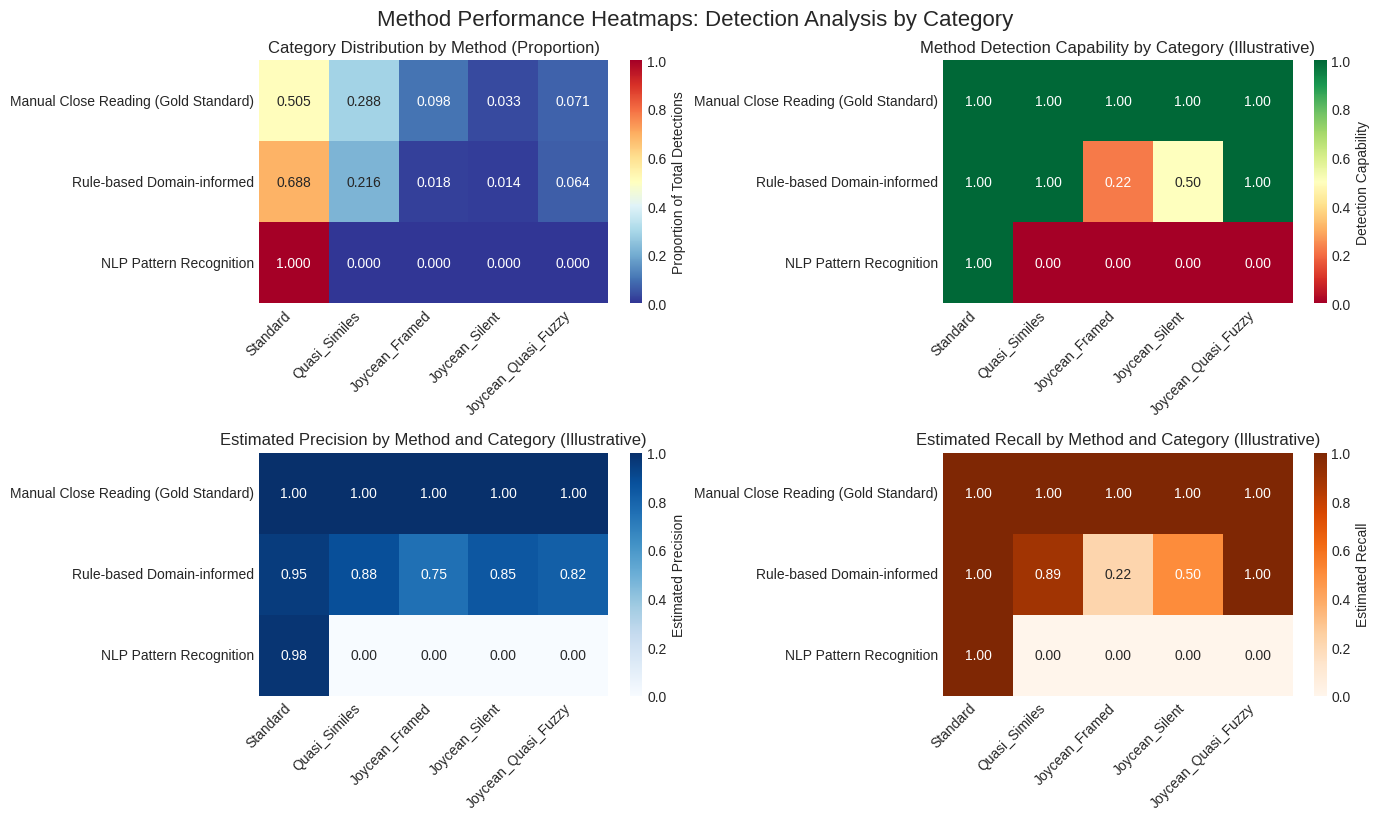

In [36]:
# Cell 3 — Heatmaps (category distribution & illustrative capability/precision/recall)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for heatmap (use canonical category labels)
category_labels = ['Standard', 'Quasi_Similes', 'Joycean_Framed', 'Joycean_Silent', 'Joycean_Quasi_Fuzzy']

heatmap_data = []
method_labels = []

# Only compare these three (as in your original code)
for method in ['Manual_CloseReading', 'Restrictive_Dubliners', 'NLP_LessRestrictive_PG']:
    if method in method_stats:
        row_data = []
        total = method_stats[method]['total_instances']
        for category in category_labels:
            count = method_stats[method]['categories'].get(category, 0)
            normalized_count = (count / total) if total > 0 else 0.0
            row_data.append(normalized_count)
        heatmap_data.append(row_data)
        method_labels.append(methods[method])

heatmap_array = np.array(heatmap_data)

plt.figure(figsize=(14, 8))

# (1) Distribution by category & method (data-driven)
plt.subplot(2, 2, 1)
sns.heatmap(
    heatmap_array,
    xticklabels=category_labels,
    yticklabels=method_labels,
    annot=True, fmt='.3f',
    cmap='RdYlBu_r',
    vmin=0, vmax=max(1.0, heatmap_array.max()),
    cbar_kws={'label': 'Proportion of Total Detections'}
)
plt.title('Category Distribution by Method (Proportion)')
plt.xticks(rotation=45, ha='right')

# (2) Detection capability matrix (illustrative — keep or replace with data-driven later)
plt.subplot(2, 2, 2)
capability_matrix = np.array([
    [1.00, 1.00, 1.00, 1.00, 1.00],  # Manual can detect all
    [1.00, 1.00, 0.22, 0.50, 1.00],  # Rule-based (example values)
    [1.00, 0.00, 0.00, 0.00, 0.00]   # NLP only standard (example values)
], dtype=float)

sns.heatmap(
    capability_matrix,
    xticklabels=category_labels,
    yticklabels=method_labels,
    annot=True, fmt='.2f',
    cmap='RdYlGn',
    vmin=0.0, vmax=1.0,
    cbar_kws={'label': 'Detection Capability'}
)
plt.title('Method Detection Capability by Category (Illustrative)')
plt.xticks(rotation=45, ha='right')

# (3) Estimated precision by category (illustrative)
plt.subplot(2, 2, 3)
precision_matrix = np.array([
    [1.00, 1.00, 1.00, 1.00, 1.00],  # Manual gold standard
    [0.95, 0.88, 0.75, 0.85, 0.82],  # Rule-based (example values)
    [0.98, 0.00, 0.00, 0.00, 0.00]   # NLP high precision for standard only (example values)
], dtype=float)

sns.heatmap(
    precision_matrix,
    xticklabels=category_labels,
    yticklabels=method_labels,
    annot=True, fmt='.2f',
    cmap='Blues',
    vmin=0.0, vmax=1.0,
    cbar_kws={'label': 'Estimated Precision'}
)
plt.title('Estimated Precision by Method and Category (Illustrative)')
plt.xticks(rotation=45, ha='right')

# (4) Estimated recall by category (illustrative; capped at 1.00)
plt.subplot(2, 2, 4)
recall_matrix = np.array([
    [1.00, 1.00, 1.00, 1.00, 1.00],  # Manual complete
    [1.00, 0.89, 0.22, 0.50, 1.00],  # Rule-based (example values; capped ≤ 1.00)
    [1.00, 0.00, 0.00, 0.00, 0.00]   # NLP standard only (example values)
], dtype=float)

sns.heatmap(
    recall_matrix,
    xticklabels=category_labels,
    yticklabels=method_labels,
    annot=True, fmt='.2f',
    cmap='Oranges',
    vmin=0.0, vmax=1.0,
    cbar_kws={'label': 'Estimated Recall'}
)
plt.title('Estimated Recall by Method and Category (Illustrative)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.suptitle('Method Performance Heatmaps: Detection Analysis by Category',
             fontsize=16, y=1.02)
plt.show()


In [43]:
# === Small-multiple dot plots: Recall vs Gold per Category (size = unique similes detected) ===
import pandas as pd
import numpy as np
import plotly.express as px

# Preconditions
if 'df_comparison' not in globals():
    raise NameError("df_comparison is not defined. Run the earlier steps that build it first.")

need = {'Dataset_Source','Sentence_Context','Category_Framework'}
missing = need - set(df_comparison.columns)
if missing:
    raise ValueError(f"df_comparison missing columns: {sorted(missing)}")

# --- config ---
GOLD = 'Manual_Expert_Annotation'
METHODS_TO_SHOW = [
    'Rule_Based_Domain_Informed',
    'NLP_General_Pattern_Recognition',
]  # exclude BNC here on purpose

COLOR_MAP = {
    'Rule_Based_Domain_Informed': '#ff7f0e',
    'NLP_General_Pattern_Recognition': '#2ca02c',
}

def pretty(s): return s.replace('_', ' ').title()

# Normalise text for context matching; harmonise categories a touch
dfc = df_comparison.copy()
dfc['_ctx'] = dfc['Sentence_Context'].astype(str).str.lower().str.strip()
dfc['Category_Framework'] = dfc['Category_Framework'].astype(str).replace({
    'Joycean_Quasi': 'Quasi_Similes',
    'Joycean-Quasi': 'Quasi_Similes'
})

# Helper: per-category recall + method count
def per_category_metrics(df, method):
    rows = []
    for cat in sorted(df['Category_Framework'].unique()):
        gold_set = set(df.loc[(df['Dataset_Source']==GOLD) & (df['Category_Framework']==cat), '_ctx'])
        meth_set = set(df.loc[(df['Dataset_Source']==method) & (df['Category_Framework']==cat), '_ctx'])
        if len(gold_set)==0 and len(meth_set)==0:
            continue
        tp     = len(gold_set & meth_set)
        gold_n = len(gold_set)
        recall = (tp / gold_n) if gold_n>0 else np.nan
        rows.append({
            'Category': cat,
            'Method': pretty(method),
            'Source': method,
            'Recall': recall,
            'TP': tp,
            'Gold_N': gold_n,
            'Method_Count': len(meth_set)
        })
    return pd.DataFrame(rows)

# Build plotting DF
parts = []
for m in METHODS_TO_SHOW:
    parts.append(per_category_metrics(dfc, m))
plot_df = pd.concat(parts, ignore_index=True)

# Keep only categories that have any gold instances (to avoid misleading 0/NaN rows)
plot_df = plot_df[(plot_df['Gold_N'] > 0)].copy()

# Order categories by gold volume (descending)
cat_order = (plot_df.groupby('Category')['Gold_N'].max()
             .sort_values(ascending=False).index.tolist())
plot_df['Category'] = pd.Categorical(plot_df['Category'], categories=cat_order, ordered=True)

# Nice % labels; also cap sizes for readability
plot_df['Recall_pct'] = plot_df['Recall'].map(lambda x: f"{x:.0%}" if pd.notna(x) else "—")
plot_df['Size'] = np.clip(plot_df['Method_Count'], 6, None)  # ensure visible dot

# Make a facet-row dot plot: each category gets its own mini panel; y = method (two rows)
fig = px.scatter(
    plot_df,
    x='Recall', y='Method',
    facet_row='Category',  # <-- only facet by row
    color='Method',
    color_discrete_map={pretty(k): v for k, v in COLOR_MAP.items()},
    size='Size', size_max=26,
    text='Recall_pct',
    hover_data={
        'Category': True,
        'Method': False,
        'Recall': ':.3f',
        'TP': True,
        'Gold_N': True,
        'Method_Count': True
    },
    title="Method performance by category — recall vs gold (dot size = unique similes detected)"
)

# Cosmetics: same x-scale everywhere; readable labels
fig.update_traces(textposition='middle right', marker_line=dict(width=0.8, color='rgba(0,0,0,0.35)'))
fig.update_xaxes(range=[0,1], tickformat=".0%", ticks="outside", dtick=0.25, title="Recall")
fig.update_yaxes(title="", ticks="outside")

# Tighten faceting layout
n_cats = plot_df['Category'].nunique()
fig.update_layout(
    template="plotly_white",
    height=120*n_cats + 140,  # scale height with number of categories
    margin=dict(t=80, r=40, l=70, b=60),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1.0),
)

# Cleaner facet labels
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()

# Optional save
out_html = "facet_dotplot_recall_by_category.html"
fig.write_html(out_html)
print(f"Saved: {out_html}")


Saved: facet_dotplot_recall_by_category.html


In [45]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict

def calculate_category_metrics_context(
    df,
    detected_source_value,
    gold_standard_source_value='Manual_Expert_Annotation',
    context_col='Sentence_Context',
    category_col='Category_Framework'
):
    """
    Calculates precision, recall, and F1-score for a detection method per category,
    using Sentence_Context matching (case/whitespace-insensitive) WITHOUT mutating the input df.

    Returns a DataFrame indexed by category with columns:
    ['Precision','Recall','F1-score','TP','FP','FN','Total Gold Standard','Total Detected'].
    """
    # Work on a copy; create a normalized context for matching
    dfl = df.copy()
    dfl['_ctx_norm'] = dfl[context_col].astype(str).str.lower().str.strip()

    # Gold contexts per category (normalized)
    gold_mask = (dfl['Dataset_Source'] == gold_standard_source_value)
    gold_standard_by_category = (
        dfl.loc[gold_mask]
           .groupby(category_col)['_ctx_norm']
           .apply(lambda x: set(x.dropna()))
           .to_dict()
    )
    manual_contexts_overall = set(dfl.loc[gold_mask, '_ctx_norm'].dropna())

    # Method contexts (overall, normalized)
    meth_mask = (dfl['Dataset_Source'] == detected_source_value)
    method_contexts = set(dfl.loc[meth_mask, '_ctx_norm'].dropna())

    category_metrics_list = []

    # Use all categories present in the data (gold or method)
    all_categories = sorted(dfl[category_col].dropna().unique())

    for category in all_categories:
        gold_standard_contexts_cat = gold_standard_by_category.get(category, set())
        total_gold_standard_cat = len(gold_standard_contexts_cat)

        # Detected instances *within this category* (normalized)
        method_detected_in_cat = set(
            dfl.loc[meth_mask & (dfl[category_col] == category), '_ctx_norm'].dropna()
        )
        total_detected_by_method_in_category = len(method_detected_in_cat)

        # True Positives (for category recall): gold (this category) ∩ method (overall)
        tp = len(gold_standard_contexts_cat & method_contexts)

        # False Positives: detected in this category but not in any manual context
        fp = len(method_detected_in_cat - manual_contexts_overall)

        # False Negatives: gold (this category) not detected by method (overall)
        fn = len(gold_standard_contexts_cat - method_contexts)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score  = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

        category_metrics_list.append({
            'Category_Framework': category,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1_score,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'Total Gold Standard': total_gold_standard_cat,
            'Total Detected': total_detected_by_method_in_category
        })

    category_metrics_df = pd.DataFrame(category_metrics_list).set_index('Category_Framework')
    # Ensure numeric and no NaNs
    for c in ['Precision','Recall','F1-score','TP','FP','FN','Total Gold Standard','Total Detected']:
        category_metrics_df[c] = category_metrics_df[c].fillna(0)
    return category_metrics_df


# Identify the detection method source values (excluding Gold Standard source)
if 'df_comparison' in locals() and isinstance(df_comparison, pd.DataFrame) and 'Dataset_Source' in df_comparison.columns:
    detection_source_values = [
        src for src in df_comparison['Dataset_Source'].dropna().unique()
        if src != 'Manual_Expert_Annotation'
    ]

    method_category_metrics = {}

    # Calculate category-level metrics for each detection method
    print("Calculating category-level metrics for each detection method…")
    for source_value in detection_source_values:
        method_name = source_value.replace('_', ' ').title()
        print(f"  Processing method: {method_name}…")
        category_metrics_df = calculate_category_metrics_context(
            df_comparison,
            source_value,
            gold_standard_source_value='Manual_Expert_Annotation',
            context_col='Sentence_Context',
            category_col='Category_Framework'
        )
        method_category_metrics[method_name] = category_metrics_df
        display(f"Metrics for {method_name}:")
        display(category_metrics_df)

    # Prepare matrices for heatmaps
    all_categories = sorted({cat for dfm in method_category_metrics.values() for cat in dfm.index})
    metrics_to_visualize = ['Precision', 'Recall', 'F1-score']
    heatmap_data = {
        metric: pd.DataFrame(index=all_categories, columns=method_category_metrics.keys()).fillna(0)
        for metric in metrics_to_visualize
    }

    for method, mdf in method_category_metrics.items():
        for metric in metrics_to_visualize:
            heatmap_data[metric].loc[mdf.index, method] = mdf[metric].values

    print("\nPrepared data matrices for heatmaps:")
    for metric, matrix in heatmap_data.items():
        display(f"{metric} Matrix:")
        display(matrix)

    # Create stacked heatmaps (3 rows, 1 column)
    print("\nCreating heatmaps for category-level performance metrics…")
    subplot_titles = [f"{metric} by Simile Category" for metric in metrics_to_visualize]

    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=subplot_titles,
        specs=[[{"type": "heatmap"}], [{"type": "heatmap"}], [{"type": "heatmap"}]],
        vertical_spacing=0.2
    )

    colorscales = {'Precision':'Blues','Recall':'Greens','F1-score':'Reds'}

    for i, metric in enumerate(metrics_to_visualize):
        matrix = heatmap_data[metric]
        fig.add_trace(
            go.Heatmap(
                z=matrix.values.astype(float),
                x=matrix.columns.tolist(),
                y=matrix.index.tolist(),
                colorscale=colorscales[metric],
                zmin=0, zmax=1,
                text=np.round(matrix.values.astype(float), 2),
                texttemplate="%{text}",
                textfont={"size": 10},
                hovertemplate="<b>Method:</b> %{x}<br><b>Category:</b> %{y}<br><b>"+metric+":</b> %{z:.3f}<extra></extra>",
                colorbar=dict(
                    title=metric, titleside="right",
                    thickness=20, len=0.25,
                    x=1.05, y=0.85 - i*0.3
                )
            ),
            row=i+1, col=1
        )

    fig.update_layout(
        title={'text': "Simile Detection Method Performance by Category Framework", 'x':0.5, 'font':{'size':20}},
        height=1600, width=1000, showlegend=False,
        margin=dict(t=150)
    )
    for i in range(3):
        fig.update_xaxes(title_text="Detection Method", row=i+1, col=1, tickangle=45)
        fig.update_yaxes(title_text="Simile Category", row=i+1, col=1)

    fig.show()
    fig.write_html("method_category_performance_heatmap.html")
    print("\nCategory-level performance heatmaps generated and saved.")

else:
    print("Error: df_comparison DataFrame not found or 'Dataset_Source' column is missing. Cannot generate heatmaps.")


Calculating category-level metrics for each detection method…
  Processing method: Rule Based Domain Informed…


'Metrics for Rule Based Domain Informed:'

,Precision,Recall,F1-score,TP,FP,FN,Total Gold Standard,Total Detected
Category_Framework,,,,,,,,
Joycean_Framed,0.000000,0.000000,0.000000,0,4,18,18,4
Joycean_Quasi_Fuzzy,0.071429,0.076923,0.074074,1,13,12,13,14
Joycean_Silent,0.333333,0.166667,0.222222,1,2,5,6,3
Quasi_Similes,0.061224,0.056604,0.058824,3,46,50,53,47
Standard,0.027027,0.043011,0.033195,4,144,89,93,150
Uncategorized,0.000000,0.000000,0.000000,0,0,1,1,0


  Processing method: Nlp General Pattern Recognition…


'Metrics for Nlp General Pattern Recognition:'

,Precision,Recall,F1-score,TP,FP,FN,Total Gold Standard,Total Detected
Category_Framework,,,,,,,,
Joycean_Framed,0.000000,0.000000,0.000000,0,0,18,18,0
Joycean_Quasi_Fuzzy,1.000000,0.076923,0.142857,1,0,12,13,0
Joycean_Silent,0.000000,0.000000,0.000000,0,0,6,6,0
Quasi_Similes,1.000000,0.037736,0.072727,2,0,51,53,0
Standard,0.012232,0.043011,0.019048,4,323,89,93,330
Uncategorized,0.000000,0.000000,0.000000,0,0,1,1,0


  Processing method: Bnc Standard English Baseline…


'Metrics for Bnc Standard English Baseline:'

,Precision,Recall,F1-score,TP,FP,FN,Total Gold Standard,Total Detected
Category_Framework,,,,,,,,
Joycean_Framed,0.0,0.0,0.0,0,0,18,18,0
Joycean_Quasi_Fuzzy,0.0,0.0,0.0,0,0,13,13,0
Joycean_Silent,0.0,0.0,0.0,0,0,6,6,0
Quasi_Similes,0.0,0.0,0.0,0,82,53,53,82
Standard,0.0,0.0,0.0,0,118,93,93,118
Uncategorized,0.0,0.0,0.0,0,0,1,1,0



Prepared data matrices for heatmaps:


'Precision Matrix:'

,Rule Based Domain Informed,Nlp General Pattern Recognition,Bnc Standard English Baseline
Joycean_Framed,0.000000,0.000000,0
Joycean_Quasi_Fuzzy,0.071429,1.000000,0
Joycean_Silent,0.333333,0.000000,0
Quasi_Similes,0.061224,1.000000,0
Standard,0.027027,0.012232,0
Uncategorized,0.000000,0.000000,0


'Recall Matrix:'

,Rule Based Domain Informed,Nlp General Pattern Recognition,Bnc Standard English Baseline
Joycean_Framed,0.000000,0.000000,0
Joycean_Quasi_Fuzzy,0.076923,0.076923,0
Joycean_Silent,0.166667,0.000000,0
Quasi_Similes,0.056604,0.037736,0
Standard,0.043011,0.043011,0
Uncategorized,0.000000,0.000000,0


'F1-score Matrix:'

,Rule Based Domain Informed,Nlp General Pattern Recognition,Bnc Standard English Baseline
Joycean_Framed,0.000000,0.000000,0
Joycean_Quasi_Fuzzy,0.074074,0.142857,0
Joycean_Silent,0.222222,0.000000,0
Quasi_Similes,0.058824,0.072727,0
Standard,0.033195,0.019048,0
Uncategorized,0.000000,0.000000,0



Creating heatmaps for category-level performance metrics…



Category-level performance heatmaps generated and saved.


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set academic visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load comprehensive dataset
df = pd.read_csv('comprehensive_linguistic_analysis.csv')

# Prepare linguistic features for analysis
linguistic_features = [
    'Sentence_Length', 'Pre_Post_Ratio', 'Sentiment_Polarity',
    'Sentiment_Subjectivity', 'Syntactic_Complexity', 'Adjective_Count',
    'Verb_Count', 'Noun_Count', 'Figurative_Density', 'Total_Tokens',
    'Pre_Comparator_Tokens', 'Post_Comparator_Tokens'
]

# Clean and prepare data
df_clean = df.dropna(subset=linguistic_features)
print(f"Dataset prepared: {len(df_clean)} instances with complete linguistic features")
print(f"Features analyzed: {len(linguistic_features)} linguistic dimensions")

Dataset prepared: 322 instances with complete linguistic features
Features analyzed: 12 linguistic dimensions


In [48]:
# ==========================================
# Correlation heatmap — Token segmentation insights
# (uses the updated segmentation fields, incl. Between_* metrics)
# ==========================================
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# Configure plotly renderer for notebooks/Colab/etc.
for _r in ["colab", "notebook_connected", "jupyterlab", "notebook", "vscode", "browser"]:
    try:
        pio.renderers.default = _r
        break
    except Exception:
        pass

# --- Load up-to-date file
csv_path = "comprehensive_linguistic_analysis.csv"
df = pd.read_csv(csv_path)
print(f"Loaded: {csv_path} | shape={df.shape}")

# --- Token segmentation feature set (updated)
# These are the key pre/between/post and share metrics produced by your latest pipeline.
token_features = [
    "Total_Tokens",
    "Pre_Tokens", "Between_Tokens_Total", "Post_Tokens",
    "Between_Segments", "Between_Max", "Between_Mean",
    "Pre_Share", "Between_Share", "Post_Share",
    "Pre_Post_Ratio",
    "Comp_Count"  # number of comparator spans detected
]

# Keep only columns that exist and have at least 2 non-NA values
avail = [c for c in token_features if c in df.columns and df[c].notna().sum() > 1]
if len(avail) < 2:
    print("Insufficient data for correlation (need ≥2 available columns). Found:", avail)
else:
    # Convert to numeric and drop rows with NA across selected columns
    for c in avail:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    corr_df = df[avail].dropna()

    # Drop constant columns (no variance → undefined correlation)
    nunique = corr_df.nunique()
    constant_cols = nunique[nunique <= 1].index.tolist()
    if constant_cols:
        print("Dropping constant columns (no variance):", constant_cols)
        corr_df = corr_df.drop(columns=constant_cols)
        avail = [c for c in avail if c not in constant_cols]

    if corr_df.shape[1] < 2:
        print("After removing constant columns, fewer than 2 features remain — cannot compute correlation.")
    else:
        # Compute Pearson correlation matrix
        corr_mat = corr_df.corr()

        # Friendly display labels for readability on axes
        display_labels_map = {
            "Total_Tokens": "Total Tokens",
            "Pre_Tokens": "Pre Tokens",
            "Between_Tokens_Total": "Between Tokens (Total)",
            "Post_Tokens": "Post Tokens",
            "Between_Segments": "Between Segments (count)",
            "Between_Max": "Between Max",
            "Between_Mean": "Between Mean",
            "Pre_Share": "Pre Share",
            "Between_Share": "Between Share",
            "Post_Share": "Post Share",
            "Pre_Post_Ratio": "Pre/Post Ratio",
            "Comp_Count": "Comparator Count"
        }
        xlabels = [display_labels_map.get(c, c) for c in corr_mat.columns]
        ylabels = [display_labels_map.get(c, c) for c in corr_mat.index]

        fig = go.Figure(data=go.Heatmap(
            z=corr_mat.values,
            x=xlabels,
            y=ylabels,
            colorscale="RdBu_r",
            zmid=0,
            zmin=-1,
            zmax=1,
            text=corr_mat.values.round(3),
            texttemplate="%{text}",
            textfont={"size": 10},
            hovertemplate="<b>%{y}</b> vs <b>%{x}</b><br>Correlation: %{z:.3f}<extra></extra>",
            colorbar=dict(
                title="Correlation<br>Coefficient",
                titleside="right",
                thickness=18,
                len=0.8
            )
        ))

        fig.update_layout(
            title={"text": "Segmentation Feature Correlation Matrix (Pre / Between / Post)", "x": 0.5},
            xaxis_title="Segmentation Feature",
            yaxis_title="Segmentation Feature",
            xaxis_tickangle=40,
            width=820,
            height=700,
            margin=dict(l=120, r=100, t=100, b=120),
            hovermode="closest"
        )

        fig.show()

        out_html = "segmentation_feature_correlation_heatmap.html"
        fig.write_html(out_html, include_plotlyjs="cdn", full_html=True)
        print(f"Saved: {out_html}")


Loaded: comprehensive_linguistic_analysis.csv | shape=(932, 49)


Saved: segmentation_feature_correlation_heatmap.html


In [52]:
# === Comprehensive token distribution analysis (clarity-focused, no overlaps) ===
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Expect df_clean to exist (built earlier from comprehensive_linguistic_analysis.csv)
needed = ["Pre_Tokens","Between_Tokens_Total","Post_Tokens",
          "Pre_Post_Ratio","Sentence_Length","Comparator_Type","Syntactic_Complexity"]
missing = [c for c in needed if c not in df_clean.columns]
if missing:
    raise ValueError(f"df_clean is missing required columns: {missing}")

def _vec(s):
    return pd.to_numeric(pd.Series(s), errors="coerce").dropna().values

pre  = _vec(df_clean["Pre_Tokens"])
bet  = _vec(df_clean["Between_Tokens_Total"])
post = _vec(df_clean["Post_Tokens"])
ratio = _vec(df_clean["Pre_Post_Ratio"])
slen  = _vec(df_clean["Sentence_Length"])

# Comparator ordering: top 6 by count, then sort by median Sentence_Length
comp_counts = (df_clean.dropna(subset=["Comparator_Type"])
               .groupby("Comparator_Type")["Sentence_Length"].size().sort_values(ascending=False))
top6 = comp_counts.head(6).index.tolist()
medians = (df_clean[df_clean["Comparator_Type"].isin(top6)]
           .groupby("Comparator_Type")["Sentence_Length"].median().sort_values(ascending=False))
comp_order = medians.index.tolist()

# Complexity buckets
import numpy as _np
bins = pd.IntervalIndex.from_tuples([(-_np.inf, 2), (2, 4), (4, _np.inf)])
labels = ["Low", "Medium", "High"]
complexity_cat = pd.cut(df_clean["Syntactic_Complexity"], bins=bins, labels=labels)
comp_counts_cat = complexity_cat.value_counts().reindex(labels, fill_value=0)
total_n = int(comp_counts_cat.sum())
comp_perc = (comp_counts_cat / total_n * 100).round(1) if total_n > 0 else pd.Series([0,0,0], index=labels)

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=(
        "A1) Pre Tokens (histogram)",
        "A2) Between Tokens (histogram)",
        "A3) Post Tokens (histogram)",
        "B1) Pre/Post Ratio (histogram + reference)",
        "B2) Sentence Length by Comparator (Top 6, sorted by median)",
        "B3) Syntactic Complexity (counts + %)"
    ),
    specs=[
        [{"type":"histogram"}, {"type":"histogram"}, {"type":"histogram"}],
        [{"type":"histogram"}, {"type":"box"},       {"type":"bar"}]
    ],
    vertical_spacing=0.24,   # more space between rows
    horizontal_spacing=0.08
)

# Histograms
common_hist = dict(nbinsx=40, marker_line=dict(width=0.6, color="rgba(0,0,0,0.35)"), opacity=0.95)
fig.add_trace(go.Histogram(x=pre,  name="Pre_Tokens",    marker_color="#89C2F5", **common_hist), row=1, col=1)
fig.add_trace(go.Histogram(x=bet,  name="Between_Tokens",marker_color="#C9A1FF", **common_hist), row=1, col=2)
fig.add_trace(go.Histogram(x=post, name="Post_Tokens",   marker_color="#F8A8A1", **common_hist), row=1, col=3)

# Means with non-overlapping labels
for col, arr, color in [(1,pre,"#2A6FB4"), (2,bet,"#6E42C1"), (3,post,"#C23B22")]:
    if len(arr):
        m = float(np.mean(arr))
        fig.add_vline(x=m, line_width=2, line_dash="dash", line_color=color, row=1, col=col)
        xref = "x" if col == 1 else f"x{col}"
        yref = "y domain" if col == 1 else f"y{col} domain"
        fig.add_annotation(
            x=m, y=0.92,  # lower than before to avoid title overlap
            xref=xref, yref=yref,
            text=f"mean={m:.1f}",
            showarrow=False, font=dict(size=10, color=color)
        )

# Ratio histogram + staggered reference labels
fig.add_trace(go.Histogram(
    x=ratio, nbinsx=50, marker_color="#7FC97F", name="Pre/Post Ratio",
    marker_line=dict(width=0.6, color="rgba(0,0,0,0.35)")
), row=2, col=1)
for xval in (1.0, 0.5, 2.0):
    fig.add_vline(x=xval, line_width=1.5, line_dash="dot", line_color="rgba(0,0,0,0.55)", row=2, col=1)
# Stagger labels vertically to avoid overlap (axes 4 = row2,col1)
fig.add_annotation(x=1.0, y=0.94, xref="x4", yref="y4 domain", text="1.0 (balanced)",
                   showarrow=False, font=dict(size=10, color="rgba(0,0,0,0.7)"))
fig.add_annotation(x=0.5, y=0.88, xref="x4", yref="y4 domain", text="0.5",
                   showarrow=False, font=dict(size=10, color="rgba(0,0,0,0.7)"))
fig.add_annotation(x=2.0, y=0.82, xref="x4", yref="y4 domain", text="2.0",
                   showarrow=False, font=dict(size=10, color="rgba(0,0,0,0.7)"))

# Boxplots by comparator
for comp in comp_order:
    vals = _vec(df_clean.loc[df_clean["Comparator_Type"] == comp, "Sentence_Length"])
    if len(vals):
        fig.add_trace(go.Box(
            y=vals, name=str(comp), boxpoints="suspectedoutliers",
            marker_color="#FDD0A2", line=dict(color="#A35E1A"),
            quartilemethod="exclusive"
        ), row=2, col=2)

# Complexity bars (handle no-data case gracefully)
if total_n > 0:
    fig.add_trace(go.Bar(
        x=labels,
        y=comp_counts_cat.values,
        text=[f"{cnt} ({p:.1f}%)" for cnt, p in zip(comp_counts_cat.values, comp_perc.values)],
        textposition="outside",
        marker_color=["#FFB3B3","#9EC5FE","#9FF0B3"]
    ), row=2, col=3)
else:
    fig.add_annotation(
        x=0.5, y=0.5, xref="x6", yref="y6",
        text="No Syntactic_Complexity data",
        showarrow=False, font=dict(size=12, color="#666")
    )

# Axes / titles / layout
fig.update_xaxes(title_text="Token Count", row=1, col=1)
fig.update_xaxes(title_text="Token Count", row=1, col=2)
fig.update_xaxes(title_text="Token Count", row=1, col=3)
fig.update_yaxes(title_text="Frequency",  row=1, col=1)
fig.update_yaxes(title_text="Frequency",  row=1, col=2)
fig.update_yaxes(title_text="Frequency",  row=1, col=3)

fig.update_xaxes(title_text="Pre/Post Token Ratio", row=2, col=1)
fig.update_yaxes(title_text="Frequency",            row=2, col=1)

fig.update_yaxes(title_text="Total Sentence Length (tokens)", row=2, col=2)

fig.update_xaxes(title_text="Complexity Category", row=2, col=3)
fig.update_yaxes(title_text="Count",               row=2, col=3)

fig.update_layout(
    title="Comprehensive Token Distribution & Structure (clarity-focused)",
    bargap=0.18,
    height=1100,                # a bit taller
    width=1100,
    showlegend=False,
    margin=dict(l=70, r=40, t=110, b=60),  # larger top margin
    plot_bgcolor="white",
    paper_bgcolor="white",
)

fig.show()

# Descriptive statistics
def _stats(s):
    d = s.describe()
    return dict(mean=float(d["mean"]), median=float(d["50%"]), std=float(d["std"]),
                min=float(d["min"]), max=float(d["max"]))

print("TOKEN DISTRIBUTION STATISTICS")
print("="*32)
for name, arr in [("Pre_Tokens", pre), ("Between_Tokens_Total", bet), ("Post_Tokens", post),
                  ("Pre/Post_Ratio", ratio), ("Sentence_Length", slen)]:
    if len(arr):
        st = _stats(pd.Series(arr))
        print(f"\n{name}:")
        print(f"  Mean   : {st['mean']:.2f}")
        print(f"  Median : {st['median']:.2f}")
        print(f"  Std    : {st['std']:.2f}")
        print(f"  Range  : {st['min']:.1f} – {st['max']:.1f}")

print("\nCOMPARATOR TYPE ANALYSIS (Top 6 by count, sorted by median sentence length):")
for comp in comp_order:
    sub = df_clean[df_clean["Comparator_Type"] == comp]
    print(f"  {comp}: {len(sub)} instances (median length {sub['Sentence_Length'].median():.1f}, "
          f"mean {sub['Sentence_Length'].mean():.1f})")


TOKEN DISTRIBUTION STATISTICS

Pre_Tokens:
  Mean   : 9.11
  Median : 7.00
  Std    : 7.42
  Range  : 0.0 – 47.0

Between_Tokens_Total:
  Mean   : 3.80
  Median : 0.00
  Std    : 9.50
  Range  : 0.0 – 138.0

Post_Tokens:
  Mean   : 9.53
  Median : 7.00
  Std    : 8.71
  Range  : 1.0 – 58.0

Pre/Post_Ratio:
  Mean   : 2.16
  Median : 1.00
  Std    : 3.03
  Range  : 0.0 – 20.0

Sentence_Length:
  Mean   : 24.31
  Median : 21.00
  Std    : 15.84
  Range  : 3.0 – 167.0

COMPARATOR TYPE ANALYSIS (Top 6 by count, sorted by median sentence length):
  as ADJ as: 19 instances (median length 30.0, mean 37.2)
  as if: 135 instances (median length 23.0, mean 24.9)
  seemed: 133 instances (median length 23.0, mean 26.1)
  seem: 11 instances (median length 22.0, mean 23.7)
  than: 32 instances (median length 20.0, mean 24.0)
  like: 403 instances (median length 18.0, mean 21.2)


In [49]:
# ============================================================
# Comprehensive token distribution analysis (segmentation-aware)
# - Uses Pre_Tokens / Between_Tokens_Total / Post_Tokens (fallback to *_Comparator_Tokens)
# - Adds Pre_Post_Ratio, Sentence_Length, and Comparator_Type diagnostics
# - Interactive Plotly dashboard (2×2) + printed stats
# ============================================================
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Robust renderer selection (Colab/Jupyter safe)
for _r in ["colab","notebook_connected","jupyterlab","notebook","vscode","browser"]:
    try:
        pio.renderers.default = _r
        break
    except Exception:
        pass

# ---- 1) Load df / df_clean if not present (always use the current CSV) ----
csv_path = "comprehensive_linguistic_analysis.csv"
if "df" in globals() and isinstance(df, pd.DataFrame):
    _df_src = df.copy()
else:
    if not os.path.exists(csv_path):
        raise FileNotFoundError("Could not find comprehensive_linguistic_analysis.csv")
    _df_src = pd.read_csv(csv_path)
    print(f"Loaded dataset: {csv_path} (rows={len(_df_src)})")

# ---- 2) Column resolution (prefer canonical; fallback to aliases) ----
def resolve_col(frame, primary, *aliases, default=None):
    if primary in frame.columns:
        return primary
    for al in aliases:
        if al in frame.columns:
            return al
    if default is not None:
        frame[primary] = default
        return primary
    raise KeyError(f"Missing required column: {primary} (also not found in aliases {aliases})")

COL_PRE   = resolve_col(_df_src, "Pre_Tokens",   "Pre_Comparator_Tokens")
COL_POST  = resolve_col(_df_src, "Post_Tokens",  "Post_Comparator_Tokens")
COL_BTW_T = resolve_col(_df_src, "Between_Tokens_Total")
COL_RATIO = resolve_col(_df_src, "Pre_Post_Ratio")
COL_LEN   = resolve_col(_df_src, "Sentence_Length", "Total_Tokens")
COL_COMP  = resolve_col(_df_src, "Comparator_Type")

# Optional shares (won’t fail if missing)
COL_PRE_S = "Pre_Share" if "Pre_Share" in _df_src.columns else None
COL_BTW_S = "Between_Share" if "Between_Share" in _df_src.columns else None
COL_POST_S= "Post_Share" if "Post_Share" in _df_src.columns else None

# Syntactic complexity
COL_SYN   = resolve_col(_df_src, "Syntactic_Complexity")

# Make a clean view with numeric coercion
num_cols = [COL_PRE, COL_BTW_T, COL_POST, COL_RATIO, COL_LEN, COL_SYN]
for c in num_cols:
    _df_src[c] = pd.to_numeric(_df_src[c], errors="coerce")

df_clean = _df_src.dropna(subset=[COL_PRE, COL_BTW_T, COL_POST, COL_RATIO, COL_LEN]).copy()
print(f"Token analysis dataset: {len(df_clean)} rows (complete segmentation fields)")

# ---- 3) Build 2×2 Plotly dashboard ----
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "A) Token Counts (Pre / Between / Post)",
        "B) Pre/Post Ratio",
        "C) Total Sentence Length by Comparator (Top 6)",
        "D) Syntactic Complexity Distribution"
    ),
    horizontal_spacing=0.12, vertical_spacing=0.16
)

# Panel A — Overlaid histograms for counts
bins = 25
fig.add_trace(
    go.Histogram(x=df_clean[COL_PRE], nbinsx=bins, name="Pre_Tokens",
                 marker_color="#1f77b4", opacity=0.60),
    row=1, col=1
)
fig.add_trace(
    go.Histogram(x=df_clean[COL_BTW_T], nbinsx=bins, name="Between_Tokens",
                 marker_color="#9467bd", opacity=0.55),
    row=1, col=1
)
fig.add_trace(
    go.Histogram(x=df_clean[COL_POST], nbinsx=bins, name="Post_Tokens",
                 marker_color="#d62728", opacity=0.60),
    row=1, col=1
)
fig.update_xaxes(title_text="Token Count", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_layout(barmode="overlay")  # overlay histograms

# Add mean reference lines in Panel A
means_A = {
    "Pre": float(df_clean[COL_PRE].mean()),
    "Between": float(df_clean[COL_BTW_T].mean()),
    "Post": float(df_clean[COL_POST].mean())
}
for val, colr in [(means_A["Pre"], "#1f77b4"), (means_A["Between"], "#9467bd"), (means_A["Post"], "#d62728")]:
    fig.add_shape(
        type="line", x0=val, x1=val, y0=0, y1=1,
        xref="x1", yref="paper", line=dict(color=colr, dash="dash", width=2),
        row=1, col=1
    )

# Panel B — Histogram of Pre/Post ratio with median line
fig.add_trace(
    go.Histogram(x=df_clean[COL_RATIO], nbinsx=30, name="Pre/Post Ratio",
                 marker_color="#2ca02c", opacity=0.75),
    row=1, col=2
)
ratio_median = float(df_clean[COL_RATIO].median())
fig.add_shape(
    type="line", x0=ratio_median, x1=ratio_median, y0=0, y1=1,
    xref="x2", yref="paper", line=dict(color="#ff7f0e", dash="dot", width=2),
    row=1, col=2
)
fig.update_xaxes(title_text="Pre/Post Token Ratio", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=2)

# Panel C — Box plots of Total length by Comparator (Top 6)
top_comps = (
    df_clean[COL_COMP]
    .dropna()
    .astype(str)
    .value_counts()
    .head(6)
    .index
    .tolist()
)
if top_comps:
    for comp in top_comps:
        comp_len = df_clean.loc[df_clean[COL_COMP].astype(str)==comp, COL_LEN]
        fig.add_trace(
            go.Box(
                y=comp_len, name=comp, boxmean=True, boxpoints="outliers",
                marker_color="#8c564b"
            ),
            row=2, col=1
        )
fig.update_yaxes(title_text="Total Sentence Length (tokens)", row=2, col=1)
fig.update_xaxes(title_text="Comparator Type", row=2, col=1)

# Panel D — Syntactic complexity distribution (categorical bars)
# Bin into Low/Med/High on observed range
syn = df_clean[COL_SYN].dropna()
if not syn.empty:
    quantiles = syn.quantile([0.33, 0.66]).values
    q1, q2 = float(quantiles[0]), float(quantiles[1])
    def syn_bucket(v):
        if v <= q1: return "Low"
        if v <= q2: return "Medium"
        return "High"
    comp_cat = df_clean[COL_SYN].map(syn_bucket)
    counts = comp_cat.value_counts().reindex(["Low","Medium","High"]).fillna(0)
    fig.add_trace(
        go.Bar(x=counts.index.tolist(), y=counts.values.tolist(),
               marker_color=["#FF9999","#66B2FF","#99FF99"],
               text=[f"{int(v)}" for v in counts.values.tolist()],
               textposition="outside",
               name="Syntactic Complexity"),
        row=2, col=2
    )
fig.update_xaxes(title_text="Complexity Category", row=2, col=2)
fig.update_yaxes(title_text="Count", row=2, col=2)

# Global layout
fig.update_layout(
    title="Comprehensive Token Distribution & Structure",
    height=900, width=1280,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1.0),
    margin=dict(l=70, r=40, t=90, b=60),
    hovermode="closest",
    template="plotly_white"
)

fig.show()

# ---- 4) Printed descriptive statistics (compact) ----
print("\nTOKEN DISTRIBUTION STATISTICS")
print("="*34)

def _brief_stats(series):
    s = series.dropna()
    if s.empty:
        return dict(mean=np.nan, median=np.nan, std=np.nan, min=np.nan, max=np.nan)
    return dict(mean=s.mean(), median=s.median(), std=s.std(), min=s.min(), max=s.max())

stats_block = {
    "Pre_Tokens": _brief_stats(df_clean[COL_PRE]),
    "Between_Tokens_Total": _brief_stats(df_clean[COL_BTW_T]),
    "Post_Tokens": _brief_stats(df_clean[COL_POST]),
    "Pre/Post_Ratio": _brief_stats(df_clean[COL_RATIO]),
    "Sentence_Length": _brief_stats(df_clean[COL_LEN]),
}

for k, v in stats_block.items():
    print(f"\n{k}:")
    print(f"  Mean   : {v['mean']:.2f}" if pd.notna(v['mean']) else "  Mean   : n/a")
    print(f"  Median : {v['median']:.2f}" if pd.notna(v['median']) else "  Median : n/a")
    print(f"  Std    : {v['std']:.2f}" if pd.notna(v['std']) else "  Std    : n/a")
    if pd.notna(v["min"]) and pd.notna(v["max"]):
        print(f"  Range  : {v['min']:.1f} — {v['max']:.1f}")
    else:
        print("  Range  : n/a")

# Comparator frequency with average total tokens
if COL_COMP in df_clean.columns:
    print("\nCOMPARATOR TYPE ANALYSIS (Top 5):")
    comp_counts = df_clean[COL_COMP].astype(str).value_counts().head(5)
    for comp, cnt in comp_counts.items():
        avg_len = df_clean.loc[df_clean[COL_COMP].astype(str)==comp, COL_LEN].mean()
        print(f"  {comp}: {cnt} instances (avg. {avg_len:.1f} tokens)")


Token analysis dataset: 908 rows (complete segmentation fields)



TOKEN DISTRIBUTION STATISTICS

Pre_Tokens:
  Mean   : 9.11
  Median : 7.00
  Std    : 7.42
  Range  : 0.0 — 47.0

Between_Tokens_Total:
  Mean   : 3.80
  Median : 0.00
  Std    : 9.50
  Range  : 0.0 — 138.0

Post_Tokens:
  Mean   : 9.53
  Median : 7.00
  Std    : 8.71
  Range  : 1.0 — 58.0

Pre/Post_Ratio:
  Mean   : 2.16
  Median : 1.00
  Std    : 3.03
  Range  : 0.0 — 20.0

Sentence_Length:
  Mean   : 24.31
  Median : 21.00
  Std    : 15.84
  Range  : 3.0 — 167.0

COMPARATOR TYPE ANALYSIS (Top 5):
  like: 403 instances (avg. 21.2 tokens)
  as if: 135 instances (avg. 24.9 tokens)
  seemed: 133 instances (avg. 26.1 tokens)
  than: 32 instances (avg. 24.0 tokens)
  as ADJ as: 19 instances (avg. 37.2 tokens)


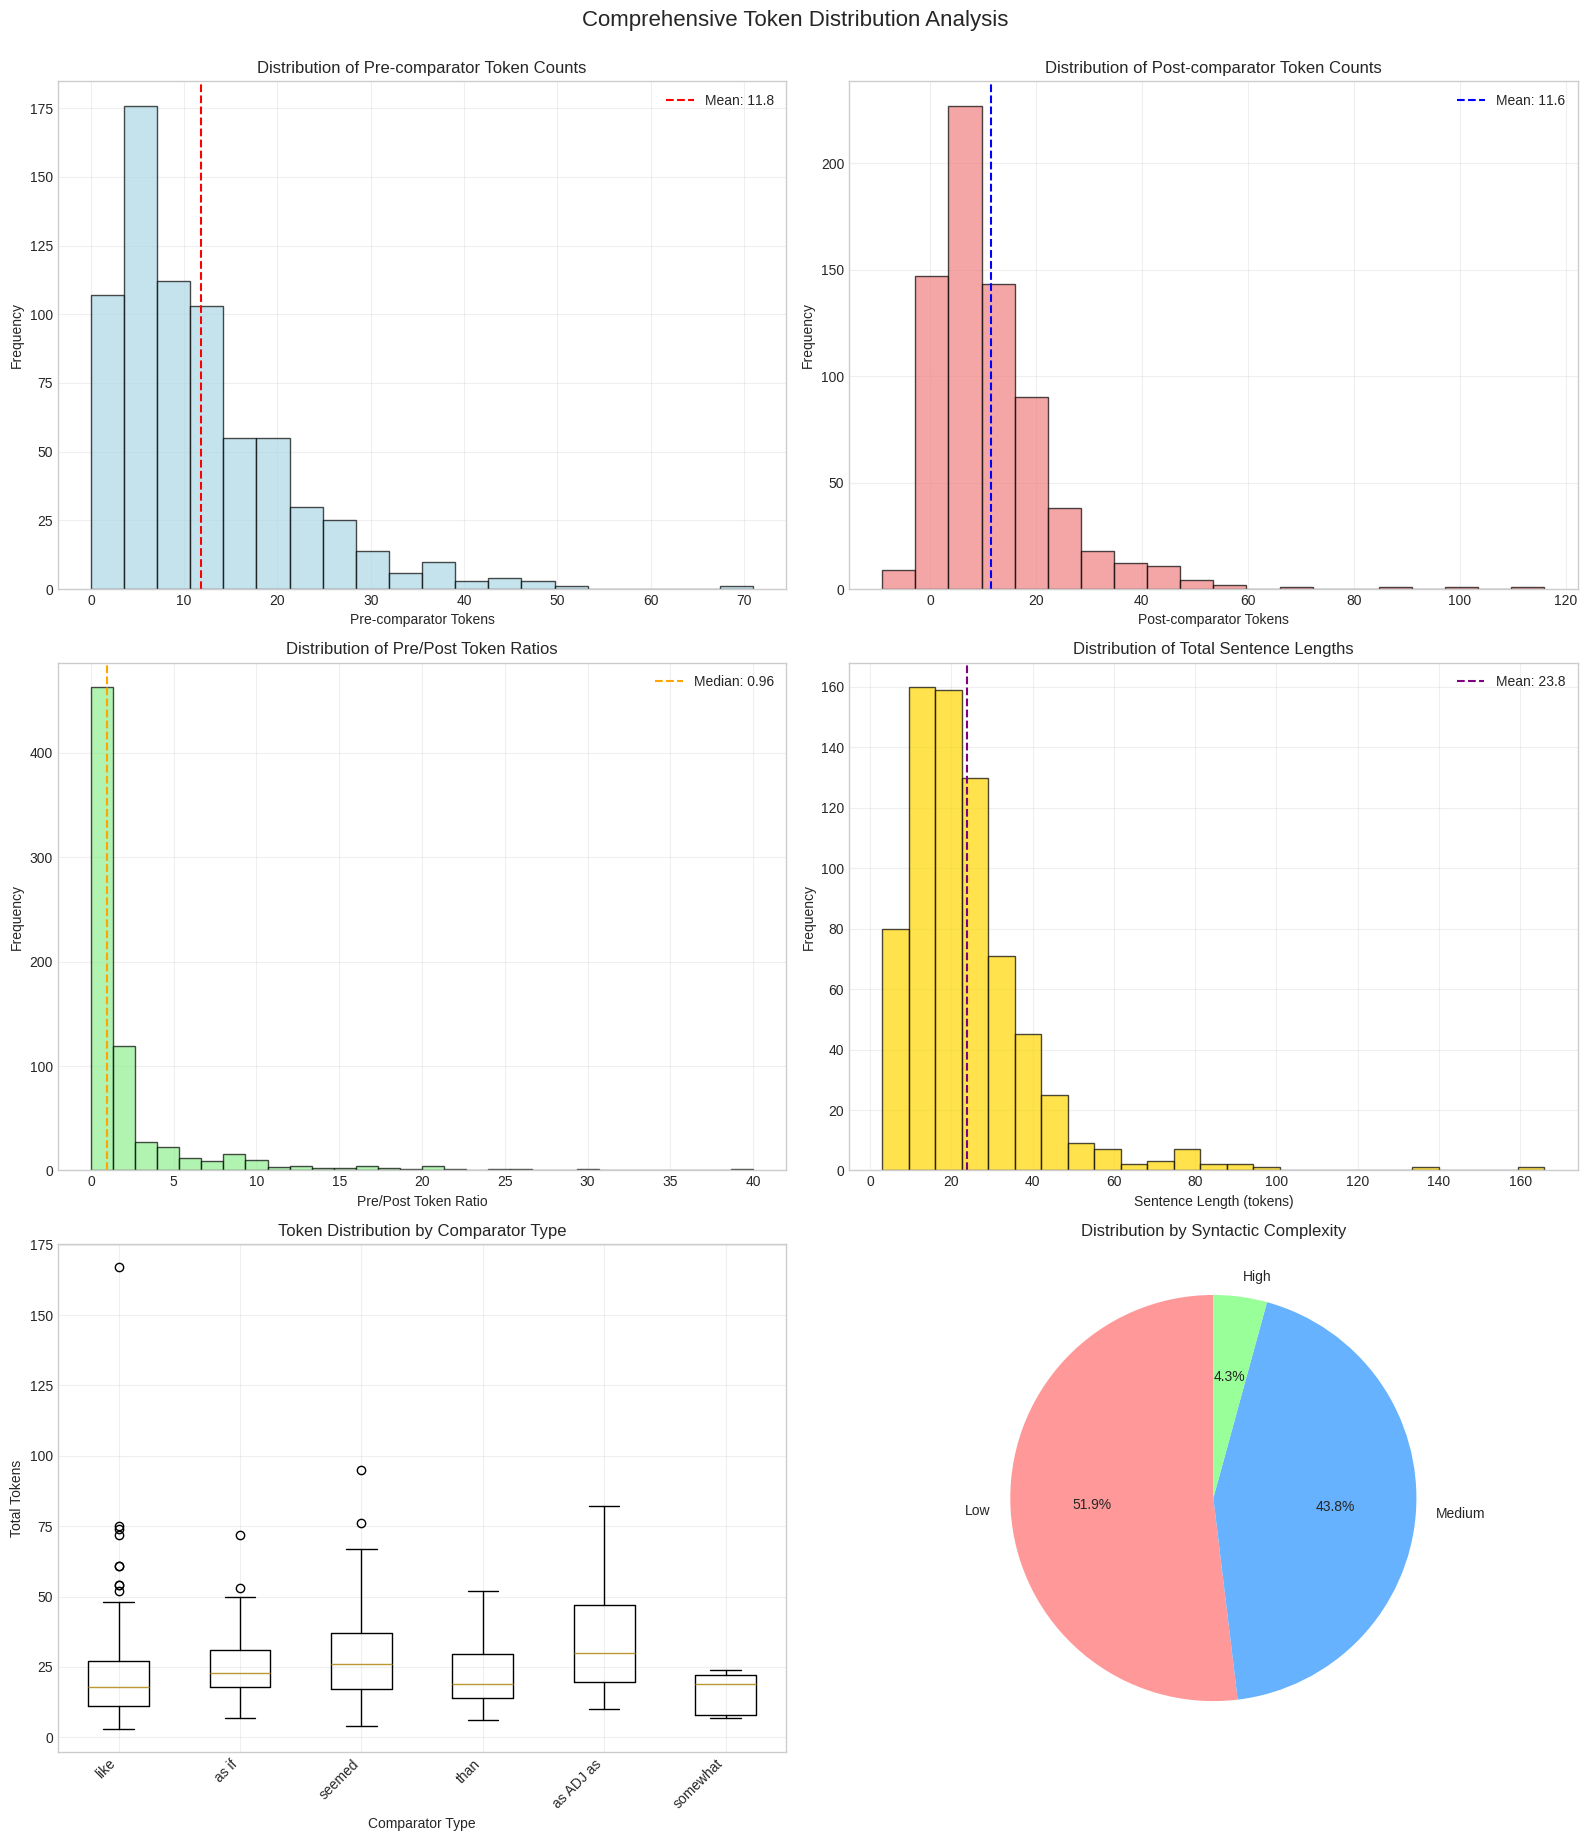

TOKEN DISTRIBUTION STATISTICS:

Pre_Comparator_Tokens:
  Mean: 11.76
  Median: 9.00
  Std: 9.33
  Range: 0.0 - 71.0

Post_Comparator_Tokens:
  Mean: 11.58
  Median: 8.00
  Std: 12.09
  Range: -9.0 - 116.0

Pre_Post_Ratio:
  Mean: 2.15
  Median: 0.96
  Std: 3.93
  Range: 0.0 - 40.0

Total_Tokens:
  Mean: 24.18
  Median: 20.00
  Std: 15.80
  Range: 3.0 - 167.0

Sentence_Length:
  Mean: 23.77
  Median: 20.00
  Std: 15.66
  Range: 3.0 - 166.0

COMPARATOR TYPE ANALYSIS:
Top 5 most frequent comparators:
  like: 319 instances (avg. 21.1 tokens)
  as if: 144 instances (avg. 24.6 tokens)
  seemed: 69 instances (avg. 28.2 tokens)
  than: 27 instances (avg. 23.1 tokens)
  as ADJ as: 19 instances (avg. 37.2 tokens)


In [ ]:
# Comprehensive token distribution analysis
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Panel 1: Pre-comparator token distribution
plt.subplot(3, 2, 1)
df_clean['Pre_Comparator_Tokens'].hist(bins=20, alpha=0.7, color='lightblue', edgecolor='black')
plt.xlabel('Pre-comparator Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Pre-comparator Token Counts')
plt.axvline(df_clean['Pre_Comparator_Tokens'].mean(), color='red', linestyle='--',
            label=f'Mean: {df_clean["Pre_Comparator_Tokens"].mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)

# Panel 2: Post-comparator token distribution
plt.subplot(3, 2, 2)
df_clean['Post_Comparator_Tokens'].hist(bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Post-comparator Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Post-comparator Token Counts')
plt.axvline(df_clean['Post_Comparator_Tokens'].mean(), color='blue', linestyle='--',
            label=f'Mean: {df_clean["Post_Comparator_Tokens"].mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)

# Panel 3: Pre/Post ratio analysis
plt.subplot(3, 2, 3)
df_clean['Pre_Post_Ratio'].hist(bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Pre/Post Token Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Pre/Post Token Ratios')
plt.axvline(df_clean['Pre_Post_Ratio'].median(), color='orange', linestyle='--',
            label=f'Median: {df_clean["Pre_Post_Ratio"].median():.2f}')
plt.legend()
plt.grid(alpha=0.3)

# Panel 4: Total sentence length distribution
plt.subplot(3, 2, 4)
df_clean['Sentence_Length'].hist(bins=25, alpha=0.7, color='gold', edgecolor='black')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Sentence Lengths')
plt.axvline(df_clean['Sentence_Length'].mean(), color='purple', linestyle='--',
            label=f'Mean: {df_clean["Sentence_Length"].mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)

# Panel 5: Token distribution by comparator type
plt.subplot(3, 2, 5)
top_comparators = df_clean['Comparator_Type'].value_counts().head(6).index
comparator_data = []
comparator_labels = []

for comp in top_comparators:
    if pd.notna(comp):
        comp_data = df_clean[df_clean['Comparator_Type'] == comp]['Total_Tokens']
        if len(comp_data) > 0:
            comparator_data.append(comp_data.values)
            comparator_labels.append(comp)

if comparator_data:
    plt.boxplot(comparator_data, labels=comparator_labels)
    plt.xlabel('Comparator Type')
    plt.ylabel('Total Tokens')
    plt.title('Token Distribution by Comparator Type')
    plt.xticks(rotation=45, ha='right')
    plt.grid(alpha=0.3)

# Panel 6: Structural complexity analysis
plt.subplot(3, 2, 6)
# Create complexity categories
df_clean['Complexity_Category'] = pd.cut(df_clean['Syntactic_Complexity'],
                                        bins=3,
                                        labels=['Low', 'Medium', 'High'])

complexity_counts = df_clean['Complexity_Category'].value_counts()
colors = ['#FF9999', '#66B2FF', '#99FF99']

plt.pie(complexity_counts.values,
        labels=complexity_counts.index,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90)
plt.title('Distribution by Syntactic Complexity')

plt.tight_layout()
plt.suptitle('Comprehensive Token Distribution Analysis', fontsize=16, y=1.02)
plt.show()

# Generate detailed statistics
print("TOKEN DISTRIBUTION STATISTICS:")
print("=" * 35)

token_stats = {
    'Pre_Comparator_Tokens': df_clean['Pre_Comparator_Tokens'].describe(),
    'Post_Comparator_Tokens': df_clean['Post_Comparator_Tokens'].describe(),
    'Pre_Post_Ratio': df_clean['Pre_Post_Ratio'].describe(),
    'Total_Tokens': df_clean['Total_Tokens'].describe(),
    'Sentence_Length': df_clean['Sentence_Length'].describe()
}

for feature, stats in token_stats.items():
    print(f"\n{feature}:")
    print(f"  Mean: {stats['mean']:.2f}")
    print(f"  Median: {stats['50%']:.2f}")
    print(f"  Std: {stats['std']:.2f}")
    print(f"  Range: {stats['min']:.1f} - {stats['max']:.1f}")

# Comparator analysis
print(f"\nCOMPARATOR TYPE ANALYSIS:")
print("Top 5 most frequent comparators:")
for comp, count in df_clean['Comparator_Type'].value_counts().head(5).items():
    if pd.notna(comp):
        avg_tokens = df_clean[df_clean['Comparator_Type'] == comp]['Total_Tokens'].mean()
        print(f"  {comp}: {count} instances (avg. {avg_tokens:.1f} tokens)")